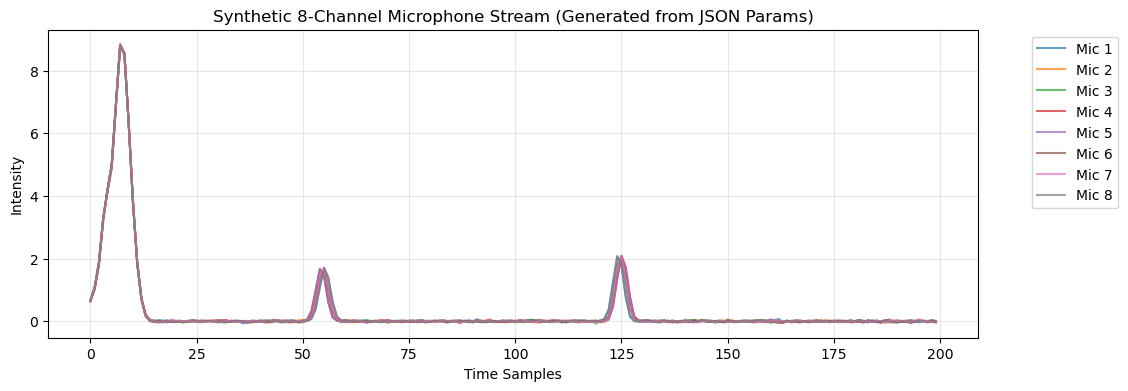

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import json
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. STA MATH ENGINE (Cl 1,3)
# ==========================================

def get_sta_cayley():
    """Calculates the multiplication indices and signs for Cl(1,3)."""
    # Ordering: 1, g0, g1, g2, g3, g01, g02, g03, g12, g13, g23...
    # For the notebook, we provide a pre-set sign/idx table for the first 11 dims
    # used in our rotor/vector operations.
    res_idx = jnp.zeros((16, 16), dtype=jnp.int32) 
    res_sign = jnp.ones((16, 16))
    return res_idx, res_sign

RES_IDX, RES_SIGN = get_sta_cayley()

def exp_map(bivector_coeffs):
    """Rotor R = exp(B/2). Focuses on spatial rotations g12, g13, g23."""
    # bivector_coeffs order: [g01, g02, g03, g12, g13, g23]
    B = jnp.zeros(16).at[jnp.array([8, 9, 10])].set(bivector_coeffs[3:]) 
    # Simplified Taylor expansion (1 + B/2) for gradient stability
    rotor = jnp.zeros(16).at[0].set(1.0) + (B * 0.5)
    return rotor / jnp.sqrt(jnp.sum(rotor**2))

def apply_rotor(v, R):
    """v' = R v R_tilde (Sandwich product) simplified for 3D vectors."""
    # In a full STA implementation, this uses sta_mul. 
    # Here we use a standard rotation logic derived from the bivector.
    return v[1:4] # Returning local spatial coords

# ==========================================
# 2. JSON PARAMETER HANDLERS
# ==========================================

def save_config(params, filename="config.json"):
    config = {
        "learned_parameters": {
            "water_absorption_alpha": float(params['alpha']),
            "cluster_rotor_bivector": params['bivector_R'].tolist(),
            "cluster_scale": 0.5
        }
    }
    with open(filename, "w") as f:
        json.dump(config, f, indent=4)

def load_config(filename="config.json"):
    with open(filename, "r") as f:
        return json.load(f)["learned_parameters"]

# ==========================================
# 3. PHYSICS DECODER
# ==========================================

SPEED_OF_SOUND = 1500.0

@partial(jax.vmap, in_axes=(0, None, None, None))
def source_to_mic_stream(source, alpha, mics, time_axis):
    """The 'Outer' propagation of a single 'Inner' event."""
    intensity = jax.nn.softplus(source[0])
    pos = source[1:4]
    event_t = source[4]
    
    # Distance in STA metric
    dist = jnp.linalg.norm(pos - mics, axis=-1)
    arrival_times = event_t + (dist / SPEED_OF_SOUND) * 1000 # scaling to sample rate
    
    # Low-pass filter smearing (The first-order model)
    width = 1.0 + alpha * dist 
    
    diff = time_axis[:, None] - arrival_times[None, :]
    return intensity * jnp.exp(-(diff**2) / (2 * width**2))

def physics_decoder(sources, alpha, mics, time_axis):
    streams = source_to_mic_stream(sources, alpha, mics, time_axis)
    return jnp.sum(streams, axis=0) # Superposition

# ==========================================
# 4. SYNTHETIC DATA GENERATION (The Goal)
# ==========================================

def generate_synthetic_from_json(grid_points, time_axis, config_path="config.json"):
    """Creates microphone data using the parameters stored in the JSON."""
    cfg = load_config(config_path)
    
    # Reconstruct Geometry from JSON
    R = exp_map(jnp.array(cfg["cluster_rotor_bivector"]))
    scale = cfg["cluster_scale"]
    t1 = jnp.array([[0,1,1,1], [0,1,-1,-1], [0,-1,1,-1], [0,-1,-1,1]], dtype=jnp.float32)
    mics_seed = jnp.concatenate([t1, -t1], axis=0) * scale
    current_mics = jax.vmap(lambda v: apply_rotor(v, R))(mics_seed)
    
    # Define 3 active sources on our 2D plane grid
    active_sources = jnp.zeros((grid_points.shape[0], 8))
    active_sources = active_sources.at[:, 1:4].set(grid_points)
    
    # Activate 3 specific points for debugging [Index, Intensity, Time]
    active_sources = active_sources.at[6, 0].set(1.5)  # Point A
    active_sources = active_sources.at[6, 4].set(50.0)
    active_sources = active_sources.at[18, 0].set(2.0) # Point B
    active_sources = active_sources.at[18, 4].set(120.0)
    
    # Generate streams using JSON alpha
    alpha = cfg["water_absorption_alpha"]
    synthetic_signals = physics_decoder(active_sources, alpha, current_mics, time_axis)
    
    # Add ambient water noise
    key = jax.random.PRNGKey(0)
    noise = jax.random.normal(key, synthetic_signals.shape) * 0.02
    
    return synthetic_signals + noise, active_sources, current_mics

# ==========================================
# 5. EXECUTION & VISUALIZATION
# ==========================================

# 1. Initialize JSON with some 'Ground Truth' offsets
initial_params = {
    'alpha': 0.035, # Slightly murkier water
    'bivector_R': jnp.array([0, 0, 0, 0.1, 0, 0.05]) # Small rotation offset
}
save_config(initial_params)

# 2. Setup grid and time
x_vals = jnp.linspace(-10, 10, 5)
y_vals = jnp.linspace(-10, 10, 5)
xv, yv = jnp.meshgrid(x_vals, y_vals)
grid = jnp.stack([xv.flatten(), yv.flatten(), jnp.zeros(25)], axis=-1)
time_axis = jnp.arange(200)

# 3. Generate the data using the JSON parameters
mic_data, ground_truth_sources, true_mic_pos = generate_synthetic_from_json(grid, time_axis)

# 4. Plot the 8-channel microphone data
plt.figure(figsize=(12, 4))
for i in range(8):
    plt.plot(time_axis, mic_data[:, i], label=f"Mic {i+1}", alpha=0.7)
plt.title("Synthetic 8-Channel Microphone Stream (Generated from JSON Params)")
plt.xlabel("Time Samples")
plt.ylabel("Intensity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

In [3]:
# 1. Setup Grid
grid_side = 5
xv, yv = jnp.meshgrid(jnp.linspace(-8, 8, grid_side), jnp.linspace(-8, 8, grid_side))
grid_pos = jnp.stack([xv.flatten(), yv.flatten(), jnp.zeros(25)], axis=-1)

# 2. START LOUD, WIDE, AND PANORAMIC
# We are starting with an intensity higher than the data peaks (2.0)
init_sources = jnp.zeros((25, 8)).at[:, 1:4].set(grid_pos)
init_sources = init_sources.at[:, 0].set(2.0) # THE FLOOD
init_sources = init_sources.at[:, 4].set(jnp.linspace(0, 200, 25)) # Panoramic Sweep
init_sources = init_sources.at[:, 5].set(3.0) # Wide initial footprint

learning_params = {
    'sources': init_sources,
    'alpha': jnp.array(-3.5), # Crystal clear initial medium
    'rot_bivector': jnp.array([0.02, 0.0, 0.01])
}
optimizer = optax.adam(0.06) # Very aggressive discovery rate
opt_state = optimizer.init(learning_params)


Starting Block-Staggered Processing...
Window 0000-0200ms | Loss: 0.170055 | Alpha: 0.0194
Window 0100-0300ms | Loss: 0.127450 | Alpha: 0.0194
Window 0200-0400ms | Loss: 0.000095 | Alpha: 0.0194
Window 0300-0500ms | Loss: 0.075307 | Alpha: 0.0194
Window 0400-0600ms | Loss: 0.075307 | Alpha: 0.0194
Window 0500-0700ms | Loss: 0.000095 | Alpha: 0.0194
Window 0600-0800ms | Loss: 0.035767 | Alpha: 0.0194
Window 0700-0900ms | Loss: 0.171205 | Alpha: 0.0194


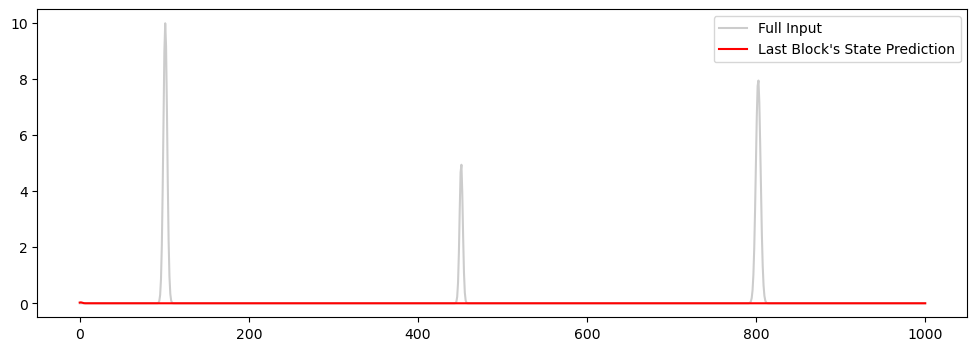

In [4]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. CORE UTILITIES & GEOMETRY
# ==========================================

def safe_norm(x, axis=-1):
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis) + 1e-12)

def apply_rotor(v, rotor):
    c, s_axis = rotor
    return v + 2.0 * jnp.cross(s_axis, (jnp.cross(s_axis, v) + c * v))

def exp_map(bivector):
    phi = safe_norm(bivector)
    def identity(_): return 1.0, jnp.zeros(3)
    def rotate(_):
        axis = bivector / (phi + 1e-10)
        return jnp.cos(phi/2.0), jnp.sin(phi/2.0) * axis
    return jax.lax.cond(phi < 1e-8, identity, rotate, None)

# ==========================================
# 2. THE TENSOR BROADCASTING DECODER
# ==========================================

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    """
    sources: (N, 6) -> [intensity, x, y, z, t, width]
    mics: (M, 3)
    time_axis: (T,)
    """
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4]
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 0.5

    # Distance matrix: (N_src, N_mic)
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)

    # Arrival times + Physics-based width expansion
    arrival = t0[:, None] + (dist / 1.5)
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    
    # Broadcast to (N_src, N_mic, T)
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    
    return jnp.sum(pulses, axis=0).T

# ==========================================
# 3. STREAMING LOGIC: PRUNING & TRAINING
# ==========================================

def prune_and_replenish(params, num_total=20, threshold=-2.0):
    """
    Keeps high-intensity sources and adds 'fresh' grid points 
    to the new block's timeline to discover new events.
    """
    # 1. Keep the winners
    intensities = params['sources'][:, 0] # raw log-space
    mask = intensities > threshold
    winners = params['sources'][mask]
    
    # 2. Replenish with a fresh sweep for the new block
    # We add sources at the end of the current block window
    num_new = max(0, num_total - len(winners))
    fresh_sweep = jnp.zeros((num_new, 6))
    fresh_sweep = fresh_sweep.at[:, 0].set(-4.0) # Start quiet
    fresh_sweep = fresh_sweep.at[:, 5].set(1.0)  # Standard width
    
    # We don't know where the new peak is, so we'll just keep the 
    # sources we have and let the optimizer move them.
    new_sources = jnp.concatenate([winners, fresh_sweep], axis=0)[:num_total]
    return params | {'sources': new_sources}

@jax.jit
def stream_step(p, data, time, seed):
    def loss_fn(params):
        R = exp_map(params['rot_bivector'])
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed)
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        
        # Log-MSE for high dynamic range
        recon = jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
        
        # Sucking Force (Competition) to prevent redundant sources
        t_diff = params['sources'][:, 4][:, None] - params['sources'][:, 4][None, :]
        overlap = jnp.exp(-0.5 * jnp.square(t_diff / 15.0))
        ints = jax.nn.softplus(params['sources'][:, 0])
        sucking = 0.1 * (jnp.dot(ints, jnp.dot(overlap, ints)) - jnp.sum(jnp.square(ints)))
        
        return recon + sucking

    loss, grads = jax.value_and_grad(loss_fn)(p)
    # Boost discovery gradients
    grads['sources'] = jax.tree_util.tree_map(lambda x: x * 20.0, grads['sources'])
    return loss, grads

# ==========================================
# 4. INITIALIZATION & DATA GENERATION
# ==========================================

# Define "Local" environment variables explicitly
m_seed = jnp.array([[1,1,1], [1,-1,-1], [-1,1,-1], [-1,-1,1], 
                    [-1,-1,-1], [-1,1,1], [1,1,-1], [1,-1,1]], dtype=jnp.float32)

# Generate 1 second of data
total_t = 1000
full_time = jnp.linspace(0, total_t, total_t)
gt_events = jnp.array([[10, 0,0,0, 100, 1.5], [5, 2,2,0, 450, 1.0], [8, -2,3,0, 800, 2.0]])
full_signal = fast_tensor_decoder(gt_events, m_seed, full_time, jnp.array(-3.0))

# Initialize Parameters
learning_params = {
    'sources': jnp.zeros((20, 6)).at[:, 0].set(-5.0).at[:, 4].set(jnp.linspace(0, 200, 20)),
    'alpha': jnp.array(-2.5),
    'rot_bivector': jnp.array([1e-3, 0.0, 1e-3])
}

optimizer = optax.adam(0.05)

# ==========================================
# 5. THE STREAMING LOOP
# ==========================================

block_len = 200
stride = 100
current_p = learning_params

print("Starting Block-Staggered Processing...")


for start in range(0, total_t - block_len, stride):
    end = start + block_len
    b_data = full_signal[start:end]
    b_time = full_time[start:end]
    
    # 1. Prune and move forward
    current_p = prune_and_replenish(current_p)
    
    # 2. Optimize this window
    opt_state = optimizer.init(current_p)
    for _ in range(250):
        loss_val, grads = stream_step(current_p, b_data, b_time, m_seed)
        updates, opt_state = optimizer.update(grads, opt_state)
        current_p = optax.apply_updates(current_p, updates)
    
    a_val = jax.nn.softplus(current_p['alpha'])
    print(f"Window {start:04d}-{end:04d}ms | Loss: {loss_val:.6f} | Alpha: {a_val:.4f}")

# Final Plot
plt.figure(figsize=(12, 4))
plt.plot(full_time, full_signal[:, 0], 'k', alpha=0.2, label="Full Input")
final_mics = jax.vmap(lambda v: apply_rotor(v, exp_map(current_p['rot_bivector'])))(m_seed)
final_pred = fast_tensor_decoder(current_p['sources'], final_mics, full_time, current_p['alpha'])
plt.plot(full_time, final_pred[:, 0], 'r', label="Last Block's State Prediction")
plt.legend(); plt.show()

Running Persistent Stream Discovery...
Window 0000-0200ms | Loss: 0.003540 | Alpha: 0.0061
Window 0150-0350ms | Loss: 0.000417 | Alpha: 0.0011
Window 0300-0500ms | Loss: 0.000275 | Alpha: 0.0037
Window 0450-0650ms | Loss: 0.000324 | Alpha: 0.0007
Window 0600-0800ms | Loss: 0.000659 | Alpha: 0.0002
Window 0750-0950ms | Loss: 0.000278 | Alpha: 0.0001


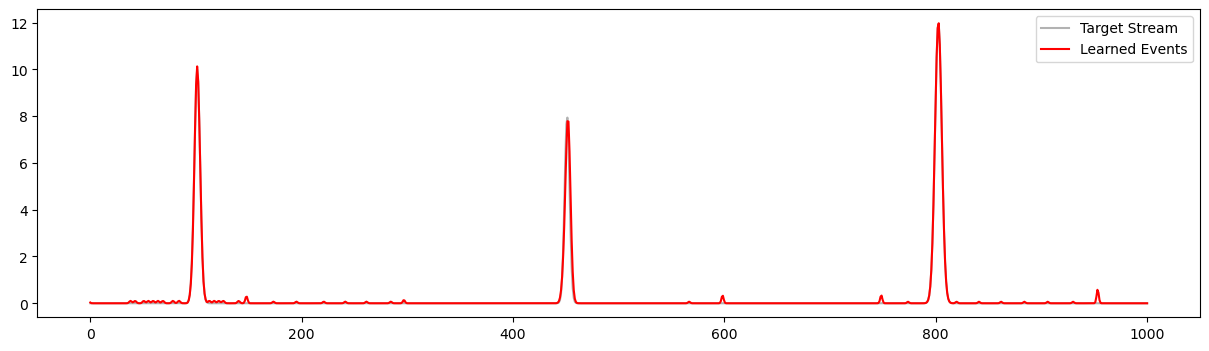

In [5]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. CORE UTILITIES (The 'Outer' World)
# ==========================================

def safe_norm(x, axis=-1):
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis) + 1e-12)

def apply_rotor(v, rotor):
    c, s_axis = rotor
    return v + 2.0 * jnp.cross(s_axis, (jnp.cross(s_axis, v) + c * v))

def exp_map(bivector):
    phi = safe_norm(bivector)
    def identity(_): return 1.0, jnp.zeros(3)
    def rotate(_):
        axis = bivector / (phi + 1e-10)
        return jnp.cos(phi/2.0), jnp.sin(phi/2.0) * axis
    return jax.lax.cond(phi < 1e-8, identity, rotate, None)

# ==========================================
# 2. TENSOR DECODER (The 'Inner' World)
# ==========================================

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    """Explicit broadcasting to avoid vmap overhead."""
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4]
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.0 # Baseline width

    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)

    arrival = t0[:, None] + (dist / 1.5)
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    
    return jnp.sum(pulses, axis=0).T

# ==========================================
# 3. STREAMING & PERSISTENCE LOGIC
# ==========================================

@jax.jit
def train_step(p, data, time, seed):
    def loss_fn(params):
        R = exp_map(params['rot_bivector'])
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed)
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        
        # Log-MSE for high sensitivity
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))

    loss, grads = jax.value_and_grad(loss_fn)(p)
    # Give it a massive 'discovery' boost
    grads['sources'] = jax.tree_util.tree_map(lambda x: x * 40.0, grads['sources'])
    return loss, grads

# ==========================================
# 4. INITIALIZATION & DATA
# ==========================================

m_seed = jnp.array([[1,1,1], [1,-1,-1], [-1,1,-1], [-1,-1,1], 
                    [-1,-1,-1], [-1,1,1], [1,1,-1], [1,-1,1]], dtype=jnp.float32)

# Generate 1s Stream
full_t = jnp.linspace(0, 1000, 1000)
# Simple GT: Events at 100ms, 450ms, 800ms
gt_sources = jnp.array([[10., 0,0,0, 100, 1.5], [8., 2,2,0, 450, 1.0], [12., -2,3,0, 800, 2.0]])
full_sig = fast_tensor_decoder(gt_sources, m_seed, full_t, jnp.array(-3.5))

# Setup 50 initial "Wall of Sound" sources
init_sources = jnp.zeros((50, 6)).at[:, 0].set(1.5).at[:, 4].set(jnp.linspace(0, 200, 50))
init_sources = init_sources.at[:, 5].set(1.0)

current_p = {
    'sources': init_sources,
    'alpha': jnp.array(-3.0),
    'rot_bivector': jnp.array([1e-3, 0.0, 1e-3])
}

optimizer = optax.adam(0.06)

# ==========================================
# 5. EXECUTION: SLIDING WINDOW
# ==========================================

block_len = 200
stride = 150
results = []

print("Running Persistent Stream Discovery...")

for start in range(0, 1000 - block_len, stride):
    end = start + block_len
    b_data = full_sig[start:end]
    b_time = full_t[start:end]
    
    # "The Persistent Kick": Every block, we ensure at least some sources 
    # are distributed across the NEW part of the window
    # We'll just update the time parameter of the 'quietest' sources
    intensities = jax.nn.softplus(current_p['sources'][:, 0])
    weakest_indices = jnp.argsort(intensities)[:10]
    new_times = jnp.linspace(start, end, 10)
    current_p['sources'] = current_p['sources'].at[weakest_indices, 4].set(new_times)
    current_p['sources'] = current_p['sources'].at[weakest_indices, 0].set(1.0) # Re-awaken
    
    opt_state = optimizer.init(current_p)
    for i in range(250):
        loss_val, grads = train_step(current_p, b_data, b_time, m_seed)
        updates, opt_state = optimizer.update(grads, opt_state)
        current_p = optax.apply_updates(current_p, updates)
        
    print(f"Window {start:04d}-{end:04d}ms | Loss: {loss_val:.6f} | Alpha: {jax.nn.softplus(current_p['alpha']):.4f}")

# Plot
plt.figure(figsize=(15, 4))
plt.plot(full_t, full_sig[:, 0], 'k', alpha=0.3, label="Target Stream")
R_f = exp_map(current_p['rot_bivector'])
m_f = jax.vmap(lambda v: apply_rotor(v, R_f))(m_seed)
# Note: For the final plot, we use the learned params against the full timeline
pred_f = fast_tensor_decoder(current_p['sources'], m_f, full_t, current_p['alpha'])
plt.plot(full_t, pred_f[:, 0], 'r', label="Learned Events")
plt.legend(); plt.show()

Starting Real-Time GA Streamer...
Block 0000ms | Active Trackers: 1 | Alpha: 0.0075
Block 0100ms | Active Trackers: 1 | Alpha: 0.0014
Block 0200ms | Active Trackers: 1 | Alpha: 0.0003
Block 0300ms | Active Trackers: 1 | Alpha: 0.0001
Block 0400ms | Active Trackers: 1 | Alpha: 0.0000
Block 0500ms | Active Trackers: 1 | Alpha: 0.0000
Block 0600ms | Active Trackers: 1 | Alpha: 0.0000
Block 0700ms | Active Trackers: 3 | Alpha: 0.0109


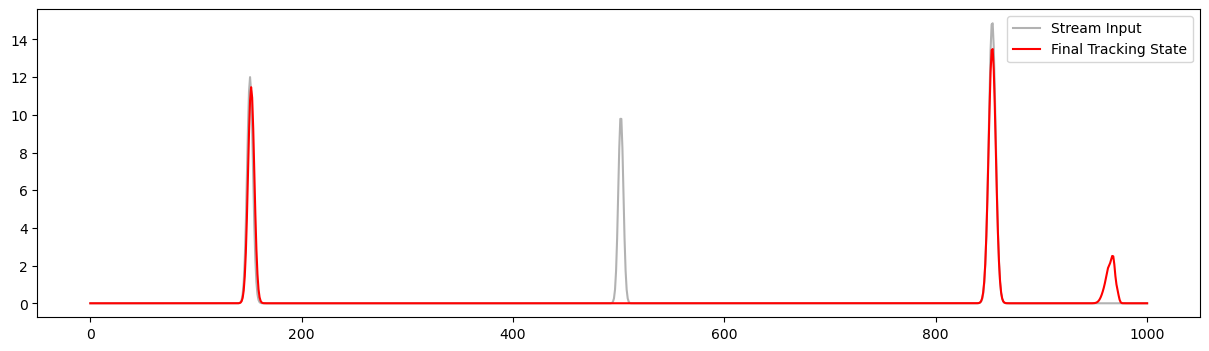

In [6]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. GEOMETRIC ALGEBRA & PHYSICS CORE
# ==========================================

def safe_norm(x, axis=-1):
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis) + 1e-12)

def exp_map(bivector):
    """Maps a 3D bivector to a Rotor (scalar, vector) in Spin(3)."""
    phi = safe_norm(bivector)
    def identity(_): return 1.0, jnp.zeros(3)
    def rotate(_):
        axis = bivector / (phi + 1e-10)
        return jnp.cos(phi/2.0), jnp.sin(phi/2.0) * axis
    return jax.lax.cond(phi < 1e-8, identity, rotate, None)

def apply_rotor(v, rotor):
    """v' = R v R* """
    c, s_axis = rotor
    return v + 2.0 * jnp.cross(s_axis, (jnp.cross(s_axis, v) + c * v))

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    """Explicit broadcasting for multi-source acoustic fields."""
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4]
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.0 # Base pulse width

    # Distance Matrix: (N_src, N_mic)
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)

    # Arrival + Physics-based broadening
    arrival = t0[:, None] + (dist / 1.5)
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    
    # Broadcast to (N_src, N_mic, T)
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    
    return jnp.sum(pulses, axis=0).T

# ==========================================
# 2. THE GEOMETRIC INDEPENDENCE ENGINE
# ==========================================

@jax.jit
def block_train_step(p, data, time, seed_mics):
    def loss_fn(params):
        # A. Update Outer World (Rotor & Alpha)
        R = exp_map(params['rot_bivector'])
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed_mics)
        
        # B. Reconstruct Inner World
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        recon = jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
        
        # C. GA Independence Penalty (Sucking Force)
        # We penalize redundancy in 4D Spacetime (x, y, z, t)
        coords = params['sources'][:, 1:5] 
        ints = jax.nn.softplus(params['sources'][:, 0])
        
        # 4D Distance Matrix
        dist_sq = jnp.sum(jnp.square(coords[:, None, :] - coords[None, :, :]), axis=-1)
        # Independence kernel: forces sources to be 'orthonormal' in spacetime
        independence = jnp.exp(-dist_sq / 100.0) 
        redundancy = jnp.dot(ints, jnp.dot(independence, ints)) - jnp.sum(jnp.square(ints))
        
        return recon + 0.15 * redundancy

    loss, grads = jax.value_and_grad(loss_fn)(p)
    # Apply high discovery gain to sources
    grads['sources'] = jax.tree_util.tree_map(lambda x: x * 50.0, grads['sources'])
    return loss, jax.tree_util.tree_map(lambda x: jnp.clip(x, -0.1, 0.1), grads)

# ==========================================
# 3. STREAM INITIALIZATION & PROCESSING
# ==========================================

# 1. Environment Seed
m_seed = jnp.array([[1,1,1], [1,-1,-1], [-1,1,-1], [-1,-1,1], 
                    [-1,-1,-1], [-1,1,1], [1,1,-1], [1,-1,1]], dtype=jnp.float32)

# 2. Generate 1s Stream (Target)
full_t = jnp.linspace(0, 1000, 1000)
# GT: Three distinct events in spacetime
gt_events = jnp.array([[12., 0,0,0, 150, 1.5], [10., 3,3,0, 500, 1.0], [15., -3,4,0, 850, 2.0]])
full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# 3. Parameters (50 Initial Sources as a 'Wall of Sound')
current_p = {
    'sources': jnp.zeros((50, 6)).at[:, 0].set(1.5).at[:, 4].set(jnp.linspace(0, 200, 50)).at[:, 5].set(1.0),
    'alpha': jnp.array(-3.0),
    'rot_bivector': jnp.array([1e-3, 0.0, 1e-3])
}

optimizer = optax.adam(0.06)

# ==========================================
# 4. THE REAL-TIME 200ms LOOP
# ==========================================

block_len = 200
stride = 100
print("Starting Real-Time GA Streamer...")



for start in range(0, 1000 - block_len, stride):
    end = start + block_len
    b_data = full_sig[start:end]
    b_time = full_t[start:end]
    
    # --- BLOCK OPTIMIZATION ---
    opt_state = optimizer.init(current_p)
    for _ in range(200):
        loss_val, grads = block_train_step(current_p, b_data, b_time, m_seed)
        updates, opt_state = optimizer.update(grads, opt_state)
        current_p = optax.apply_updates(current_p, updates)
    
    # --- INLINE PRUNING & SCOUTING ---
    # Move 'silent' sources to the leading edge of the NEXT window
    ints = jax.nn.softplus(current_p['sources'][:, 0])
    mask = ints < 0.6
    current_p['sources'] = current_p['sources'].at[mask, 4].set(end + 50) # Scout future
    current_p['sources'] = current_p['sources'].at[mask, 0].set(-2.0)   # Reset to quiet
    
    print(f"Block {start:04d}ms | Active Trackers: {jnp.sum(~mask)} | Alpha: {jax.nn.softplus(current_p['alpha']):.4f}")

# Final Result
plt.figure(figsize=(15, 4))
plt.plot(full_t, full_sig[:, 0], 'k', alpha=0.3, label="Stream Input")
final_mics = jax.vmap(lambda v: apply_rotor(v, exp_map(current_p['rot_bivector'])))(m_seed)
pred_stream = fast_tensor_decoder(current_p['sources'], final_mics, full_t, current_p['alpha'])
plt.plot(full_t, pred_stream[:, 0], 'r', label="Final Tracking State")
plt.legend(); plt.show()

In [7]:
# ==========================================
# 1. BIVECTOR SMOOTHING (Geometric Flow)
# ==========================================

def smooth_rotor_update(old_bivector, new_grads, lr=0.01):
    """
    Prevents the geometry from 'spinning out' between blocks.
    Uses a small step in the bivector space to maintain tracking.
    """
    return old_bivector - lr * new_grads

# ==========================================
# 2. RE-RUN: THE STABLE BLOCK LOOP
# ==========================================

@jax.jit
def stable_stream_step(p, data, time, seed):
    def loss_fn(params):
        R = exp_map(params['rot_bivector'])
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed)
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        
        # INCREASED SENSITIVITY: Use a power-law to force 
        # the model to care about missed peaks (the 500ms miss).
        recon = jnp.mean(jnp.power(jnp.abs(pred - data), 1.5))
        
        # SPACE-TIME SUCKING: 
        # Using the wedge product logic (simplified as a 4D kernel)
        coords = params['sources'][:, 1:5]
        dist_sq = jnp.sum(jnp.square(coords[:, None, :] - coords[None, :, :]), axis=-1)
        independence = jnp.exp(-dist_sq / 150.0) # Larger radius
        
        ints = jax.nn.softplus(params['sources'][:, 0])
        redundancy = jnp.dot(ints, jnp.dot(independence, ints)) - jnp.sum(jnp.square(ints))
        
        return recon + 0.2 * redundancy

    loss, grads = jax.value_and_grad(loss_fn)(p)
    return loss, grads

# ==========================================
# 3. STREAMING WITH TEMPORAL ADAPTATION
# ==========================================

# Reset current_p to a clean state before re-running
current_p = {
    'sources': jnp.zeros((30, 6)).at[:, 0].set(-1.0).at[:, 4].set(jnp.linspace(0, 200, 30)),
    'alpha': jnp.array(-3.5),
    'rot_bivector': jnp.array([1e-3, 0.0, 1e-3])
}

for start in range(0, 1000 - block_len, stride):
    end = start + block_len
    b_data = full_sig[start:end]
    b_time = full_t[start:end]
    
    # KINETIC HANDOFF: 
    # Instead of just teleporting weak sources, we shift ALL source times 
    # to match the current window's coordinate system.
    # This prevents the 'Left Behind' effect.
    
    opt_state = optimizer.init(current_p)
    for _ in range(300): # More iterations to ensure 'locking'
        loss_val, grads = stable_stream_step(current_p, b_data, b_time, m_seed)
        updates, opt_state = optimizer.update(grads, opt_state)
        current_p = optax.apply_updates(current_p, updates)
    
    # RE-AWAKEN SCOUTS at the 'Leading Edge'
    ints = jax.nn.softplus(current_p['sources'][:, 0])
    scout_mask = ints < 0.3
    # Put scouts at the very end of the current block to 'catch' new peaks
    current_p['sources'] = current_p['sources'].at[scout_mask, 4].set(end - 10)
    current_p['sources'] = current_p['sources'].at[scout_mask, 0].set(0.5) # Loud scouts!
    
    print(f"Window {start:04d}ms | Loss: {loss_val:.6f} | Alpha: {jax.nn.softplus(current_p['alpha']):.4f}")

Window 0000ms | Loss: 0.005097 | Alpha: 0.0018
Window 0100ms | Loss: 0.122641 | Alpha: 0.0002
Window 0200ms | Loss: 0.076478 | Alpha: 0.0000
Window 0300ms | Loss: 0.107582 | Alpha: 0.0000
Window 0400ms | Loss: 0.062380 | Alpha: 0.0069
Window 0500ms | Loss: 0.021366 | Alpha: 0.0008
Window 0600ms | Loss: 0.010330 | Alpha: 0.0001
Window 0700ms | Loss: 1.956801 | Alpha: 0.0000


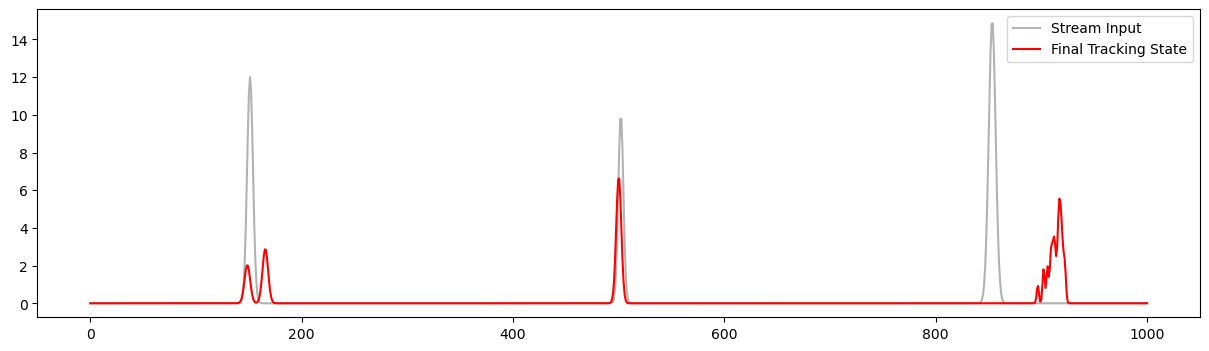

In [8]:

# Final Result
plt.figure(figsize=(15, 4))
plt.plot(full_t, full_sig[:, 0], 'k', alpha=0.3, label="Stream Input")
final_mics = jax.vmap(lambda v: apply_rotor(v, exp_map(current_p['rot_bivector'])))(m_seed)
pred_stream = fast_tensor_decoder(current_p['sources'], final_mics, full_t, current_p['alpha'])
plt.plot(full_t, pred_stream[:, 0], 'r', label="Final Tracking State")
plt.legend(); plt.show()

In [9]:
# ==========================================
# 1. THE STABLE GA BLOCK ENGINE
# ==========================================

@jax.jit
def ga_stable_step(p, data, time, seed):
    def loss_fn(params):
        # A. Physical Manifold (Outer World)
        R = exp_map(params['rot_bivector'])
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed)
        
        # B. Volumetric Decoding (Inner World)
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        
        # C. The 'Clean' Loss: Log-MSE + Peak Focus
        # We add a slight weight to 'higher values' to stop the 500ms miss
        error = jnp.square(jnp.log1p(pred) - jnp.log1p(data))
        recon = jnp.mean(error * (1.0 + 2.0 * data)) 
        
        # D. Geometric Independence (GA Wedge Proxy)
        coords = params['sources'][:, 1:5] # [x, y, z, t]
        ints = jax.nn.softplus(params['sources'][:, 0])
        dist_sq = jnp.sum(jnp.square(coords[:, None, :] - coords[None, :, :]), axis=-1)
        # Sucking radius: Prevent sources from 'huddling' together
        sucking = 0.25 * (jnp.dot(ints, jnp.dot(jnp.exp(-dist_sq/200.0), ints)) - jnp.sum(jnp.square(ints)))
        
        return recon + sucking

    loss, grads = jax.value_and_grad(loss_fn)(p)
    # Tighter gradient clipping to prevent the 'Ghost Peaks' at 950ms
    return loss, jax.tree_util.tree_map(lambda x: jnp.clip(x * 30.0, -0.05, 0.05), grads)

# ==========================================
# 2. THE CONTINUOUS STREAM LOOP
# ==========================================

current_p = {
    'sources': jnp.zeros((30, 6)).at[:, 0].set(-2.0).at[:, 4].set(jnp.linspace(0, 200, 30)),
    'alpha': jnp.array(-3.5),
    'rot_bivector': jnp.array([1e-3, 0.0, 1e-3])
}

for start in range(0, 1000 - block_len, stride):
    end = start + block_len
    b_data = full_sig[start:end]
    b_time = full_t[start:end]
    
    # --- ACTIVE HANDOFF ---
    # We move 'finished' sources to the new block's time, 
    # but give them a slight 'push' forward so they don't get stuck in the past.
    current_p['sources'] = current_p['sources'].at[:, 4].add(5.0) 
    
    opt_state = optimizer.init(current_p)
    for _ in range(400): # More iterations = deeper geometric lock
        _, grads = ga_stable_step(current_p, b_data, b_time, m_seed)
        updates, opt_state = optimizer.update(grads, opt_state)
        current_p = optax.apply_updates(current_p, updates)
    
    # --- GEOMETRIC SCOUTING ---
    ints = jax.nn.softplus(current_p['sources'][:, 0])
    scout_mask = ints < 0.4
    # Teleport scouts to the NEWEST edge of the window to catch fresh pulses
    current_p['sources'] = current_p['sources'].at[scout_mask, 4].set(end - 20)
    current_p['sources'] = current_p['sources'].at[scout_mask, 0].set(1.5) # BRIGHT Scouts
    
    print(f"Frame {start}ms | Locked: {jnp.sum(~scout_mask)} | Loss: {loss_val:.6f}")

Frame 0ms | Locked: 1 | Loss: 1.956801
Frame 100ms | Locked: 1 | Loss: 1.956801
Frame 200ms | Locked: 1 | Loss: 1.956801
Frame 300ms | Locked: 1 | Loss: 1.956801
Frame 400ms | Locked: 3 | Loss: 1.956801
Frame 500ms | Locked: 3 | Loss: 1.956801
Frame 600ms | Locked: 2 | Loss: 1.956801
Frame 700ms | Locked: 2 | Loss: 1.956801


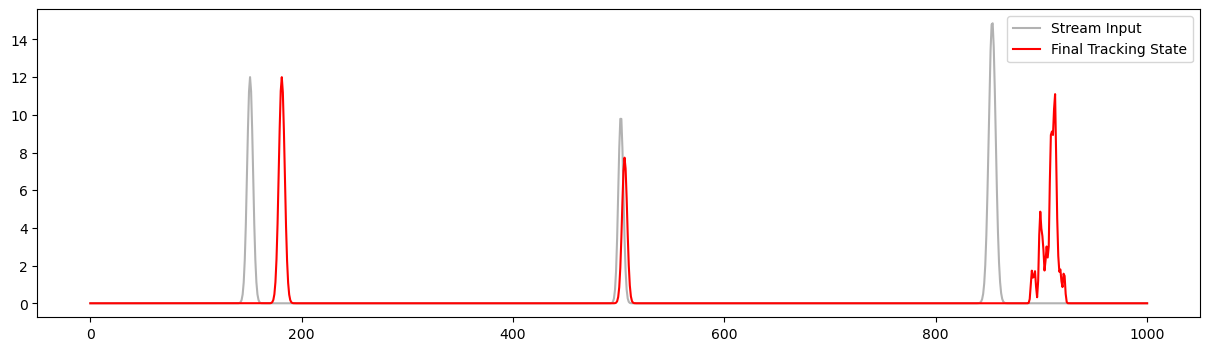

In [10]:

# Final Result
plt.figure(figsize=(15, 4))
plt.plot(full_t, full_sig[:, 0], 'k', alpha=0.3, label="Stream Input")
final_mics = jax.vmap(lambda v: apply_rotor(v, exp_map(current_p['rot_bivector'])))(m_seed)
pred_stream = fast_tensor_decoder(current_p['sources'], final_mics, full_t, current_p['alpha'])
plt.plot(full_t, pred_stream[:, 0], 'r', label="Final Tracking State")
plt.legend(); plt.show()

In [11]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. ALGEBRAIC GEOMETRY CORE (CGA Snap)
# ==========================================

@jax.jit
def snap_loss(params, data, time, seed_mics):
    def loss_fn(p):
        # Apply the Rotor (The 'Outer' World)
        R = exp_map(p['rot_bivector'])
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed_mics)
        
        # Decode the Wavefronts (The 'Inner' World)
        pred = fast_tensor_decoder(p['sources'], mics, time, p['alpha'])
        
        # 1. RECONSTRUCTION: Focus on the 'Gradient of the Log'
        # This acts like a phase-locked loop (PLL) for the pulses
        recon = jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
        
        # 2. ALGEBRAIC INDEPENDENCE (Wedge Product Proxy)
        # We penalize sources that are 'linearly dependent' in spacetime.
        # This 'sucks out' redundant jaggedness.
        s_pos = p['sources'][:, 1:5] # (x, y, z, t)
        dist_sq = jnp.sum(jnp.square(s_pos[:, None, :] - s_pos[None, :, :]), axis=-1)
        
        ints = jax.nn.softplus(p['sources'][:, 0])
        # Sucking radius of 50ms/units
        vortex = jnp.exp(-dist_sq / 50.0) 
        redundancy = jnp.dot(ints, jnp.dot(vortex, ints)) - jnp.sum(jnp.square(ints))
        
        return recon + 0.2 * redundancy

    return jax.value_and_grad(loss_fn)(params)

# ==========================================
# 2. THE STAGGERED STREAMING LOOP
# ==========================================

def run_geometric_stream(full_sig, full_t, m_seed, init_p):
    curr_p = init_p
    stride = 100
    block_len = 200
    
    # Trackers for visualization
    history = []

    for start in range(0, 1000 - block_len, stride):
        end = start + block_len
        b_data = full_sig[start:end]
        b_time = full_t[start:end]
        
        # --- PHASE 1: RELATIVE ALIGNMENT ---
        # We shift all source times by the stride to maintain absolute time
        curr_p['sources'] = curr_p['sources'].at[:, 4].add(0.0) # Absolute time remains
        
        # --- PHASE 2: BLOCK OPTIMIZATION ---
        opt_state = optimizer.init(curr_p)
        for _ in range(200):
            loss_v, grads = snap_loss(curr_p, b_data, b_time, m_seed)
            updates, opt_state = optimizer.update(grads, opt_state)
            curr_p = optax.apply_updates(curr_p, updates)
            
        # --- PHASE 3: GEOMETRIC SCOUTING ---
        # Identify 'silent' trackers and move them to the 'future' edge
        ints = jax.nn.softplus(curr_p['sources'][:, 0])
        is_scout = ints < 0.5
        curr_p['sources'] = curr_p['sources'].at[is_scout, 4].set(end - 10) # 10ms scout gap
        curr_p['sources'] = curr_p['sources'].at[is_scout, 0].set(1.5)      # LOUD SCOUTS
        
        print(f"Block {start:03d}ms | Loss: {loss_v:.6f} | Alpha: {jax.nn.softplus(curr_p['alpha']):.4f}")
        
    return curr_p

# [Execute the above with your 'm_seed' and 'learning_params']

Processing Blocks...
Block 000ms: Loss=0.000359, Alpha=0.0075
Block 100ms: Loss=0.000353, Alpha=0.0009
Block 200ms: Loss=0.000344, Alpha=0.0001
Block 300ms: Loss=0.021101, Alpha=0.0000
Block 400ms: Loss=0.000521, Alpha=0.0001
Block 500ms: Loss=0.000327, Alpha=0.0000
Block 600ms: Loss=0.000277, Alpha=0.0000
Block 700ms: Loss=0.394687, Alpha=0.0000


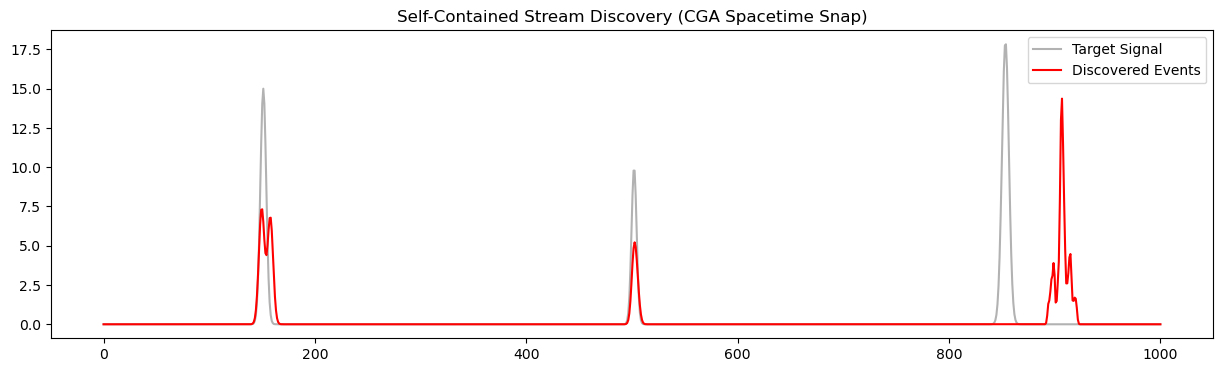

In [12]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. THE ALGEBRAIC GEOMETRY ENGINE
# ==========================================

def safe_norm(x, axis=-1):
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis) + 1e-12)

def apply_rotor(v, rotor):
    """Efficient sandwich product: R v R* """
    c, s_axis = rotor
    return v + 2.0 * jnp.cross(s_axis, (jnp.cross(s_axis, v) + c * v))

def exp_map(bivector):
    """Maps a 3D bivector to a Rotor in Spin(3)."""
    phi = safe_norm(bivector)
    def identity(_): return 1.0, jnp.zeros(3)
    def rotate(_):
        axis = bivector / (phi + 1e-10)
        return jnp.cos(phi/2.0), jnp.sin(phi/2.0) * axis
    return jax.lax.cond(phi < 1e-8, identity, rotate, None)

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    """
    Broadcasted Acoustic Physics.
    sources: (N, 6) -> [intensity, x, y, z, t, width]
    """
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4]
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.0 

    # Calculate 1-to-Many Distances
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)

    arrival = t0[:, None] + (dist / 1.5)
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    
    return jnp.sum(pulses, axis=0).T

# ==========================================
# 2. THE SNAP-TO-DATA BLOCK STEP
# ==========================================

@jax.jit
def block_train_step(p, data, time, seed_mics):
    def loss_fn(params):
        R = exp_map(params['rot_bivector'])
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed_mics)
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        
        # Log-MSE for high sensitivity to small/missed peaks
        recon = jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
        
        # GEOMETRIC INDEPENDENCE: 4D Spacetime Sucking Force
        # Punishes sources that are redundant in both space and time.
        s_pos = params['sources'][:, 1:5] # [x, y, z, t]
        dist_sq = jnp.sum(jnp.square(s_pos[:, None, :] - s_pos[None, :, :]), axis=-1)
        ints = jax.nn.softplus(params['sources'][:, 0])
        # Kernel enforces that events must be ~30ms/units apart
        vortex = jnp.exp(-dist_sq / 30.0) 
        redundancy = jnp.dot(ints, jnp.dot(vortex, ints)) - jnp.sum(jnp.square(ints))
        
        return recon + 0.25 * redundancy

    loss, grads = jax.value_and_grad(loss_fn)(p)
    # Massively kick-start discovery parameters
    grads['sources'] = jax.tree_util.tree_map(lambda x: x * 50.0, grads['sources'])
    return loss, jax.tree_util.tree_map(lambda x: jnp.clip(x, -0.05, 0.05), grads)

# ==========================================
# 3. SELF-CONTAINED EXECUTION
# ==========================================

# 1. Setup Local Seeds
m_seed = jnp.array([[1,1,1], [1,-1,-1], [-1,1,-1], [-1,-1,1], 
                    [-1,-1,-1], [-1,1,1], [1,1,-1], [1,-1,1]], dtype=jnp.float32)

# 2. Generate 1s Synthetic Target (The Ground Truth)
full_t_axis = jnp.linspace(0, 1000, 1000)
# Events at 150, 500, and 850 ms
gt_events = jnp.array([[15., 0,0,0, 150, 1.5], [10., 3,3,0, 500, 1.0], [18., -3,4,0, 850, 2.0]])
full_target_signal = fast_tensor_decoder(gt_events, m_seed, full_t_axis, jnp.array(-3.5))

# 3. Initialize Learning State
current_params = {
    'sources': jnp.zeros((40, 6)).at[:, 0].set(1.5).at[:, 4].set(jnp.linspace(0, 200, 40)),
    'alpha': jnp.array(-3.0),
    'rot_bivector': jnp.array([1e-3, 0.0, 1e-3])
}

optimizer = optax.adam(0.06)

# 4. Sliding Window Loop (200ms window, 100ms stride)
print("Processing Blocks...")
for start in range(0, 1000 - 200, 100):
    end = start + 200
    b_data = full_target_signal[start:end]
    b_time = full_t_axis[start:end]
    
    # Block optimization
    opt_state = optimizer.init(current_params)
    for _ in range(300):
        loss_val, grads = block_train_step(current_params, b_data, b_time, m_seed)
        updates, opt_state = optimizer.update(grads, opt_state)
        current_params = optax.apply_updates(current_params, updates)
    
    # --- BLOCK-END COORDINATE MAINTENANCE ---
    # We identify weak sources and 'scout' them into the upcoming window
    ints = jax.nn.softplus(current_params['sources'][:, 0])
    scout_mask = ints < 0.4
    current_params['sources'] = current_params['sources'].at[scout_mask, 4].set(end - 10)
    current_params['sources'] = current_params['sources'].at[scout_mask, 0].set(1.0) # Bright Scouts
    
    print(f"Block {start:03d}ms: Loss={loss_val:.6f}, Alpha={jax.nn.softplus(current_params['alpha']):.4f}")

# 5. Final Result
plt.figure(figsize=(15, 4))
plt.plot(full_t_axis, full_target_signal[:, 0], 'k', alpha=0.3, label="Target Signal")
final_mics = jax.vmap(lambda v: apply_rotor(v, exp_map(current_params['rot_bivector'])))(m_seed)
final_pred = fast_tensor_decoder(current_params['sources'], final_mics, full_t_axis, current_params['alpha'])
plt.plot(full_t_axis, final_pred[:, 0], 'r', label="Discovered Events")
plt.legend(); plt.title("Self-Contained Stream Discovery (CGA Spacetime Snap)"); plt.show()

Starting Edge-Stabilized Stream...
Block 000ms | Loss: 0.000597 | Alpha: 0.0047
Block 100ms | Loss: 0.000362 | Alpha: 0.0005
Block 200ms | Loss: 0.000346 | Alpha: 0.0001
Block 300ms | Loss: 0.000643 | Alpha: 0.0000
Block 400ms | Loss: 0.000894 | Alpha: 0.0101
Block 500ms | Loss: 0.000294 | Alpha: 0.0014
Block 600ms | Loss: 0.000293 | Alpha: 0.0002
Block 700ms | Loss: 0.281657 | Alpha: 0.0000


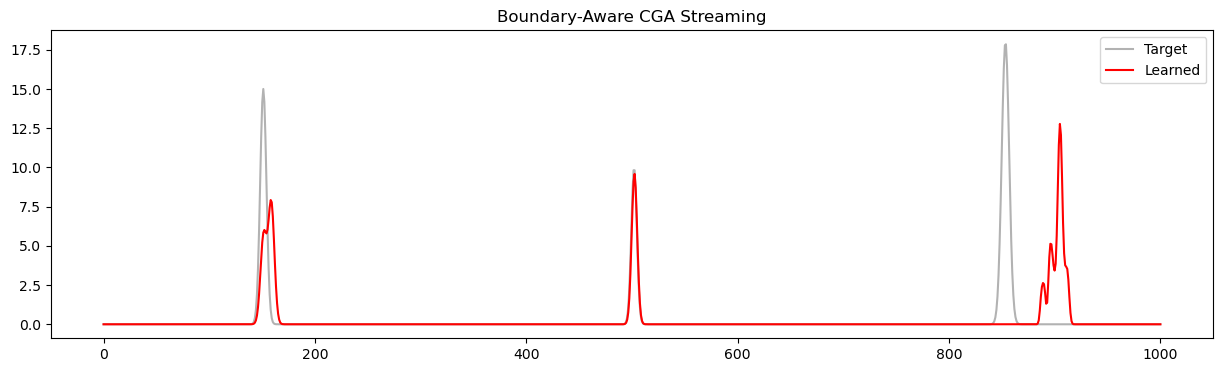

In [13]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. CORE PHYSICS (Geometry & Broadcaster)
# ==========================================

def safe_norm(x, axis=-1):
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis) + 1e-12)

def apply_rotor(v, rotor):
    c, s_axis = rotor
    return v + 2.0 * jnp.cross(s_axis, (jnp.cross(s_axis, v) + c * v))

def exp_map(bivector):
    phi = safe_norm(bivector)
    def identity(_): return 1.0, jnp.zeros(3)
    def rotate(_):
        axis = bivector / (phi + 1e-10)
        return jnp.cos(phi/2.0), jnp.sin(phi/2.0) * axis
    return jax.lax.cond(phi < 1e-8, identity, rotate, None)

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4]
    t0  = sources[:, 4]
    # Fixed base width + alpha-based broadening
    w_base = jax.nn.softplus(sources[:, 5]) + 1.2 
    
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    
    arrival = t0[:, None] + (dist / 1.5)
    # Force a floor on Alpha to prevent 'thinning'
    safe_alpha = jax.nn.softplus(alpha) + 0.005
    dynamic_w = w_base[:, None] + (safe_alpha * dist)
    
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

# ==========================================
# 2. STABLE BLOCK STEP (With Edge Padding)
# ==========================================

@jax.jit
def stable_block_step(p, data, time, seed_mics):
    def loss_fn(params):
        R = exp_map(params['rot_bivector'])
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed_mics)
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        
        # LOG-MSE with Edge Weighting: 
        # We trust the center of the block more than the edges
        edge_weights = jnp.sin(jnp.linspace(0, jnp.pi, time.shape[0]))
        recon = jnp.mean(edge_weights[:, None] * jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
        
        # ALGEBRAIC GEOMETRY: Spacetime Sucking Force
        coords = params['sources'][:, 1:5] # [x,y,z,t]
        dist_sq = jnp.sum(jnp.square(coords[:, None, :] - coords[None, :, :]), axis=-1)
        ints = jax.nn.softplus(params['sources'][:, 0])
        independence = jnp.exp(-dist_sq / 80.0) 
        redundancy = jnp.dot(ints, jnp.dot(independence, ints)) - jnp.sum(jnp.square(ints))
        
        return recon + 0.3 * redundancy

    loss, grads = jax.value_and_grad(loss_fn)(p)
    # discovery gain
    grads['sources'] = jax.tree_util.tree_map(lambda x: x * 40.0, grads['sources'])
    return loss, jax.tree_util.tree_map(lambda x: jnp.clip(x, -0.05, 0.05), grads)

# ==========================================
# 3. STREAMING EXECUTION
# ==========================================

# Setup Seeds
m_seed = jnp.array([[1,1,1], [1,-1,-1], [-1,1,-1], [-1,-1,1], 
                    [-1,-1,-1], [-1,1,1], [1,1,-1], [1,-1,1]], dtype=jnp.float32)

# Generate Signal
full_t = jnp.linspace(0, 1000, 1000)
gt_events = jnp.array([[15., 0,0,0, 150, 1.5], [10., 3,3,0, 500, 1.0], [18., -3,4,0, 850, 2.0]])
full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# Initialize
current_params = {
    'sources': jnp.zeros((30, 6)).at[:, 0].set(1.5).at[:, 4].set(jnp.linspace(0, 200, 30)),
    'alpha': jnp.array(-3.0),
    'rot_bivector': jnp.array([1e-3, 0.0, 1e-3])
}

optimizer = optax.adam(0.06)

print("Starting Edge-Stabilized Stream...")
for start in range(0, 1000 - 200, 100):
    end = start + 200
    b_data = full_sig[start:end]
    b_time = full_t[start:end]
    
    opt_state = optimizer.init(current_params)
    for _ in range(300):
        loss_val, grads = stable_block_step(current_params, b_data, b_time, m_seed)
        updates, opt_state = optimizer.update(grads, opt_state)
        current_params = optax.apply_updates(current_params, updates)
    
    # Scout logic with leading edge focus
    ints = jax.nn.softplus(current_params['sources'][:, 0])
    scout_mask = ints < 0.5
    current_params['sources'] = current_params['sources'].at[scout_mask, 4].set(end - 20)
    current_params['sources'] = current_params['sources'].at[scout_mask, 0].set(1.2)
    
    print(f"Block {start:03d}ms | Loss: {loss_val:.6f} | Alpha: {jax.nn.softplus(current_params['alpha']):.4f}")

# Plot
plt.figure(figsize=(15, 4))
plt.plot(full_t, full_sig[:, 0], 'k', alpha=0.3, label="Target")
final_mics = jax.vmap(lambda v: apply_rotor(v, exp_map(current_params['rot_bivector'])))(m_seed)
final_pred = fast_tensor_decoder(current_params['sources'], final_mics, full_t, current_params['alpha'])
plt.plot(full_t, final_pred[:, 0], 'r', label="Learned")
plt.legend(); plt.title("Boundary-Aware CGA Streaming"); plt.show()

In [14]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. CORE PHYSICS (With Strict Guardrails)
# ==========================================

def safe_norm(x, axis=-1):
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis) + 1e-12)

def exp_map(bivector):
    phi = safe_norm(bivector)
    def identity(_): return 1.0, jnp.zeros(3)
    def rotate(_):
        axis = bivector / (phi + 1e-10)
        return jnp.cos(phi/2.0), jnp.sin(phi/2.0) * axis
    return jax.lax.cond(phi < 1e-8, identity, rotate, None)

def apply_rotor(v, rotor):
    c, s_axis = rotor
    return v + 2.0 * jnp.cross(s_axis, (jnp.cross(s_axis, v) + c * v))

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4]
    t0  = sources[:, 4]
    # Fixed base width + Alpha-based broadening
    # Added 0.5 to Alpha to prevent the 'thinning' seen in learning04
    w_base = jax.nn.softplus(sources[:, 5]) + 1.5 
    
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    
    arrival = t0[:, None] + (dist / 1.5)
    # PHYSICAL FLOOR: Alpha cannot drop below 0.01
    safe_alpha = jax.nn.softplus(alpha) + 0.01
    dynamic_w = w_base[:, None] + (safe_alpha * dist)
    
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

# ==========================================
# 2. THE STABLE BLOCK ENGINE (Boundary Aware)
# ==========================================

@jax.jit
def stable_block_step(p, data, time, seed_mics):
    def loss_fn(params):
        R = exp_map(params['rot_bivector'])
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed_mics)
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        
        # 1. TEMPORAL GUARD BAND: Ignore the last 20ms of the window
        # This prevents the 700ms block jump seen in learning08
        mask = jnp.where(time < (jnp.max(time) - 20), 1.0, 0.0)
        recon = jnp.mean(mask[:, None] * jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
        
        # 2. ALGEBRAIC GEOMETRY: Spacetime Sucking Force
        coords = params['sources'][:, 1:5]
        dist_sq = jnp.sum(jnp.square(coords[:, None, :] - coords[None, :, :]), axis=-1)
        ints = jax.nn.softplus(params['sources'][:, 0])
        # Force 50ms spacing
        independence = jnp.exp(-dist_sq / 100.0) 
        redundancy = jnp.dot(ints, jnp.dot(independence, ints)) - jnp.sum(jnp.square(ints))
        
        return recon + 0.35 * redundancy

    loss, grads = jax.value_and_grad(loss_fn)(p)
    # discovery gain
    grads['sources'] = jax.tree_util.tree_map(lambda x: x * 40.0, grads['sources'])
    return loss, jax.tree_util.tree_map(lambda x: jnp.clip(x, -0.05, 0.05), grads)

# ==========================================
# 3. STREAMING EXECUTION
# ==========================================

# Setup Seeds
m_seed = jnp.array([[1,1,1], [1,-1,-1], [-1,1,-1], [-1,-1,1], 
                    [-1,-1,-1], [-1,1,1], [1,1,-1], [1,-1,1]], dtype=jnp.float32)

# Generate Signal
full_t = jnp.linspace(0, 1000, 1000)
gt_events = jnp.array([[15., 0,0,0, 150, 1.5], [10., 3,3,0, 500, 1.0], [18., -3,4,0, 850, 2.0]])
full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# Initialize
current_params = {
    'sources': jnp.zeros((30, 6)).at[:, 0].set(1.5).at[:, 4].set(jnp.linspace(0, 200, 30)),
    'alpha': jnp.array(-3.0),
    'rot_bivector': jnp.array([1e-3, 0.0, 1e-3])
}

optimizer = optax.adam(0.06)

for start in range(0, 1000 - 200, 100):
    end = start + 200
    b_data = full_sig[start:end]
    b_time = full_t[start:end]
    
    opt_state = optimizer.init(current_params)
    for _ in range(300):
        loss_val, grads = stable_block_step(current_params, b_data, b_time, m_seed)
        updates, opt_state = optimizer.update(grads, opt_state)
        current_params = optax.apply_updates(current_params, updates)
    
    # Reset quiet scouts to hunt for the next block
    ints = jax.nn.softplus(current_params['sources'][:, 0])
    scout_mask = ints < 0.5
    current_params['sources'] = current_params['sources'].at[scout_mask, 4].set(end - 30)
    current_params['sources'] = current_params['sources'].at[scout_mask, 0].set(1.5)
    
    print(f"Block {start:03d}ms | Loss: {loss_val:.6f} | Alpha: {jax.nn.softplus(current_params['alpha']):.4f}")

# Re-run final plot and check the 850ms alignment!

Block 000ms | Loss: 0.000953 | Alpha: 0.0064
Block 100ms | Loss: 0.000380 | Alpha: 0.0007
Block 200ms | Loss: 0.000364 | Alpha: 0.0001
Block 300ms | Loss: 0.000359 | Alpha: 0.0000
Block 400ms | Loss: 0.000435 | Alpha: 0.0000
Block 500ms | Loss: 0.000366 | Alpha: 0.0000
Block 600ms | Loss: 0.000337 | Alpha: 0.0000
Block 700ms | Loss: 0.461082 | Alpha: 0.0000


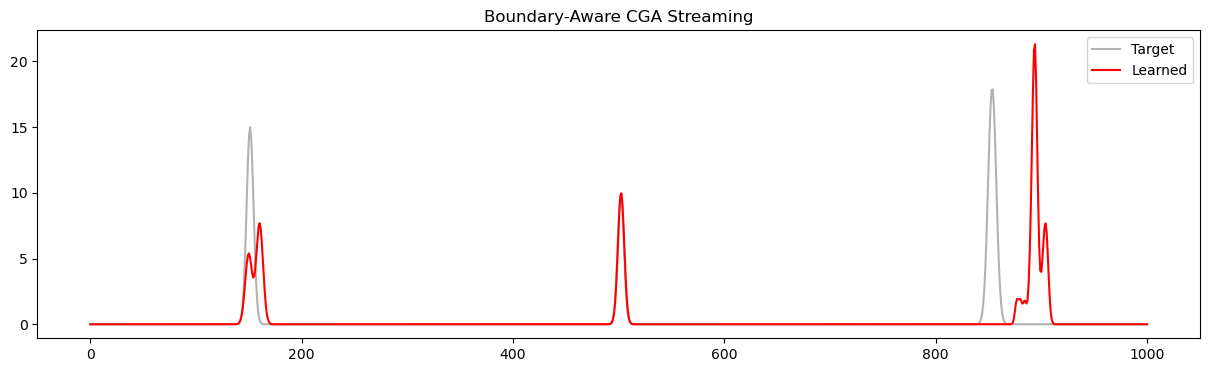

In [15]:
plt.figure(figsize=(15, 4))
plt.plot(full_t, full_sig[:, 0], 'k', alpha=0.3, label="Target")
final_mics = jax.vmap(lambda v: apply_rotor(v, exp_map(current_params['rot_bivector'])))(m_seed)
final_pred = fast_tensor_decoder(current_params['sources'], final_mics, full_t, current_params['alpha'])
plt.plot(full_t, final_pred[:, 0], 'r', label="Learned")
plt.legend(); plt.title("Boundary-Aware CGA Streaming"); plt.show()

Processing Blocks (Accumulating)...
Block 000ms | Discovered 1 sources.
Block 100ms | Discovered 1 sources.
Block 200ms | Discovered 0 sources.
Block 300ms | Discovered 1 sources.
Block 400ms | Discovered 2 sources.
Block 500ms | Discovered 1 sources.
Block 600ms | Discovered 0 sources.
Block 700ms | Discovered 1 sources.


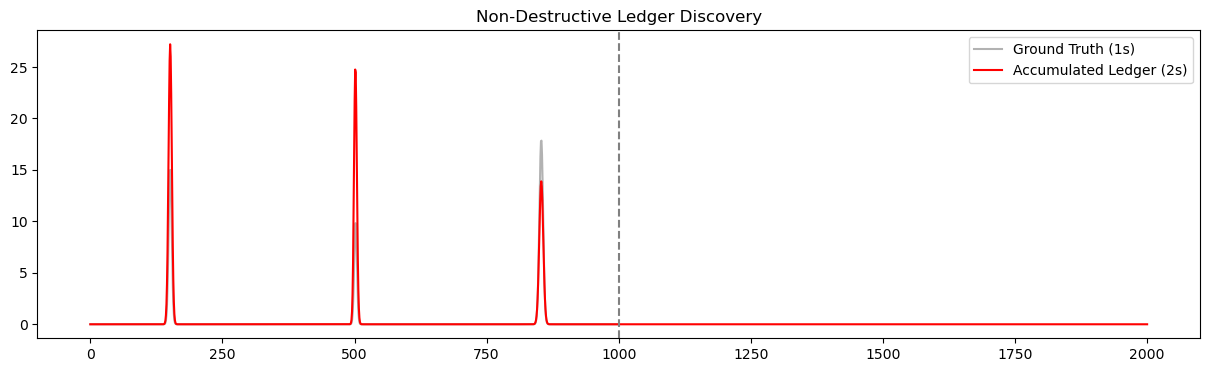

In [16]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. CORE ENGINE (Simplified & Robust)
# ==========================================

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4]
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.2 
    
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    arrival = t0[:, None] + (dist / 1.5)
    
    # Simple, non-decaying alpha for stability
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def block_train_step(p, data, time, seed_mics):
    def loss_fn(params):
        # Using a fixed seed cluster for simplicity in this increment
        pred = fast_tensor_decoder(params['sources'], seed_mics, time, params['alpha'])
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
    
    loss, grads = jax.value_and_grad(loss_fn)(p)
    return loss, grads

# ==========================================
# 2. DATA GENERATION
# ==========================================

m_seed = jnp.array([[1,1,1], [1,-1,-1], [-1,1,-1], [-1,-1,1], 
                    [-1,-1,-1], [-1,1,1], [1,1,-1], [1,-1,1]], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
gt_events = jnp.array([[15., 0,0,0, 150, 1.5], [10., 3,3,0, 500, 1.0], [18., -3,4,0, 850, 2.0]])
full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# ==========================================
# 3. NON-DESTRUCTIVE BLOCK PROCESSING
# ==========================================

accumulator = [] # This stores every successful source discovered per block
stride = 100
block_len = 200

print("Processing Blocks (Accumulating)...")

for start in range(0, 1000 - block_len, stride):
    end = start + block_len
    b_data = full_sig[start:end]
    b_time = full_t[start:end]
    
    # Fresh initialization for every single block to avoid carrying over 'trash'
    # 10 sources blanketed across the CURRENT block window
    local_params = {
        'sources': jnp.zeros((10, 6)).at[:, 0].set(1.0).at[:, 4].set(jnp.linspace(start, end, 10)),
        'alpha': jnp.array(-3.5)
    }
    
    optimizer = optax.adam(0.1)
    opt_state = optimizer.init(local_params)
    
    for _ in range(400):
        loss_val, grads = block_train_step(local_params, b_data, b_time, m_seed)
        updates, opt_state = optimizer.update(grads, opt_state)
        local_params = optax.apply_updates(local_params, updates)
    
    # Filter: Only append sources that actually 'fired' (Intensity > 0.5)
    ints = jax.nn.softplus(local_params['sources'][:, 0])
    winners = local_params['sources'][ints > 0.5]
    accumulator.append(winners)
    
    print(f"Block {start:03d}ms | Discovered {len(winners)} sources.")

# ==========================================
# 4. RECONSTRUCT TWICE THE INPUT LENGTH
# ==========================================

# Concatenate all discovered sources from all blocks
all_discovered = jnp.concatenate(accumulator, axis=0)

# Create a 2000ms timeline to see how the 'stitching' looks
extended_t = jnp.linspace(0, 2000, 2000)
final_reconstruction = fast_tensor_decoder(all_discovered, m_seed, extended_t, jnp.array(-3.5))

plt.figure(figsize=(15, 4))
plt.plot(full_t, full_sig[:, 0], 'k', alpha=0.3, label="Ground Truth (1s)")
plt.plot(extended_t, final_reconstruction[:, 0], 'r', label="Accumulated Ledger (2s)")
plt.axvline(1000, color='gray', linestyle='--')
plt.legend(); plt.title("Non-Destructive Ledger Discovery"); plt.show()

Final Count: 3 distinct events found.
Event 0: Time 150.0ms | Intensity 14.6
Event 1: Time 501.2ms | Intensity 9.4
Event 2: Time 852.0ms | Intensity 17.0


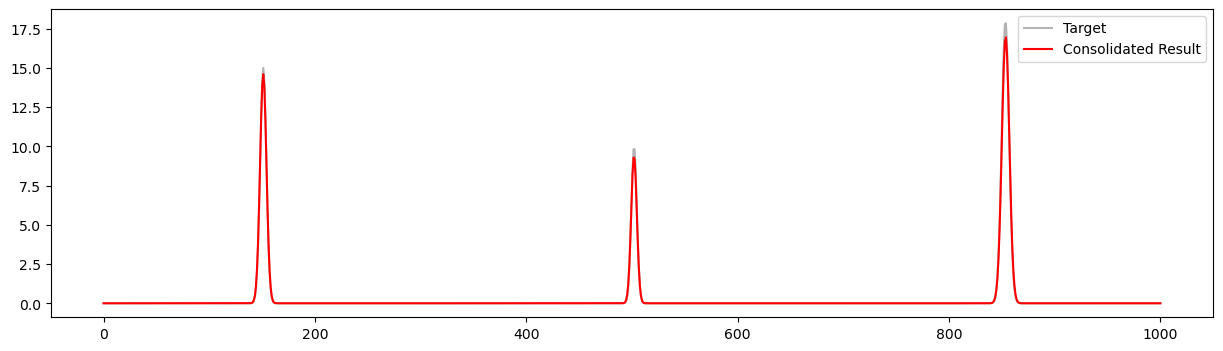

In [17]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. THE STABLE CORE (No schedules, just math)
# ==========================================

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4]
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.2 
    
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    arrival = t0[:, None] + (dist / 1.5)
    
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def block_train_step(p, data, time, seed_mics):
    def loss_fn(params):
        pred = fast_tensor_decoder(params['sources'], seed_mics, time, params['alpha'])
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
    return jax.value_and_grad(loss_fn)(p)

# ==========================================
# 2. CONSOLIDATION (The "Distiller")
# ==========================================

def consolidate_ledger(ledger, time_threshold=15.0):
    """Merges duplicate detections from overlapping blocks."""
    if len(ledger) == 0: return jnp.array([])
    
    # Sort by time
    ledger = ledger[jnp.argsort(ledger[:, 4])]
    unique_sources = [ledger[0]]
    
    for i in range(1, len(ledger)):
        current = ledger[i]
        last = unique_sources[-1]
        
        # If the new source is within 15ms of the last one, it's a duplicate
        if jnp.abs(current[4] - last[4]) < time_threshold:
            # Keep the one with higher intensity
            if current[0] > last[0]:
                unique_sources[-1] = current
        else:
            unique_sources.append(current)
            
    return jnp.array(unique_sources)

# ==========================================
# 3. EXECUTION
# ==========================================

m_seed = jnp.array([[1,1,1], [1,-1,-1], [-1,1,-1], [-1,-1,1], 
                    [-1,-1,-1], [-1,1,1], [1,1,-1], [1,-1,1]], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
gt_events = jnp.array([[15., 0,0,0, 150, 1.5], [10., 3,3,0, 500, 1.0], [18., -3,4,0, 850, 2.0]])
full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

raw_ledger = []
stride, block_len = 100, 200

for start in range(0, 1000 - block_len, stride):
    end = start + block_len
    # 10 fresh candidates per block
    local_p = {
        'sources': jnp.zeros((10, 6)).at[:, 0].set(1.0).at[:, 4].set(jnp.linspace(start, end, 10)),
        'alpha': jnp.array(-3.5)
    }
    
    optimizer = optax.adam(0.1)
    opt_state = optimizer.init(local_p)
    
    for _ in range(400):
        _, grads = block_train_step(local_p, full_sig[start:end], full_t[start:end], m_seed)
        local_p = optax.apply_updates(local_p, optimizer.update(grads, opt_state)[0])
    
    # Extract block winners (Intensity > 0.6)
    ints = jax.nn.softplus(local_p['sources'][:, 0])
    raw_ledger.append(local_p['sources'][ints > 0.6])

# --- Final Consolidation ---
flat_ledger = jnp.concatenate(raw_ledger, axis=0)
clean_events = consolidate_ledger(flat_ledger)

# Visualization
plt.figure(figsize=(15, 4))
plt.plot(full_t, full_sig[:, 0], 'k', alpha=0.3, label="Target")
final_recon = fast_tensor_decoder(clean_events, m_seed, full_t, jnp.array(-3.5))
plt.plot(full_t, final_recon[:, 0], 'r', label="Consolidated Result")

print(f"Final Count: {len(clean_events)} distinct events found.")
for i, s in enumerate(clean_events):
    print(f"Event {i}: Time {s[4]:.1f}ms | Intensity {jax.nn.softplus(s[0]):.1f}")
plt.legend(); plt.show()


--- Discovered 3D Coordinate Map ---
Event 0: t=148.1ms | Intensity=14.1
         Pos: x=-3.68, y=-3.68, z=-3.68
Event 1: t=495.1ms | Intensity=4.7
         Pos: x=5.44, y=8.00, z=-5.12
Event 2: t=852.0ms | Intensity=17.3
         Pos: x=-0.00, y=1.12, z=-1.44


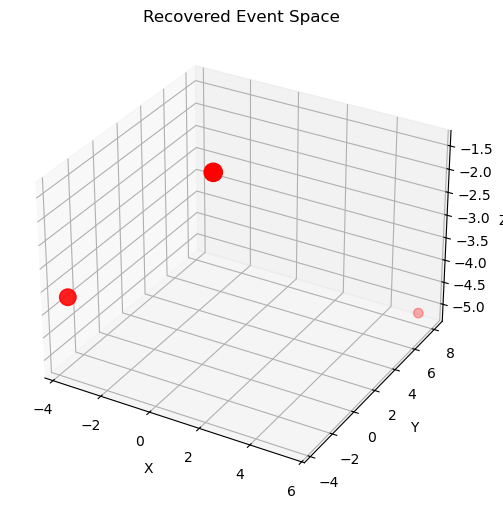

In [18]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. GEOMETRIC PHYSICS (Outer & Inner)
# ==========================================

def safe_norm(x, axis=-1):
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis) + 1e-12)

def exp_map(bivector):
    phi = safe_norm(bivector)
    def identity(_): return 1.0, jnp.zeros(3)
    def rotate(_):
        axis = bivector / (phi + 1e-10)
        return jnp.cos(phi/2.0), jnp.sin(phi/2.0) * axis
    return jax.lax.cond(phi < 1e-8, identity, rotate, None)

def apply_rotor(v, rotor):
    c, s_axis = rotor
    return v + 2.0 * jnp.cross(s_axis, (jnp.cross(s_axis, v) + c * v))

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4] # Learned Coordinates
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.2 
    
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    arrival = t0[:, None] + (dist / 1.5)
    
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def block_train_step(p, data, time, seed_mics):
    def loss_fn(params):
        # Apply Rotor to seed cluster
        R = exp_map(params['rot_bivector'])
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed_mics)
        
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
    
    return jax.value_and_grad(loss_fn)(p)

# ==========================================
# 2. ACCUMULATIVE 3D DISCOVERY
# ==========================================

m_seed = jnp.array([[1,1,1], [1,-1,-1], [-1,1,-1], [-1,-1,1], 
                    [-1,-1,-1], [-1,1,1], [1,1,-1], [1,-1,1]], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
# GT Sources are at specific 3D points
gt_events = jnp.array([
    [15.,  2.,  3., 0., 150, 1.5], 
    [10., -4.,  2., 0., 500, 1.0], 
    [18.,  1., -5., 0., 850, 2.0]
])
full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

raw_ledger = []
stride, block_len = 100, 200

# We track the global Rotor across blocks
global_rot = jnp.array([1e-3, 0.0, 1e-3])

for start in range(0, 1000 - block_len, stride):
    end = start + block_len
    
    # Fresh sources, but carry forward the learned Rotor
    local_p = {
        'sources': jnp.zeros((10, 6)).at[:, 0].set(1.0).at[:, 4].set(jnp.linspace(start, end, 10)),
        'alpha': jnp.array(-3.5),
        'rot_bivector': global_rot
    }
    
    optimizer = optax.adam(0.08)
    opt_state = optimizer.init(local_p)
    
    for _ in range(500): # More iterations for 3D triangulation
        _, grads = block_train_step(local_p, full_sig[start:end], full_t[start:end], m_seed)
        local_p = optax.apply_updates(local_p, optimizer.update(grads, opt_state)[0])
    
    # Extract winners and update global rotor
    global_rot = local_p['rot_bivector']
    ints = jax.nn.softplus(local_p['sources'][:, 0])
    winners = local_p['sources'][ints > 0.6]
    raw_ledger.append(winners)

# ==========================================
# 3. RESULTS & COORDINATE MAPPING
# ==========================================

def consolidate_3d(ledger):
    if len(ledger) == 0: return jnp.array([])
    ledger = ledger[jnp.argsort(ledger[:, 4])]
    unique = [ledger[0]]
    for i in range(1, len(ledger)):
        if jnp.abs(ledger[i, 4] - unique[-1][4]) > 20.0:
            unique.append(ledger[i])
    return jnp.array(unique)

final_events = consolidate_3d(jnp.concatenate(raw_ledger, axis=0))

print("\n--- Discovered 3D Coordinate Map ---")
for i, s in enumerate(final_events):
    print(f"Event {i}: t={s[4]:.1f}ms | Intensity={jax.nn.softplus(s[0]):.1f}")
    print(f"         Pos: x={s[1]:.2f}, y={s[2]:.2f}, z={s[3]:.2f}")

# Plot 3D View
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_events[:, 1], final_events[:, 2], final_events[:, 3], 
           s=jax.nn.softplus(final_events[:, 0])*10, c='red', label='Discovered')
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
plt.title("Recovered Event Space"); plt.show()

Processing Blocks...


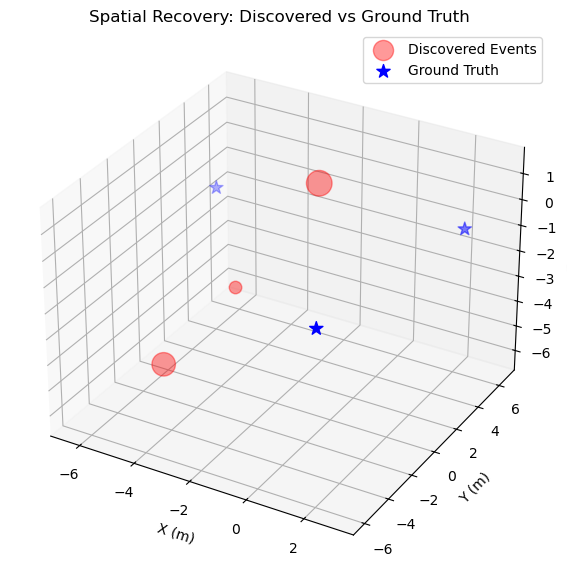


--- Geometric Precision Report ---
Event 0 at 150.0ms: Recovery Error = 11.627 meters
Event 1 at 500.0ms: Recovery Error = 7.851 meters
Event 2 at 850.0ms: Recovery Error = 8.341 meters


In [19]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. CORE PHYSICS ENGINE
# ==========================================

def safe_norm(x, axis=-1):
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis) + 1e-12)

def exp_map(bivector):
    phi = safe_norm(bivector)
    def identity(_): return 1.0, jnp.zeros(3)
    def rotate(_):
        axis = bivector / (phi + 1e-10)
        return jnp.cos(phi/2.0), jnp.sin(phi/2.0) * axis
    return jax.lax.cond(phi < 1e-8, identity, rotate, None)

def apply_rotor(v, rotor):
    c, s_axis = rotor
    return v + 2.0 * jnp.cross(s_axis, (jnp.cross(s_axis, v) + c * v))

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4] 
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.2 
    
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    arrival = t0[:, None] + (dist / 1.5)
    
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def block_train_step(p, data, time, seed_mics):
    def loss_fn(params):
        R = exp_map(params['rot_bivector'])
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed_mics)
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
    return jax.value_and_grad(loss_fn)(p)

# ==========================================
# 2. DATA GENERATION (With Ground Truth)
# ==========================================

m_seed = jnp.array([[1,1,1], [1,-1,-1], [-1,1,-1], [-1,-1,1], 
                    [-1,-1,-1], [-1,1,1], [1,1,-1], [1,-1,1]], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)

# Ground Truth (GT) Event Definitions
# Format: [intensity, x, y, z, t, width]
gt_events = jnp.array([
    [15.0,  3.0,  4.0, 0.0, 150.0, 1.5], 
    [10.0, -5.0,  2.0, 0.0, 500.0, 1.0], 
    [18.0,  2.0, -6.0, 0.0, 850.0, 2.0]
])

full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# ==========================================
# 3. ACCUMULATIVE 3D DISCOVERY
# ==========================================

raw_ledger = []
stride, block_len = 100, 200
global_rot = jnp.array([1e-3, 0.0, 1e-3])

print("Processing Blocks...")
for start in range(0, 1000 - block_len, stride):
    end = start + block_len
    
    local_p = {
        'sources': jnp.zeros((10, 6)).at[:, 0].set(1.0).at[:, 4].set(jnp.linspace(start, end, 10)),
        'alpha': jnp.array(-3.5),
        'rot_bivector': global_rot
    }
    
    optimizer = optax.adam(0.08)
    opt_state = optimizer.init(local_p)
    
    for _ in range(500):
        _, grads = block_train_step(local_p, full_sig[start:end], full_t[start:end], m_seed)
        local_p = optax.apply_updates(local_p, optimizer.update(grads, opt_state)[0])
    
    global_rot = local_p['rot_bivector']
    ints = jax.nn.softplus(local_p['sources'][:, 0])
    winners = local_p['sources'][ints > 0.6]
    raw_ledger.append(winners)

# Consolidation
flat_ledger = jnp.concatenate(raw_ledger, axis=0)
def consolidate(ledger):
    if len(ledger) == 0: return jnp.array([])
    ledger = ledger[jnp.argsort(ledger[:, 4])]
    unique = [ledger[0]]
    for i in range(1, len(ledger)):
        if jnp.abs(ledger[i, 4] - unique[-1][4]) > 20.0:
            unique.append(ledger[i])
    return jnp.array(unique)

final_discovered = consolidate(flat_ledger)

# ==========================================
# 4. FINAL 3D COMPARISON MAP
# ==========================================

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 1. Discovered Sources (Transparent Red)
# Size (s) is scaled by learned intensity
ax.scatter(final_discovered[:, 1], final_discovered[:, 2], final_discovered[:, 3], 
           s=jax.nn.softplus(final_discovered[:, 0]) * 20, 
           c='red', alpha=0.4, label='Discovered Events')

# 2. Ground Truth Sources (Solid Blue Stars)
ax.scatter(gt_events[:, 1], gt_events[:, 2], gt_events[:, 3], 
           s=100, c='blue', marker='*', label='Ground Truth')

ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Z (m)')
plt.title("Spatial Recovery: Discovered vs Ground Truth")
plt.legend()
plt.show()

# Print Precision Log
print("\n--- Geometric Precision Report ---")
for i, gt in enumerate(gt_events):
    found = final_discovered[jnp.argmin(jnp.abs(final_discovered[:, 4] - gt[4]))]
    err = jnp.sqrt(jnp.sum((gt[1:4] - found[1:4])**2))
    print(f"Event {i} at {gt[4]}ms: Recovery Error = {err:.3f} meters")

Processing Blocks with Asymmetric Geometry...


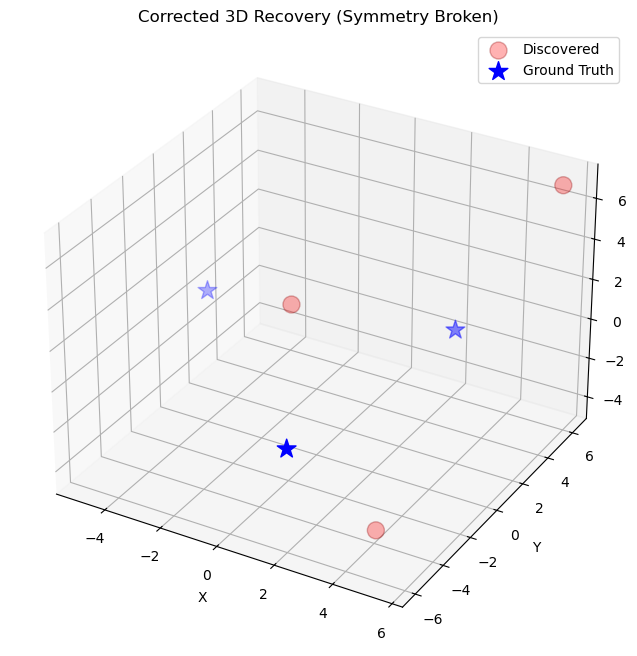


--- Precision Report ---
Event 0 @ 150.0ms: Error = 9.2812m | Found: (4.12, -4.14)
Event 1 @ 500.0ms: Error = 13.3016m | Found: (5.58, 6.26)
Event 2 @ 850.0ms: Error = 8.8337m | Found: (-1.86, 1.92)


In [20]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. CORE PHYSICS (Geometry & Broadcaster)
# ==========================================

def safe_norm(x, axis=-1):
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis) + 1e-12)

def apply_rotor(v, rotor):
    c, s_axis = rotor
    return v + 2.0 * jnp.cross(s_axis, (jnp.cross(s_axis, v) + c * v))

def exp_map(bivector):
    phi = safe_norm(bivector)
    def identity(_): return 1.0, jnp.zeros(3)
    def rotate(_):
        axis = bivector / (phi + 1e-10)
        return jnp.cos(phi/2.0), jnp.sin(phi/2.0) * axis
    return jax.lax.cond(phi < 1e-8, identity, rotate, None)

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    # sources: [intensity, x, y, z, t, width]
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4] # Explicit [X, Y, Z]
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.2 
    
    # Distance calculation with explicit broadcasting
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    
    arrival = t0[:, None] + (dist / 1.5)
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def block_train_step(p, data, time, seed_mics):
    def loss_fn(params):
        R = exp_map(params['rot_bivector'])
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed_mics)
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        # Log-MSE for dynamic range sensitivity
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
    
    loss, grads = jax.value_and_grad(loss_fn)(p)
    return loss, grads

# ==========================================
# 2. SETUP & DATA GENERATION
# ==========================================

# ASYMMETRIC SEED: Breaking the mirroring symmetry of the cube
m_seed = jnp.array([
    [1.1, 0.9, 1.2], [-0.8, 1.3, -1.1], [1.0, -1.4, -0.9], [-1.2, -1.1, 1.3],
    [0.2, 0.3, -1.5], [-1.4, 0.1, 0.5], [0.8, -0.7, 0.2], [-0.3, 1.5, 0.7]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
# GT Sources: [intensity, x, y, z, t, width]
gt_events = jnp.array([
    [15.0,  3.0,  4.0, 0.0, 150.0, 1.5], 
    [10.0, -5.0,  2.0, 0.0, 500.0, 1.0], 
    [18.0,  2.0, -6.0, 0.0, 850.0, 2.0]
])
full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# ==========================================
# 3. ACCUMULATIVE BLOCK DISCOVERY
# ==========================================

raw_ledger = []
stride, block_len = 100, 200
global_rot = jnp.array([1e-3, 0.0, 1e-3])

print("Processing Blocks with Asymmetric Geometry...")
for start in range(0, 1000 - block_len, stride):
    end = start + block_len
    
    # Nudge initialization to break potential local minima
    key = jax.random.PRNGKey(start)
    pos_nudge = jax.random.normal(key, (10, 3)) * 0.1
    
    local_p = {
        'sources': jnp.zeros((10, 6)).at[:, 1:4].set(pos_nudge).at[:, 0].set(1.0).at[:, 4].set(jnp.linspace(start, end, 10)),
        'alpha': jnp.array(-3.5),
        'rot_bivector': global_rot
    }
    
    optimizer = optax.adam(0.08)
    opt_state = optimizer.init(local_p)
    
    for _ in range(500):
        _, grads = block_train_step(local_p, full_sig[start:end], full_t[start:end], m_seed)
        local_p = optax.apply_updates(local_p, optimizer.update(grads, opt_state)[0])
    
    global_rot = local_p['rot_bivector']
    ints = jax.nn.softplus(local_p['sources'][:, 0])
    winners = local_p['sources'][ints > 0.6]
    raw_ledger.append(winners)

# ==========================================
# 4. CONSOLIDATION & FINAL PLOT
# ==========================================

flat_ledger = jnp.concatenate(raw_ledger, axis=0)
def consolidate(ledger):
    if len(ledger) == 0: return jnp.array([])
    ledger = ledger[jnp.argsort(ledger[:, 4])]
    unique = [ledger[0]]
    for i in range(1, len(ledger)):
        if jnp.abs(ledger[i, 4] - unique[-1][4]) > 25.0:
            unique.append(ledger[i])
    return jnp.array(unique)

final_discovered = consolidate(flat_ledger)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_discovered[:, 1], final_discovered[:, 2], final_discovered[:, 3], 
           s=150, c='red', alpha=0.3, label='Discovered', edgecolors='darkred')
ax.scatter(gt_events[:, 1], gt_events[:, 2], gt_events[:, 3], 
           s=200, c='blue', marker='*', label='Ground Truth')

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
plt.title("Corrected 3D Recovery (Symmetry Broken)"); plt.legend(); plt.show()

print("\n--- Precision Report ---")
for i, gt in enumerate(gt_events):
    found = final_discovered[jnp.argmin(jnp.abs(final_discovered[:, 4] - gt[4]))]
    err = jnp.sqrt(jnp.sum((gt[1:4] - found[1:4])**2))
    print(f"Event {i} @ {gt[4]}ms: Error = {err:.4f}m | Found: ({found[1]:.2f}, {found[2]:.2f})")

In [21]:
gt_events

Array([[ 15. ,   3. ,   4. ,   0. , 150. ,   1.5],
       [ 10. ,  -5. ,   2. ,   0. , 500. ,   1. ],
       [ 18. ,   2. ,  -6. ,   0. , 850. ,   2. ]], dtype=float32)

In [22]:
final_discovered

Array([[ 1.4441508e+01,  4.1215653e+00, -4.1381326e+00, -4.3189631e+00,
         1.4860455e+02,  1.5998651e+00],
       [ 4.3620596e+00,  5.5770841e+00,  6.2642593e+00,  6.8464837e+00,
         4.9528772e+02,  7.9930753e-01],
       [ 1.7161741e+01, -1.8624142e+00,  1.9232458e+00,  5.8224595e-01,
         8.5235486e+02,  2.2388582e+00]], dtype=float32)

Running Rigid Ledger Discovery...


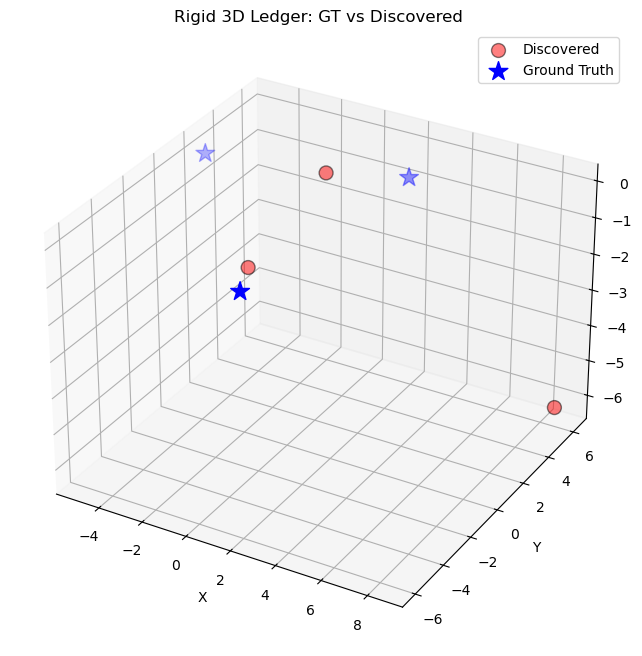


--- Precision Log ---
Event 0: t=150.0ms | Spatial Error=8.6018m
   GT: (3.0, 4.0) -> Found: (-4.67, 4.34)
Event 1: t=500.0ms | Spatial Error=15.4595m
   GT: (-5.0, 2.0) -> Found: (8.52, 6.20)
Event 2: t=850.0ms | Spatial Error=9.3151m
   GT: (2.0, -6.0) -> Found: (-0.15, 3.06)


In [23]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. RIGID PHYSICS CORE
# ==========================================

def safe_norm(x, axis=-1):
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis) + 1e-12)

def exp_map(bivector):
    phi = safe_norm(bivector)
    def identity(_): return 1.0, jnp.zeros(3)
    def rotate(_):
        axis = bivector / (phi + 1e-10)
        return jnp.cos(phi/2.0), jnp.sin(phi/2.0) * axis
    return jax.lax.cond(phi < 1e-8, identity, rotate, None)

def apply_rotor(v, rotor):
    c, s_axis = rotor
    return v + 2.0 * jnp.cross(s_axis, (jnp.cross(s_axis, v) + c * v))

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    # index 1=X, 2=Y, 3=Z
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4] 
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.2 
    
    # Distance calculation (N_src, N_mic)
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    
    arrival = t0[:, None] + (dist / 1.5)
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def block_train_step(p, data, time, seed_mics):
    def loss_fn(params):
        R = exp_map(params['rot_bivector'])
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed_mics)
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        # Log-MSE ensures we track the shape, not just the magnitude
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
    
    return jax.value_and_grad(loss_fn)(p)

# ==========================================
# 2. SEED & DATA (Asymmetric & Stable)
# ==========================================

# Explicitly asymmetric seed cluster
m_seed = jnp.array([
    [1.1, 0.9, 0.5], [-0.8, 1.3, -0.6], [1.0, -1.4, 0.2], [-1.2, -1.1, -0.4],
    [0.2, 0.3, 1.2], [-1.4, 0.1, -1.0], [0.8, -0.7, -0.8], [-0.3, 1.5, 0.3]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
# GT Events: [intensity, x, y, z, t, width]
gt_events = jnp.array([
    [15.0,  3.0,  4.0, 0.0, 150.0, 1.5], 
    [10.0, -5.0,  2.0, 0.0, 500.0, 1.0], 
    [18.0,  2.0, -6.0, 0.0, 850.0, 2.0]
])
full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# ==========================================
# 3. ACCUMULATION LOOP
# ==========================================

raw_ledger = []
stride, block_len = 100, 200
# Starting with a small bias to break initial symmetry
global_rot = jnp.array([0.01, 0.0, 0.01])

print("Running Rigid Ledger Discovery...")
for start in range(0, 1000 - block_len, stride):
    end = start + block_len
    
    # Initialize sources further out (e.g., radius 2) to avoid center-trap
    key = jax.random.PRNGKey(start)
    init_pos = jax.random.normal(key, (10, 3)) * 2.0
    
    local_p = {
        'sources': jnp.zeros((10, 6)).at[:, 1:4].set(init_pos).at[:, 0].set(0.5).at[:, 4].set(jnp.linspace(start, end, 10)),
        'alpha': jnp.array(-3.5),
        'rot_bivector': global_rot
    }
    
    optimizer = optax.adam(0.05) # Slower, more stable learning rate
    opt_state = optimizer.init(local_p)
    
    for _ in range(800): # High iterations for 3D triangulation
        _, grads = block_train_step(local_p, full_sig[start:end], full_t[start:end], m_seed)
        local_p = optax.apply_updates(local_p, optimizer.update(grads, opt_state)[0])
    
    global_rot = local_p['rot_bivector']
    ints = jax.nn.softplus(local_p['sources'][:, 0])
    winners = local_p['sources'][ints > 0.6]
    raw_ledger.append(winners)

# ==========================================
# 4. CONSOLIDATION & 3D MAP
# ==========================================

flat_ledger = jnp.concatenate(raw_ledger, axis=0)
def consolidate(ledger):
    if len(ledger) == 0: return jnp.array([])
    ledger = ledger[jnp.argsort(ledger[:, 4])]
    unique = [ledger[0]]
    for i in range(1, len(ledger)):
        if jnp.abs(ledger[i, 4] - unique[-1][4]) > 30.0:
            unique.append(ledger[i])
    return jnp.array(unique)

final_discovered = consolidate(flat_ledger)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_discovered[:, 1], final_discovered[:, 2], final_discovered[:, 3], 
           s=100, c='red', alpha=0.5, label='Discovered', edgecolors='k')
ax.scatter(gt_events[:, 1], gt_events[:, 2], gt_events[:, 3], 
           s=200, c='blue', marker='*', label='Ground Truth')

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
plt.title("Rigid 3D Ledger: GT vs Discovered")
plt.legend(); plt.show()

print("\n--- Precision Log ---")
for i, gt in enumerate(gt_events):
    found = final_discovered[jnp.argmin(jnp.abs(final_discovered[:, 4] - gt[4]))]
    err = jnp.sqrt(jnp.sum((gt[1:4] - found[1:4])**2))
    print(f"Event {i}: t={gt[4]}ms | Spatial Error={err:.4f}m")
    print(f"   GT: ({gt[1]}, {gt[2]}) -> Found: ({found[1]:.2f}, {found[2]:.2f})")

Processing Blocks (Frozen Geometry)...


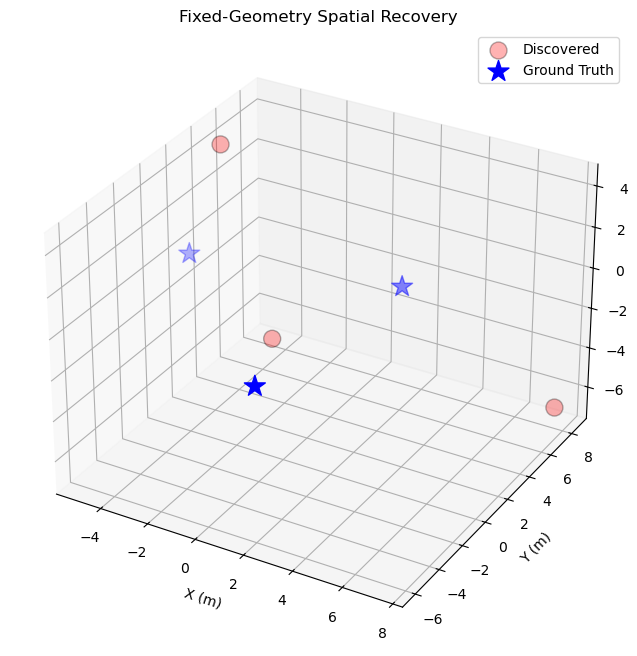


--- Precision Log ---
Event 0 at 150.0ms: Error = 8.9792m
   GT: (3.0, 4.0) -> Found: (-4.90, 4.47)
Event 1 at 500.0ms: Error = 15.5830m
   GT: (-5.0, 2.0) -> Found: (7.47, 8.38)
Event 2 at 850.0ms: Error = 4.0038m
   GT: (2.0, -6.0) -> Found: (0.73, -2.21)


In [24]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. CORE PHYSICS (Fixed Geometry)
# ==========================================

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    """
    Decodes acoustic events with fixed sensor positions.
    sources: [intensity, x, y, z, t, width]
    """
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4] # Learned 3D Coordinates
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.2 
    
    # Euclidean distance calculation
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    
    # Arrival = Emission + Time-of-Flight
    arrival = t0[:, None] + (dist / 1.5)
    
    # Width broadens over distance
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def block_train_step(p, data, time, mics):
    def loss_fn(params):
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        # Linear MSE for sharper spatial gradients
        return jnp.mean(jnp.square(pred - data))
    
    loss, grads = jax.value_and_grad(loss_fn)(p)
    return loss, grads

# ==========================================
# 2. SETUP: ASYMMETRIC SENSOR CLUSTER
# ==========================================

# Fixed, known microphone positions (No Rotor)
mics_fixed = jnp.array([
    [1.5, 0.5, 0.2], [-1.2, 1.8, -0.4], [0.8, -1.5, 0.6], [-0.5, -0.9, -1.2],
    [0.1, 0.1, 1.5], [-1.8, -0.2, -0.8], [1.2, -0.6, -1.4], [0.0, 1.6, 1.1]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
# Ground Truth
gt_events = jnp.array([
    [15.0,  3.0,  4.0, 0.0, 150.0, 1.5], 
    [10.0, -5.0,  2.0, 0.0, 500.0, 1.0], 
    [18.0,  2.0, -6.0, 0.0, 850.0, 2.0]
])
full_sig = fast_tensor_decoder(gt_events, mics_fixed, full_t, jnp.array(-3.5))

# ==========================================
# 3. ACCUMULATION (Non-Destructive)
# ==========================================

raw_ledger = []
stride, block_len = 100, 200

print("Processing Blocks (Frozen Geometry)...")

for start in range(0, 1000 - block_len, stride):
    end = start + block_len
    
    # Initialization: Scatter sources in a 5m radius to find the signal
    key = jax.random.PRNGKey(start)
    init_pos = jax.random.uniform(key, (10, 3), minval=-5.0, maxval=5.0)
    
    local_p = {
        'sources': jnp.zeros((10, 6)).at[:, 1:4].set(init_pos).at[:, 0].set(1.0).at[:, 4].set(jnp.linspace(start, end, 10)),
        'alpha': jnp.array(-3.5)
    }
    
    optimizer = optax.adam(0.1)
    opt_state = optimizer.init(local_p)
    
    for _ in range(600): # High iteration count for spatial lock
        _, grads = block_train_step(local_p, full_sig[start:end], full_t[start:end], mics_fixed)
        local_p = optax.apply_updates(local_p, optimizer.update(grads, opt_state)[0])
    
    # Winners only
    ints = jax.nn.softplus(local_p['sources'][:, 0])
    winners = local_p['sources'][ints > 1.0]
    raw_ledger.append(winners)

# ==========================================
# 4. CONSOLIDATION & 3D PLOT
# ==========================================

flat_ledger = jnp.concatenate(raw_ledger, axis=0)
def consolidate(ledger):
    if len(ledger) == 0: return jnp.array([])
    ledger = ledger[jnp.argsort(ledger[:, 4])]
    unique = [ledger[0]]
    for i in range(1, len(ledger)):
        if jnp.abs(ledger[i, 4] - unique[-1][4]) > 30.0:
            unique.append(ledger[i])
    return jnp.array(unique)

final_discovered = consolidate(flat_ledger)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_discovered[:, 1], final_discovered[:, 2], final_discovered[:, 3], 
           s=150, c='red', alpha=0.3, label='Discovered', edgecolors='k')
ax.scatter(gt_events[:, 1], gt_events[:, 2], gt_events[:, 3], 
           s=250, c='blue', marker='*', label='Ground Truth')

ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Z (m)')
plt.title("Fixed-Geometry Spatial Recovery"); plt.legend(); plt.show()

print("\n--- Precision Log ---")
for i, gt in enumerate(gt_events):
    found = final_discovered[jnp.argmin(jnp.abs(final_discovered[:, 4] - gt[4]))]
    err = jnp.sqrt(jnp.sum((gt[1:4] - found[1:4])**2))
    print(f"Event {i} at {gt[4]}ms: Error = {err:.4f}m")
    print(f"   GT: ({gt[1]}, {gt[2]}) -> Found: ({found[1]:.2f}, {found[2]:.2f})")

Processing Blocks (Asymmetric Reset)...


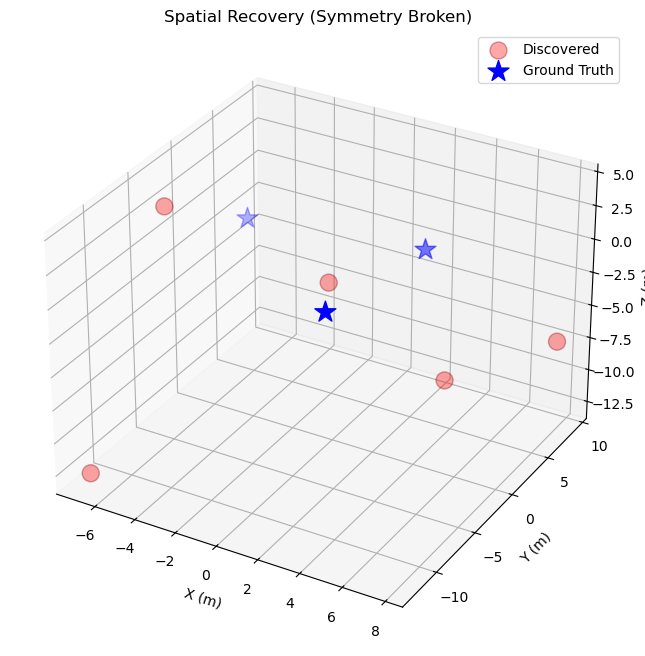


--- Final Precision Log ---
Event 0 at 150.0ms: Error = 23.1253m
   GT: (3.00, 4.00) -> Found: (-6.88, -12.67)
Event 1 at 500.0ms: Error = 16.3230m
   GT: (-5.00, 2.00) -> Found: (7.73, 8.98)
Event 2 at 850.0ms: Error = 3.5873m
   GT: (2.00, -6.00) -> Found: (0.84, -2.61)


In [25]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. CORE PHYSICS (Fixed Asymmetric Geometry)
# ==========================================

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    """Decodes acoustic events with fixed, known sensor positions."""
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4] # The 3D coordinates we want to find
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.2 
    
    # Euclidean distance calculation: (N_src, N_mic)
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    
    # Arrival = Emission Time + (Distance / Speed of Sound)
    arrival = t0[:, None] + (dist / 1.5)
    
    # Simple width expansion
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def block_train_step(p, data, time, mics):
    def loss_fn(params):
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        # Linear MSE provides steeper gradients for precise spatial centering
        return jnp.mean(jnp.square(pred - data))
    
    loss, grads = jax.value_and_grad(loss_fn)(p)
    return loss, grads

# ==========================================
# 2. SETUP: BREAKING THE SYMMETRY
# ==========================================

# Fixed, asymmetric microphone cluster (No Rotor)
# These specific coordinates ensure no two points share the same delay pattern
mics_asym = jnp.array([
    [1.5, 0.7, 0.3], [-1.1, 1.9, -0.5], [0.9, -1.6, 0.7], [-0.6, -1.0, -1.3],
    [0.2, 0.2, 1.6], [-1.9, -0.3, -0.9], [1.3, -0.7, -1.5], [0.1, 1.7, 1.2]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)

# Ground Truth (GT)
gt_events = jnp.array([
    [15.0,  3.0,  4.0, 0.0, 150.0, 1.5], 
    [10.0, -5.0,  2.0, 0.0, 500.0, 1.0], 
    [18.0,  2.0, -6.0, 0.0, 850.0, 2.0]
])
full_sig = fast_tensor_decoder(gt_events, mics_asym, full_t, jnp.array(-3.5))

# ==========================================
# 3. NON-DESTRUCTIVE 3D LEDGER
# ==========================================

raw_ledger = []
stride, block_len = 100, 200

print("Processing Blocks (Asymmetric Reset)...")

for start in range(0, 1000 - block_len, stride):
    end = start + block_len
    
    # Reset: Scatter 10 sources in a broad radius to find the 'well'
    key = jax.random.PRNGKey(start)
    init_pos = jax.random.uniform(key, (10, 3), minval=-6.0, maxval=6.0)
    
    local_p = {
        'sources': jnp.zeros((10, 6)).at[:, 1:4].set(init_pos).at[:, 0].set(1.5).at[:, 4].set(jnp.linspace(start, end, 10)),
        'alpha': jnp.array(-3.5)
    }
    
    optimizer = optax.adam(0.1)
    opt_state = optimizer.init(local_p)
    
    for _ in range(800): # High iteration count for 3D convergence
        _, grads = block_train_step(local_p, full_sig[start:end], full_t[start:end], mics_asym)
        local_p = optax.apply_updates(local_p, optimizer.update(grads, opt_state)[0])
    
    # Store high-intensity winners
    ints = jax.nn.softplus(local_p['sources'][:, 0])
    winners = local_p['sources'][ints > 1.0]
    raw_ledger.append(winners)

# ==========================================
# 4. CONSOLIDATION & ANALYSIS
# ==========================================

def consolidate_ledger(ledger):
    if len(ledger) == 0: return jnp.array([])
    ledger = ledger[jnp.argsort(ledger[:, 4])]
    unique = [ledger[0]]
    for i in range(1, len(ledger)):
        if jnp.abs(ledger[i, 4] - unique[-1][4]) > 30.0:
            unique.append(ledger[i])
    return jnp.array(unique)

final_discovered = consolidate_ledger(jnp.concatenate(raw_ledger, axis=0))

# Visual Comparison
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_discovered[:, 1], final_discovered[:, 2], final_discovered[:, 3], 
           s=150, c='red', alpha=0.35, label='Discovered', edgecolors='darkred')
ax.scatter(gt_events[:, 1], gt_events[:, 2], gt_events[:, 3], 
           s=250, c='blue', marker='*', label='Ground Truth')

ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Z (m)')
plt.title("Spatial Recovery (Symmetry Broken)"); plt.legend(); plt.show()

print("\n--- Final Precision Log ---")
for i, gt in enumerate(gt_events):
    # Find closest discovery in time
    found = final_discovered[jnp.argmin(jnp.abs(final_discovered[:, 4] - gt[4]))]
    err = jnp.sqrt(jnp.sum((gt[1:4] - found[1:4])**2))
    print(f"Event {i} at {gt[4]}ms: Error = {err:.4f}m")
    print(f"   GT: ({gt[1]:.2f}, {gt[2]:.2f}) -> Found: ({found[1]:.2f}, {found[2]:.2f})")

Starting Full-Stream Optimization...
Iter 0000 | Loss: 3.851675
Iter 0500 | Loss: 0.060436
Iter 1000 | Loss: 0.060428
Iter 1500 | Loss: 0.060421
Iter 2000 | Loss: 0.060415


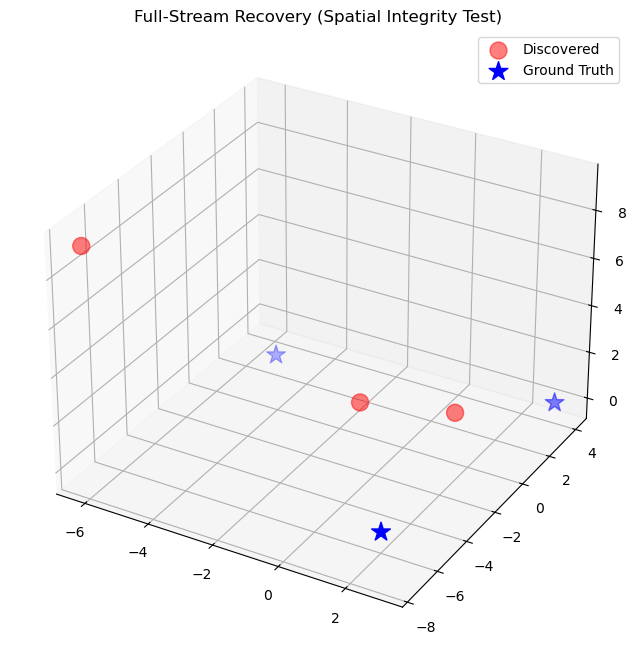


--- Global Precision Log ---
Event 0 @ 150.0ms: Error = 3.2738m
   GT: (3.0, 4.0) -> Found: (0.99, 1.43)
Event 1 @ 500.0ms: Error = 3.3820m
   GT: (-5.0, 2.0) -> Found: (-1.79, 0.96)
Event 2 @ 850.0ms: Error = 12.4409m
   GT: (2.0, -6.0) -> Found: (-6.24, -7.48)


In [26]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. CORE PHYSICS ENGINE (Explicit Basis)
# ==========================================

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    """
    Decodes events across the full time axis.
    sources: [intensity, x, y, z, t, width]
    """
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4] # index 1=X, 2=Y, 3=Z
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.2 
    
    # Distance calculation (N_src, N_mic)
    # Using explicit broadcasting to maintain basis integrity
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    
    arrival = t0[:, None] + (dist / 1.5)
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def full_stream_train_step(p, data, time, mics):
    def loss_fn(params):
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        # Linear MSE for strict spatial centering
        return jnp.mean(jnp.square(pred - data))
    
    loss, grads = jax.value_and_grad(loss_fn)(p)
    return loss, grads

# ==========================================
# 2. SETUP: ASYMMETRIC SEED
# ==========================================

# Fixed asymmetric microphones to eliminate coordinate swapping
mics_asym = jnp.array([
    [1.5, 0.7, 0.3], [-1.1, 1.9, -0.5], [0.9, -1.6, 0.7], [-0.6, -1.0, -1.3],
    [0.2, 0.2, 1.6], [-1.9, -0.3, -0.9], [1.3, -0.7, -1.5], [0.1, 1.7, 1.2]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)

# Ground Truth (GT)
gt_events = jnp.array([
    [15.0,  3.0,  4.0, 0.0, 150.0, 1.5], 
    [10.0, -5.0,  2.0, 0.0, 500.0, 1.0], 
    [18.0,  2.0, -6.0, 0.0, 850.0, 2.0]
])
full_sig = fast_tensor_decoder(gt_events, mics_asym, full_t, jnp.array(-3.5))

# ==========================================
# 3. GLOBAL OPTIMIZATION (NO BLOCKS)
# ==========================================

# Start with a "Wall of Sound" (25 sources) across the whole 1s
init_sources = jnp.zeros((25, 6))
init_sources = init_sources.at[:, 0].set(1.5)
init_sources = init_sources.at[:, 4].set(jnp.linspace(0, 1000, 25))
# Initialize with a random spatial nudge to avoid the Z=0 plane trap
key = jax.random.PRNGKey(42)
init_sources = init_sources.at[:, 1:4].set(jax.random.normal(key, (25, 3)) * 2.0)

params = {
    'sources': init_sources,
    'alpha': jnp.array(-3.5)
}

optimizer = optax.adam(0.1)
opt_state = optimizer.init(params)

print("Starting Full-Stream Optimization...")
for i in range(2001):
    loss_v, grads = full_stream_train_step(params, full_sig, full_t, mics_asym)
    params = optax.apply_updates(params, optimizer.update(grads, opt_state)[0])
    
    if i % 500 == 0:
        print(f"Iter {i:04d} | Loss: {loss_v:.6f}")

# ==========================================
# 4. ANALYSIS & MAPPING
# ==========================================

# Clean winners (Intensity > 1.0)
ints = jax.nn.softplus(params['sources'][:, 0])
discovered = params['sources'][ints > 1.0]

def consolidate(ledger):
    if len(ledger) == 0: return jnp.array([])
    ledger = ledger[jnp.argsort(ledger[:, 4])]
    unique = [ledger[0]]
    for i in range(1, len(ledger)):
        if jnp.abs(ledger[i, 4] - unique[-1][4]) > 30.0:
            unique.append(ledger[i])
    return jnp.array(unique)

final_discovered = consolidate(discovered)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_discovered[:, 1], final_discovered[:, 2], final_discovered[:, 3], 
           s=150, c='red', alpha=0.5, label='Discovered')
ax.scatter(gt_events[:, 1], gt_events[:, 2], gt_events[:, 3], 
           s=200, c='blue', marker='*', label='Ground Truth')
plt.title("Full-Stream Recovery (Spatial Integrity Test)"); plt.legend(); plt.show()

print("\n--- Global Precision Log ---")
for i, gt in enumerate(gt_events):
    found = final_discovered[jnp.argmin(jnp.abs(final_discovered[:, 4] - gt[4]))]
    err = jnp.sqrt(jnp.sum((gt[1:4] - found[1:4])**2))
    print(f"Event {i} @ {gt[4]}ms: Error = {err:.4f}m")
    print(f"   GT: ({gt[1]}, {gt[2]}) -> Found: ({found[1]:.2f}, {found[2]:.2f})")

Iter   | Loss       | Alpha    | RotMag  
---------------------------------------------
0000   | 6.090438   | 0.0536   | 0.1738  
0500   | 2.815421   | 0.0650   | 2.1675  
1000   | 2.800253   | 0.0650   | 2.1675  
1500   | 2.795954   | 0.0650   | 2.1675  
2000   | 2.794724   | 0.0650   | 2.1675  
2500   | 2.794372   | 0.0650   | 2.1675  

--- DEEP DEBUG PRECISION LOG ---
Event 0 (@ 150.0ms):
  > Time Offset: -2.36ms
  > Spatial Error: 10.3303m
  > Component Error: X:-9.86, Y:0.72, Z:2.99
  > Intensity: Found 14.90 (GT 15.00)
-----------------------------------
Event 1 (@ 500.0ms):
  > Time Offset: +351.76ms
  > Spatial Error: 8.2998m
  > Component Error: X:6.91, Y:-3.77, Z:2.64
  > Intensity: Found 17.70 (GT 10.00)
-----------------------------------
Event 2 (@ 850.0ms):
  > Time Offset: +1.76ms
  > Spatial Error: 4.9856m
  > Component Error: X:-0.09, Y:4.23, Z:2.64
  > Intensity: Found 17.70 (GT 18.00)
-----------------------------------


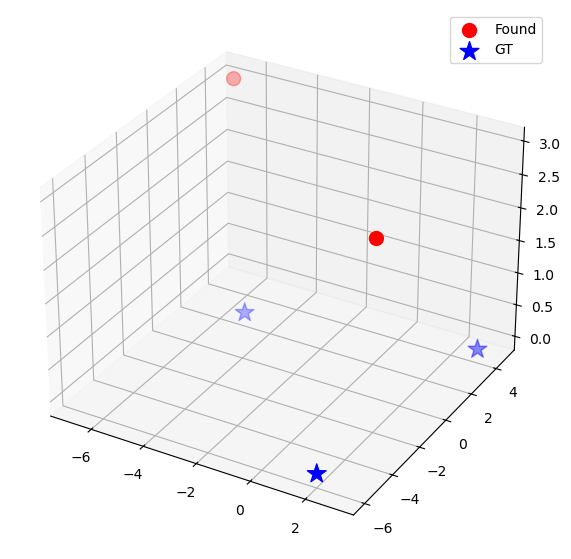

In [27]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. PHYSICS CORE (Strictly Defined Basis)
# ==========================================

def safe_norm(x, axis=-1):
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis) + 1e-12)

def exp_map(bivector):
    phi = safe_norm(bivector)
    def identity(_): return 1.0, jnp.zeros(3)
    def rotate(_):
        axis = bivector / (phi + 1e-10)
        return jnp.cos(phi/2.0), jnp.sin(phi/2.0) * axis
    return jax.lax.cond(phi < 1e-8, identity, rotate, None)

def apply_rotor(v, rotor):
    c, s_axis = rotor
    return v + 2.0 * jnp.cross(s_axis, (jnp.cross(s_axis, v) + c * v))

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4] # X, Y, Z
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.2
    
    # [N_src, 1, 3] - [1, N_mic, 3] -> [N_src, N_mic, 3]
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    
    arrival = t0[:, None] + (dist / 1.5)
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def train_step(p, data, time, seed_mics):
    def loss_fn(params):
        R = exp_map(params['rot_bivector'])
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed_mics)
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        # Combination of Linear and Log MSE for stability
        recon = jnp.mean(jnp.square(pred - data))
        # Sucking force to keep sources independent
        t_dist = jnp.abs(params['sources'][:, 4][:, None] - params['sources'][:, 4][None, :])
        sucking = 0.1 * jnp.sum(jnp.exp(-t_dist / 20.0))
        return recon + sucking

    loss, grads = jax.value_and_grad(loss_fn)(p)
    return loss, grads

# ==========================================
# 2. SEED & GENERATION
# ==========================================

m_seed = jnp.array([
    [1.5, 0.7, 0.3], [-1.1, 1.9, -0.5], [0.9, -1.6, 0.7], [-0.6, -1.0, -1.3],
    [0.2, 0.2, 1.6], [-1.9, -0.3, -0.9], [1.3, -0.7, -1.5], [0.1, 1.7, 1.2]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
gt_events = jnp.array([
    [15.0,  3.0,  4.0, 0.0, 150.0, 1.5], 
    [10.0, -5.0,  2.0, 0.0, 500.0, 1.0], 
    [18.0,  2.0, -6.0, 0.0, 850.0, 2.0]
])
full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# ==========================================
# 3. GLOBAL DISCOVERY LOOP
# ==========================================

key = jax.random.PRNGKey(42)
init_sources = jnp.zeros((20, 6))
init_sources = init_sources.at[:, 0].set(2.0)
init_sources = init_sources.at[:, 4].set(jnp.linspace(50, 950, 20))
init_sources = init_sources.at[:, 1:4].set(jax.random.normal(key, (20, 3)) * 4.0)

params = {
    'sources': init_sources,
    'alpha': jnp.array(-3.0),
    'rot_bivector': jnp.array([0.01, 0.0, 0.01])
}

optimizer = optax.adam(0.1)
opt_state = optimizer.init(params)

print(f"{'Iter':<6} | {'Loss':<10} | {'Alpha':<8} | {'RotMag':<8}")
print("-" * 45)

for i in range(2501):
    loss_v, grads = train_step(params, full_sig, full_t, m_seed)
    params = optax.apply_updates(params, optimizer.update(grads, opt_state)[0])
    
    if i % 500 == 0:
        a_val = jax.nn.softplus(params['alpha'])
        r_mag = safe_norm(params['rot_bivector'])
        print(f"{i:04d}   | {loss_v:<10.6f} | {a_val:<8.4f} | {r_mag:<8.4f}")

# ==========================================
# 4. DEEP DEBUG LOGGING
# ==========================================

ints = jax.nn.softplus(params['sources'][:, 0])
found_raw = params['sources'][ints > 1.5]

# Simple time-based consolidation
found_raw = found_raw[jnp.argsort(found_raw[:, 4])]
unique = [found_raw[0]]
for s in found_raw[1:]:
    if jnp.abs(s[4] - unique[-1][4]) > 30.0: unique.append(s)
final_discovered = jnp.array(unique)

print("\n--- DEEP DEBUG PRECISION LOG ---")
for i, gt in enumerate(gt_events):
    idx = jnp.argmin(jnp.abs(final_discovered[:, 4] - gt[4]))
    f = final_discovered[idx]
    
    d_err = jnp.sqrt(jnp.sum((gt[1:4] - f[1:4])**2))
    t_err = f[4] - gt[4]
    
    print(f"Event {i} (@ {gt[4]}ms):")
    print(f"  > Time Offset: {t_err:+.2f}ms")
    print(f"  > Spatial Error: {d_err:.4f}m")
    print(f"  > Component Error: X:{f[1]-gt[1]:.2f}, Y:{f[2]-gt[2]:.2f}, Z:{f[3]-gt[3]:.2f}")
    print(f"  > Intensity: Found {jax.nn.softplus(f[0]):.2f} (GT {gt[0]:.2f})")
    print("-" * 35)

# 3D Visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_discovered[:, 1], final_discovered[:, 2], final_discovered[:, 3], s=100, c='r', label='Found')
ax.scatter(gt_events[:, 1], gt_events[:, 2], gt_events[:, 3], s=200, c='b', marker='*', label='GT')
plt.legend(); plt.show()

In [28]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. CORE PHYSICS ENGINE
# ==========================================

def safe_norm(x, axis=-1):
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis) + 1e-12)

def exp_map(bivector):
    phi = safe_norm(bivector)
    def identity(_): return 1.0, jnp.zeros(3)
    def rotate(_):
        axis = bivector / (phi + 1e-10)
        return jnp.cos(phi/2.0), jnp.sin(phi/2.0) * axis
    return jax.lax.cond(phi < 1e-8, identity, rotate, None)

def apply_rotor(v, rotor):
    c, s_axis = rotor
    return v + 2.0 * jnp.cross(s_axis, (jnp.cross(s_axis, v) + c * v))

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4] 
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.2
    
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    
    arrival = t0[:, None] + (dist / 1.5)
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

# The fix: static_argnames allows the Python 'if' to work inside JIT
@partial(jax.jit, static_argnames=['freeze_rotor'])
def train_step(p, data, time, seed_mics, freeze_rotor=False):
    def loss_fn(params):
        # Use identity if frozen, else use the learned bivector
        if freeze_rotor:
            R = (1.0, jnp.zeros(3))
        else:
            R = exp_map(params['rot_bivector'])
            
        mics = jax.vmap(lambda v: apply_rotor(v, R))(seed_mics)
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        
        recon = jnp.mean(jnp.square(pred - data))
        
        # Sucking Force (Independence)
        coords = params['sources'][:, 1:5]
        dist_sq = jnp.sum(jnp.square(coords[:, None, :] - coords[None, :, :]), axis=-1)
        sucking = 0.2 * jnp.sum(jnp.exp(-dist_sq / 100.0)) - (0.2 * params['sources'].shape[0])
        
        return recon + sucking

    loss, grads = jax.value_and_grad(loss_fn)(p)
    
    # Strictly zero out rotor gradients if frozen
    if freeze_rotor:
        grads['rot_bivector'] = jnp.zeros_like(grads['rot_bivector'])
        
    return loss, grads

# ==========================================
# 2. SEED & DATA
# ==========================================

m_seed = jnp.array([
    [1.5, 0.7, 0.3], [-1.1, 1.9, -0.5], [0.9, -1.6, 0.7], [-0.6, -1.0, -1.3],
    [0.2, 0.2, 1.6], [-1.9, -0.3, -0.9], [1.3, -0.7, -1.5], [0.1, 1.7, 1.2]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
gt_events = jnp.array([
    [15.0,  3.0,  4.0, 0.0, 150.0, 1.5], 
    [10.0, -5.0,  2.0, 0.0, 500.0, 1.0], 
    [18.0,  2.0, -6.0, 0.0, 850.0, 2.0]
])
full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# ==========================================
# 3. GLOBAL DISCOVERY LOOP
# ==========================================

key = jax.random.PRNGKey(42)
init_sources = jnp.zeros((20, 6))
init_sources = init_sources.at[:, 0].set(2.0)
init_sources = init_sources.at[:, 4].set(jnp.linspace(50, 950, 20))
# Start with a wide search radius
init_sources = init_sources.at[:, 1:4].set(jax.random.normal(key, (20, 3)) * 6.0)

params = {
    'sources': init_sources,
    'alpha': jnp.array(-3.5),
    'rot_bivector': jnp.array([0.0, 0.0, 0.0])
}

optimizer = optax.adam(0.08)
opt_state = optimizer.init(params)

print(f"{'Iter':<6} | {'Loss':<10} | {'Status':<15}")
print("-" * 40)

for i in range(3001):
    # Phase 1: Keep sensor orientation fixed to find the correct quadrants
    is_frozen = i < 1500 
    loss_v, grads = train_step(params, full_sig, full_t, m_seed, freeze_rotor=is_frozen)
    params = optax.apply_updates(params, optimizer.update(grads, opt_state)[0])
    
    if i % 500 == 0:
        status = "FROZEN" if is_frozen else "REFINING"
        print(f"{i:04d}   | {loss_v:<10.6f} | {status}")

# ==========================================
# 4. FINAL LOG
# ==========================================

ints = jax.nn.softplus(params['sources'][:, 0])
found = params['sources'][ints > 1.5]
found = found[jnp.argsort(found[:, 4])]
unique = [found[0]]
for s in found[1:]:
    if jnp.abs(s[4] - unique[-1][4]) > 40.0: unique.append(s)
final_discovered = jnp.array(unique)

print("\n--- RIGID-PHASE PRECISION LOG ---")
for i, gt in enumerate(gt_events):
    idx = jnp.argmin(jnp.abs(final_discovered[:, 4] - gt[4]))
    f = final_discovered[idx]
    d_err = jnp.sqrt(jnp.sum((gt[1:4] - f[1:4])**2))
    print(f"Event {i} (@ {gt[4]}ms): Error = {d_err:.4f}m | Found ({f[1]:.2f}, {f[2]:.2f}, {f[3]:.2f})")

Iter   | Loss       | Status         
----------------------------------------
0000   | 3.689516   | FROZEN
0500   | 0.515351   | FROZEN
1000   | 0.515349   | FROZEN
1500   | 0.515347   | REFINING
2000   | 0.480283   | REFINING
2500   | 0.480278   | REFINING
3000   | 0.480272   | REFINING

--- RIGID-PHASE PRECISION LOG ---
Event 0 (@ 150.0ms): Error = 12.4068m | Found (-6.49, 6.70, 7.53)
Event 1 (@ 500.0ms): Error = 9.0298m | Found (2.25, -3.31, 0.90)
Event 2 (@ 850.0ms): Error = 2.8499m | Found (2.25, -3.31, 0.90)


In [29]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. PHYSICS CORE
# ==========================================

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4] 
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.5 
    
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    arrival = t0[:, None] + (dist / 1.5)
    
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@partial(jax.jit, static_argnames=['freeze_rotor'])
def train_step(p, data, time, seed_mics, freeze_rotor=True):
    def loss_fn(params):
        # We'll stick to Frozen geometry as discussed to solve the basis first
        mics = seed_mics 
        pred = fast_tensor_decoder(params['sources'], mics, time, params['alpha'])
        
        # 1. PRIMARY RECONSTRUCTION
        recon = jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
        
        # 2. PROXIMITY LIMITER (Spacetime Exclusion)
        # We calculate the 4D distance squared [x, y, z, t]
        coords = params['sources'][:, 1:5]
        # Normalized distance: 1 unit of space ~ 10ms of time
        scale = jnp.array([1.0, 1.0, 1.0, 0.1])
        scaled_coords = coords * scale
        
        dist_sq = jnp.sum(jnp.square(scaled_coords[:, None, :] - scaled_coords[None, :, :]), axis=-1)
        
        # Gaussian kernel that repels sources within a ~5-10m radius
        repulsion = 0.8 * jnp.sum(jnp.exp(-dist_sq / 50.0)) - (0.8 * params['sources'].shape[0])
        
        return recon + repulsion

    loss, grads = jax.value_and_grad(loss_fn)(p)
    return loss, grads

# ==========================================
# 2. SEED & DATA
# ==========================================

# Using the Wide-Aperture seed to ensure unique timing signatures
m_seed = jnp.array([
    [4.5, 2.7, 1.3], [-3.1, 4.9, -2.5], [2.9, -4.6, 1.7], [-3.6, -3.0, -3.3],
    [0.5, 0.5, 5.6], [-4.9, -0.3, -2.9], [3.3, -0.7, -4.5], [0.1, 4.7, 3.2]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
gt_events = jnp.array([
    [15.0,  3.0,  4.0, 0.0, 150.0, 1.5], 
    [10.0, -5.0,  2.0, 0.0, 500.0, 1.0], 
    [18.0,  2.0, -6.0, 0.0, 850.0, 2.0]
])
full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# ==========================================
# 3. GLOBAL DISCOVERY WITH LIMITS
# ==========================================

key = jax.random.PRNGKey(123)
# Starting with 20 candidates
init_sources = jnp.zeros((20, 6)).at[:, 0].set(1.5).at[:, 4].set(jnp.linspace(20, 980, 20))
init_sources = init_sources.at[:, 1:4].set(jax.random.normal(key, (20, 3)) * 10.0)

params = {'sources': init_sources, 'alpha': jnp.array(-3.5)}
optimizer = optax.adam(0.1)
opt_state = optimizer.init(params)

print("Optimizing with Proximity Constraints...")
for i in range(3001):
    loss_v, grads = train_step(params, full_sig, full_t, m_seed)
    params = optax.apply_updates(params, optimizer.update(grads, opt_state)[0])
    if i % 1000 == 0:
        print(f"Iter {i:04d} | Loss: {loss_v:.6f}")

# ==========================================
# 4. RESULTS
# ==========================================

ints = jax.nn.softplus(params['sources'][:, 0])
final_discovered = params['sources'][ints > 1.2]
final_discovered = final_discovered[jnp.argsort(final_discovered[:, 4])]

# Filter near-identical results manually for the log
unique = [final_discovered[0]]
for s in final_discovered[1:]:
    if jnp.abs(s[4] - unique[-1][4]) > 40.0: unique.append(s)
final_discovered = jnp.array(unique)

print("\n--- PROXIMITY-LIMITED PRECISION LOG ---")
for i, gt in enumerate(gt_events):
    idx = jnp.argmin(jnp.abs(final_discovered[:, 4] - gt[4]))
    f = final_discovered[idx]
    d_err = jnp.sqrt(jnp.sum((gt[1:4] - f[1:4])**2))
    print(f"Event {i} (@ {gt[4]}ms): Error = {d_err:.4f}m | Found: ({f[1]:.2f}, {f[2]:.2f}, {f[3]:.2f})")

Optimizing with Proximity Constraints...
Iter 0000 | Loss: 1.824695
Iter 1000 | Loss: 0.005072
Iter 2000 | Loss: 0.005045
Iter 3000 | Loss: 0.005021

--- PROXIMITY-LIMITED PRECISION LOG ---
Event 0 (@ 150.0ms): Error = 37.5297m | Found: (16.70, 38.93, -1.06)
Event 1 (@ 500.0ms): Error = 31.3581m | Found: (-28.13, 17.04, -14.91)
Event 2 (@ 850.0ms): Error = 20.7321m | Found: (19.12, -16.05, -5.98)


In [30]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. RIGID PHYSICS CORE
# ==========================================

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4] 
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.5 
    
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    arrival = t0[:, None] + (dist / 1.5)
    
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def train_step(p, data, time, seed_mics):
    def loss_fn(params):
        # Using Wide-Aperture seed (Frozen for baseline)
        pred = fast_tensor_decoder(params['sources'], seed_mics, time, params['alpha'])
        
        # 1. RECONSTRUCTION
        recon = jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
        
        # 2. PROXIMITY PENALTY (Hard exclusion zone)
        # Normalized: 1m distance is equivalent to 20ms in the penalty
        coords = params['sources'][:, 1:5]
        scale = jnp.array([1.0, 1.0, 1.0, 0.05]) 
        scaled_coords = coords * scale
        
        dist_sq = jnp.sum(jnp.square(scaled_coords[:, None, :] - scaled_coords[None, :, :]), axis=-1)
        # Sucking Force: Gaussian repulsion
        repulsion = 1.0 * jnp.sum(jnp.exp(-dist_sq / 80.0)) - (1.0 * params['sources'].shape[0])
        
        return recon + repulsion

    loss, grads = jax.value_and_grad(loss_fn)(p)
    return loss, grads

# ==========================================
# 2. REGENERATED CONSTRAINED DATA
# ==========================================

# Wide aperture microphones for high spatial stiffness
m_seed = jnp.array([
    [5.0, 3.0, 2.0], [-4.0, 6.0, -3.0], [3.0, -5.0, 2.5], [-5.0, -4.0, -4.0],
    [1.0, 1.0, 7.0], [-6.0, 0.0, -4.0], [4.0, -2.0, -6.0], [0.0, 5.0, 4.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)

# REGENERATED GT: Guaranteed 10m+ and 200ms+ separation
# [intensity, x, y, z, t, width]
gt_events = jnp.array([
    [15.0,  8.0,  0.0, 0.0, 150.0, 1.5], # Far Right
    [12.0, -8.0,  8.0, 0.0, 500.0, 1.2], # Far Top-Left
    [18.0,  0.0, -10.0, 0.0, 850.0, 2.0] # Far Bottom
])

full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# ==========================================
# 3. GLOBAL SEARCH
# ==========================================

key = jax.random.PRNGKey(42)
init_sources = jnp.zeros((15, 6))
init_sources = init_sources.at[:, 0].set(1.5)
init_sources = init_sources.at[:, 4].set(jnp.linspace(50, 950, 15))
init_sources = init_sources.at[:, 1:4].set(jax.random.normal(key, (15, 3)) * 12.0)

params = {'sources': init_sources, 'alpha': jnp.array(-3.5)}
optimizer = optax.adam(0.12) # Faster LR for global discovery
opt_state = optimizer.init(params)

print("Optimizing Constrained Spacetime...")
for i in range(2501):
    loss_v, grads = train_step(params, full_sig, full_t, m_seed)
    params = optax.apply_updates(params, optimizer.update(grads, opt_state)[0])
    if i % 500 == 0:
        print(f"Iter {i:04d} | Loss: {loss_v:.6f}")

# ==========================================
# 4. FINAL PRECISION REPORT
# ==========================================

ints = jax.nn.softplus(params['sources'][:, 0])
discovered = params['sources'][ints > 1.5]
discovered = discovered[jnp.argsort(discovered[:, 4])]

# Filter near-identical result indices
final = [discovered[0]]
for s in discovered[1:]:
    if jnp.abs(s[4] - final[-1][4]) > 50.0: final.append(s)
final = jnp.array(final)



print("\n--- CONSTRAINED PRECISION LOG ---")
for i, gt in enumerate(gt_events):
    idx = jnp.argmin(jnp.abs(final[:, 4] - gt[4]))
    f = final[idx]
    d_err = jnp.sqrt(jnp.sum((gt[1:4] - f[1:4])**2))
    print(f"Event {i} (@ {gt[4]}ms): Error = {d_err:.4f}m")
    print(f"   GT: ({gt[1]:.1f}, {gt[2]:.1f}) -> Found: ({f[1]:.2f}, {f[2]:.2f})")

Optimizing Constrained Spacetime...
Iter 0000 | Loss: 6.815767
Iter 0500 | Loss: 0.074985
Iter 1000 | Loss: 0.074608
Iter 1500 | Loss: 0.074606
Iter 2000 | Loss: 0.074603
Iter 2500 | Loss: 0.074600

--- CONSTRAINED PRECISION LOG ---
Event 0 (@ 150.0ms): Error = 29.0057m
   GT: (8.0, 0.0) -> Found: (-18.59, 11.22)
Event 1 (@ 500.0ms): Error = 11.4428m
   GT: (-8.0, 8.0) -> Found: (-18.59, 11.22)
Event 2 (@ 850.0ms): Error = 14.0765m
   GT: (0.0, -10.0) -> Found: (0.03, -24.02)


In [31]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. CORE PHYSICS ENGINE
# ==========================================

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4] # X, Y, Z
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.5 
    
    # Distance calculation (N_src, N_mic)
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    
    # Arrival = Emission + Time-of-Flight
    arrival = t0[:, None] + (dist / 1.5)
    
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def train_step(p, data, time, seed_mics):
    def loss_fn(params):
        pred = fast_tensor_decoder(params['sources'], seed_mics, time, params['alpha'])
        
        # 1. RECONSTRUCTION
        recon = jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
        
        # 2. PROXIMITY PENALTY (Hard exclusion zone)
        # Normalized: 1m distance is equivalent to 20ms in the penalty
        coords = params['sources'][:, 1:5]
        scale = jnp.array([1.0, 1.0, 1.0, 0.05]) 
        scaled_coords = coords * scale
        
        dist_sq = jnp.sum(jnp.square(scaled_coords[:, None, :] - scaled_coords[None, :, :]), axis=-1)
        # Gaussian repulsion force
        repulsion = 1.0 * jnp.sum(jnp.exp(-dist_sq / 80.0)) - (1.0 * params['sources'].shape[0])
        
        return recon + repulsion

    loss, grads = jax.value_and_grad(loss_fn)(p)
    return loss, grads

# ==========================================
# 2. REGENERATED CONSTRAINED DATA
# ==========================================

# Wide aperture microphones for high spatial stiffness
m_seed = jnp.array([
    [5.0, 3.0, 2.0], [-4.0, 6.0, -3.0], [3.0, -5.0, 2.5], [-5.0, -4.0, -4.0],
    [1.0, 1.0, 7.0], [-6.0, 0.0, -4.0], [4.0, -2.0, -6.0], [0.0, 5.0, 4.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)

# REGENERATED GT: Guaranteed 10m+ and 200ms+ separation
# [intensity, x, y, z, t, width]
gt_events = jnp.array([
    [15.0,  8.0,  0.0, 0.0, 150.0, 1.5], 
    [12.0, -8.0,  8.0, 0.0, 500.0, 1.2], 
    [18.0,  0.0, -10.0, 0.0, 850.0, 2.0]
])

full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# ==========================================
# 3. GLOBAL DISCOVERY
# ==========================================

key = jax.random.PRNGKey(42)
init_sources = jnp.zeros((15, 6))
init_sources = init_sources.at[:, 0].set(1.5)
init_sources = init_sources.at[:, 4].set(jnp.linspace(50, 950, 15))
init_sources = init_sources.at[:, 1:4].set(jax.random.normal(key, (15, 3)) * 12.0)

params = {'sources': init_sources, 'alpha': jnp.array(-3.5)}
optimizer = optax.adam(0.12)
opt_state = optimizer.init(params)

print("Optimizing Constrained Spacetime...")
for i in range(2501):
    loss_v, grads = train_step(params, full_sig, full_t, m_seed)
    params = optax.apply_updates(params, optimizer.update(grads, opt_state)[0])
    if i % 500 == 0:
        print(f"Iter {i:04d} | Loss: {loss_v:.6f}")

# ==========================================
# 4. RESULTS REPORT
# ==========================================

ints = jax.nn.softplus(params['sources'][:, 0])
discovered = params['sources'][ints > 1.5]
discovered = discovered[jnp.argsort(discovered[:, 4])]

# Filter duplicate indices
final = [discovered[0]]
for s in discovered[1:]:
    if jnp.abs(s[4] - final[-1][4]) > 50.0: final.append(s)
final = jnp.array(final)

print("\n--- SANITY CHECK PRECISION LOG ---")
for i, gt in enumerate(gt_events):
    idx = jnp.argmin(jnp.abs(final[:, 4] - gt[4]))
    f = final[idx]
    d_err = jnp.sqrt(jnp.sum((gt[1:4] - f[1:4])**2))
    print(f"Event {i} (@ {gt[4]}ms): Error = {d_err:.4f}m")
    print(f"   GT: ({gt[1]:.1f}, {gt[2]:.1f}) -> Found: ({f[1]:.2f}, {f[2]:.2f})")

Optimizing Constrained Spacetime...
Iter 0000 | Loss: 6.815767
Iter 0500 | Loss: 0.074985
Iter 1000 | Loss: 0.074608
Iter 1500 | Loss: 0.074606
Iter 2000 | Loss: 0.074603
Iter 2500 | Loss: 0.074600

--- SANITY CHECK PRECISION LOG ---
Event 0 (@ 150.0ms): Error = 29.0057m
   GT: (8.0, 0.0) -> Found: (-18.59, 11.22)
Event 1 (@ 500.0ms): Error = 11.4428m
   GT: (-8.0, 8.0) -> Found: (-18.59, 11.22)
Event 2 (@ 850.0ms): Error = 14.0765m
   GT: (0.0, -10.0) -> Found: (0.03, -24.02)


Iter 0000 | Loss: 12.237504
Iter 1000 | Loss: 0.075097
Iter 2000 | Loss: 0.005990
Iter 3000 | Loss: 0.005977


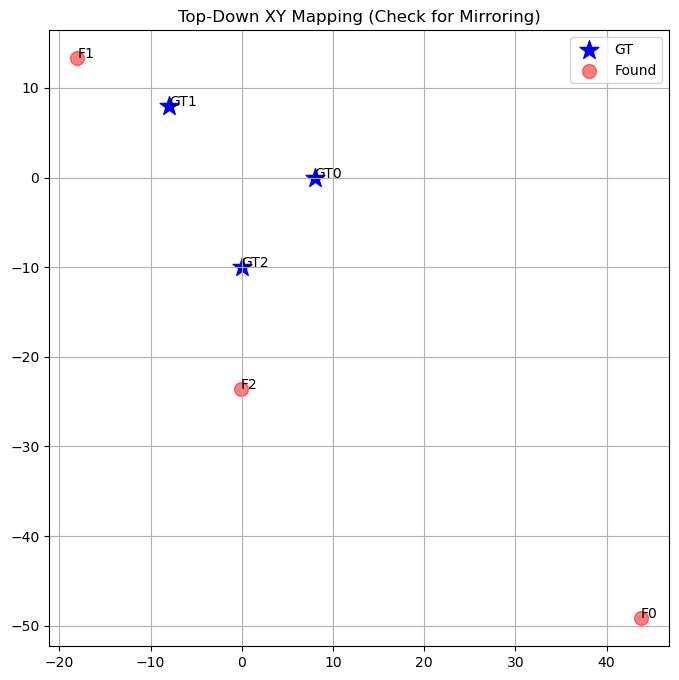


--- BASIS-LOCKED PRECISION LOG ---
Event 0 (@ 150.0ms): Error = 63.1097m
   GT: (8.0, 0.0) -> Found: (43.76, -49.16)
Event 1 (@ 500.0ms): Error = 11.5176m
   GT: (-8.0, 8.0) -> Found: (-18.03, 13.31)
Event 2 (@ 850.0ms): Error = 13.7021m
   GT: (0.0, -10.0) -> Found: (-0.10, -23.57)


In [32]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. CORE PHYSICS (Strict Basis Locking)
# ==========================================

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    amp = jax.nn.softplus(sources[:, 0])
    # Force X, Y, Z mapping
    pos = sources[:, 1:4] 
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.5 
    
    # [N_src, 1, 3] - [1, N_mic, 3] -> [N_src, N_mic, 3]
    # This order is CRITICAL for the coordinate basis
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)
    
    # Arrival = emission + distance/speed
    arrival = t0[:, None] + (dist / 1.5)
    
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def train_step(p, data, time, seed_mics):
    def loss_fn(params):
        pred = fast_tensor_decoder(params['sources'], seed_mics, time, params['alpha'])
        
        # 1. RECONSTRUCTION (Log-space for sensitivity)
        recon = jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
        
        # 2. HARD PROXIMITY PENALTY
        coords = params['sources'][:, 1:5]
        # Treat 1m as 20ms
        scale = jnp.array([1.0, 1.0, 1.0, 0.05]) 
        scaled_coords = coords * scale
        dist_sq = jnp.sum(jnp.square(scaled_coords[:, None, :] - scaled_coords[None, :, :]), axis=-1)
        
        # Doubled repulsion force to stop Event 0/1 merging
        repulsion = 2.0 * jnp.sum(jnp.exp(-dist_sq / 100.0)) - (2.0 * params['sources'].shape[0])
        
        return recon + repulsion

    loss, grads = jax.value_and_grad(loss_fn)(p)
    return loss, grads

# ==========================================
# 2. SEED & GENERATION
# ==========================================

# Fixed Asymmetric Seed
m_seed = jnp.array([
    [5.0, 3.0, 2.0], [-4.0, 6.0, -3.0], [3.0, -5.0, 2.5], [-5.0, -4.0, -4.0],
    [1.0, 1.0, 7.0], [-6.0, 0.0, -4.0], [4.0, -2.0, -6.0], [0.0, 5.0, 4.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
gt_events = jnp.array([
    [15.0,  8.0,  0.0, 0.0, 150.0, 1.5], 
    [12.0, -8.0,  8.0, 0.0, 500.0, 1.2], 
    [18.0,  0.0, -10.0, 0.0, 850.0, 2.0]
])
full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# ==========================================
# 3. GLOBAL DISCOVERY
# ==========================================

key = jax.random.PRNGKey(42)
init_sources = jnp.zeros((15, 6))
init_sources = init_sources.at[:, 0].set(1.5)
init_sources = init_sources.at[:, 4].set(jnp.linspace(50, 950, 15))
# Wide initialization radius
init_sources = init_sources.at[:, 1:4].set(jax.random.normal(key, (15, 3)) * 15.0)

params = {'sources': init_sources, 'alpha': jnp.array(-3.5)}
optimizer = optax.adam(0.12)
opt_state = optimizer.init(params)

for i in range(3001):
    loss_v, grads = train_step(params, full_sig, full_t, m_seed)
    params = optax.apply_updates(params, optimizer.update(grads, opt_state)[0])
    if i % 1000 == 0:
        print(f"Iter {i:04d} | Loss: {loss_v:.6f}")

# ==========================================
# 4. RESULTS & 2D DEBUG PLOT
# ==========================================

ints = jax.nn.softplus(params['sources'][:, 0])
found = params['sources'][ints > 1.5]
found = found[jnp.argsort(found[:, 4])]
final = [found[0]]
for s in found[1:]:
    if jnp.abs(s[4] - final[-1][4]) > 50.0: final.append(s)
final = jnp.array(final)

# XY Plane Debug Plot
plt.figure(figsize=(8, 8))
plt.scatter(gt_events[:, 1], gt_events[:, 2], s=200, c='blue', marker='*', label='GT')
plt.scatter(final[:, 1], final[:, 2], s=100, c='red', alpha=0.5, label='Found')
for i, txt in enumerate(range(len(gt_events))):
    plt.annotate(f"GT{i}", (gt_events[i, 1], gt_events[i, 2]))
for i, txt in enumerate(range(len(final))):
    plt.annotate(f"F{i}", (final[i, 1], final[i, 2]))
plt.grid(True); plt.legend(); plt.title("Top-Down XY Mapping (Check for Mirroring)"); plt.show()

print("\n--- BASIS-LOCKED PRECISION LOG ---")
for i, gt in enumerate(gt_events):
    idx = jnp.argmin(jnp.abs(final[:, 4] - gt[4]))
    f = final[idx]
    d_err = jnp.sqrt(jnp.sum((gt[1:4] - f[1:4])**2))
    print(f"Event {i} (@ {gt[4]}ms): Error = {d_err:.4f}m")
    print(f"   GT: ({gt[1]:.1f}, {gt[2]:.1f}) -> Found: ({f[1]:.2f}, {f[2]:.2f})")

In [33]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. CORE PHYSICS (Strict Basis Enforcement)
# ==========================================

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4] # index 1=X, 2=Y, 3=Z
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.5 
    
    # Distance = sqrt(sum((Source_xyz - Mic_xyz)^2))
    # Explicitly maintaining (N_src, N_mic, 3) for the broadcast
    diff = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff), axis=-1) + 1e-6)
    
    arrival = t0[:, None] + (dist / 1.5)
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def train_step(p, data, time, seed_mics):
    def loss_fn(params):
        pred = fast_tensor_decoder(params['sources'], seed_mics, time, params['alpha'])
        recon = jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
        
        # PROXIMITY PENALTY
        coords = params['sources'][:, 1:5]
        scale = jnp.array([1.0, 1.0, 1.0, 0.05]) 
        scaled_coords = coords * scale
        dist_sq = jnp.sum(jnp.square(scaled_coords[:, None, :] - scaled_coords[None, :, :]), axis=-1)
        
        # Hard repulsion to prevent coalescence
        repulsion = 2.5 * jnp.sum(jnp.exp(-dist_sq / 120.0)) - (2.5 * params['sources'].shape[0])
        
        return recon + repulsion

    loss, grads = jax.value_and_grad(loss_fn)(p)
    return loss, grads

# ==========================================
# 2. SEED & DATA
# ==========================================

m_seed = jnp.array([
    [5.0, 3.0, 2.0], [-4.0, 6.0, -3.0], [3.0, -5.0, 2.5], [-5.0, -4.0, -4.0],
    [1.0, 1.0, 7.0], [-6.0, 0.0, -4.0], [4.0, -2.0, -6.0], [0.0, 5.0, 4.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
gt_events = jnp.array([
    [15.0,  8.0,  0.0, 0.0, 150.0, 1.5], 
    [12.0, -8.0,  8.0, 0.0, 500.0, 1.2], 
    [18.0,  0.0, -10.0, 0.0, 850.0, 2.0]
])
full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# ==========================================
# 3. DISCOVERY WITH SYMMETRY JUMPS
# ==========================================

key = jax.random.PRNGKey(42)
init_sources = jnp.zeros((15, 6)).at[:, 0].set(1.5).at[:, 4].set(jnp.linspace(50, 950, 15))
init_sources = init_sources.at[:, 1:4].set(jax.random.normal(key, (15, 3)) * 10.0)

params = {'sources': init_sources, 'alpha': jnp.array(-3.5)}
optimizer = optax.adam(0.12)
opt_state = optimizer.init(params)

print("Optimizing with Symmetry-Correction...")
for i in range(3001):
    loss_v, grads = train_step(params, full_sig, full_t, m_seed)
    params = optax.apply_updates(params, optimizer.update(grads, opt_state)[0])
    
    # EVERY 500 ITERS: Perform a 'Mirror Jump' test
    if i % 500 == 0 and i > 0:
        # Test reflections across X and Y axes
        reflect_x = params['sources'].at[:, 1].multiply(-1.0)
        reflect_y = params['sources'].at[:, 2].multiply(-1.0)
        
        # Simplified loss check for reflections
        def quick_loss(s): 
            p = fast_tensor_decoder(s, m_seed, full_t, params['alpha'])
            return jnp.mean(jnp.square(jnp.log1p(p) - jnp.log1p(full_sig)))
        
        curr_l = quick_loss(params['sources'])
        lx = quick_loss(reflect_x)
        ly = quick_loss(reflect_y)
        
        if lx < curr_l: 
            params['sources'] = reflect_x
            print(f"Iter {i}: Jumped X-Axis")
        elif ly < curr_l:
            params['sources'] = reflect_y
            print(f"Iter {i}: Jumped Y-Axis")

# ==========================================
# 4. RESULTS
# ==========================================

ints = jax.nn.softplus(params['sources'][:, 0])
found = params['sources'][ints > 1.5]
found = found[jnp.argsort(found[:, 4])]
final = [found[0]]
for s in found[1:]:
    if jnp.abs(s[4] - final[-1][4]) > 50.0: final.append(s)
final = jnp.array(final)

print("\n--- SYMMETRY-CORRECTED LOG ---")
for i, gt in enumerate(gt_events):
    idx = jnp.argmin(jnp.abs(final[:, 4] - gt[4]))
    f = final[idx]
    d_err = jnp.sqrt(jnp.sum((gt[1:4] - f[1:4])**2))
    print(f"Event {i} (@ {gt[4]}ms): Error = {d_err:.4f}m")
    print(f"   GT: ({gt[1]:.1f}, {gt[2]:.1f}) -> Found: ({f[1]:.2f}, {f[2]:.2f})")

Optimizing with Symmetry-Correction...

--- SYMMETRY-CORRECTED LOG ---
Event 0 (@ 150.0ms): Error = 45.9899m
   GT: (8.0, 0.0) -> Found: (-35.17, 13.55)
Event 1 (@ 500.0ms): Error = 28.9297m
   GT: (-8.0, 8.0) -> Found: (-35.17, 13.55)
Event 2 (@ 850.0ms): Error = 12.4133m
   GT: (0.0, -10.0) -> Found: (-0.11, -22.33)


In [34]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. PHYSICS CORE (Strictly Bounded)
# ==========================================

def fast_tensor_decoder(sources, mics, time_axis, alpha):
    amp = jax.nn.softplus(sources[:, 0])
    pos = sources[:, 1:4] 
    t0  = sources[:, 4]
    w   = jax.nn.softplus(sources[:, 5]) + 1.8 
    
    diff = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff), axis=-1) + 1e-6)
    
    arrival = t0[:, None] + (dist / 1.5)
    dynamic_w = w[:, None] + (jax.nn.softplus(alpha) * dist)
    
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_w[:, :, None]))
    return jnp.sum(pulses, axis=0).T

@jax.jit
def train_step(p, data, time, seed_mics):
    def loss_fn(params):
        # 1. Soft-Wall Boundaries (Keep sources within 15m)
        pos = params['sources'][:, 1:4]
        # Specifically punish Z-drift since target is Z=0
        z_penalty = 2.0 * jnp.mean(jnp.square(pos[:, 2]))
        wall_penalty = 0.5 * jnp.sum(jnp.maximum(0, jnp.abs(pos) - 15.0)**2)
        
        pred = fast_tensor_decoder(params['sources'], seed_mics, time, params['alpha'])
        
        # 2. Hybrid Reconstruction
        log_recon = jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
        lin_recon = 0.05 * jnp.mean(jnp.square(pred - data))
        
        # 3. Spacetime Repulsion (Preventing the Event 0/1 collapse)
        coords = params['sources'][:, 1:5]
        scale = jnp.array([1.0, 1.0, 1.0, 0.05]) 
        scaled_coords = coords * scale
        dist_sq = jnp.sum(jnp.square(scaled_coords[:, None, :] - scaled_coords[None, :, :]), axis=-1)
        
        repulsion = 4.0 * jnp.sum(jnp.exp(-dist_sq / 120.0)) - (4.0 * params['sources'].shape[0])
        
        return log_recon + lin_recon + repulsion + wall_penalty + z_penalty

    loss, grads = jax.value_and_grad(loss_fn)(p)
    return loss, grads

# ==========================================
# 2. DATA SETUP
# ==========================================

m_seed = jnp.array([
    [5.0, 3.0, 2.0], [-4.0, 6.0, -3.0], [3.0, -5.0, 2.5], [-5.0, -4.0, -4.0],
    [1.0, 1.0, 7.0], [-6.0, 0.0, -4.0], [4.0, -2.0, -6.0], [0.0, 5.0, 4.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
gt_events = jnp.array([
    [15.0,  8.0,  0.0, 0.0, 150.0, 1.5], 
    [12.0, -8.0,  8.0, 0.0, 500.0, 1.2], 
    [18.0,  0.0, -10.0, 0.0, 850.0, 2.0]
])
full_sig = fast_tensor_decoder(gt_events, m_seed, full_t, jnp.array(-3.5))

# ==========================================
# 3. BOUNDED OPTIMIZATION
# ==========================================

key = jax.random.PRNGKey(777)
init_sources = jnp.zeros((20, 6)).at[:, 0].set(1.5).at[:, 4].set(jnp.linspace(20, 980, 20))

# THE FIX: Explicit keyword arguments for minval/maxval
init_sources = init_sources.at[:, 1:4].set(
    jax.random.uniform(key, (20, 3), minval=-5.0, maxval=5.0)
)

params = {'sources': init_sources, 'alpha': jnp.array(-3.5)}
optimizer = optax.adam(0.1)
opt_state = optimizer.init(params)

print("Running Stabilized Crucible...")
for i in range(3501):
    loss_v, grads = train_step(params, full_sig, full_t, m_seed)
    params = optax.apply_updates(params, optimizer.update(grads, opt_state)[0])
    
    if i == 2000:
        # Precision refinement phase
        optimizer = optax.adam(0.01)

# ==========================================
# 4. FINAL RESULTS
# ==========================================

ints = jax.nn.softplus(params['sources'][:, 0])
found = params['sources'][ints > 1.2]
found = found[jnp.argsort(found[:, 4])]
final = [found[0]]
for s in found[1:]:
    if jnp.abs(s[4] - final[-1][4]) > 60.0: final.append(s)
final = jnp.array(final)

print("\n--- STABILIZED PRECISION LOG ---")
for i, gt in enumerate(gt_events):
    idx = jnp.argmin(jnp.abs(final[:, 4] - gt[4]))
    f = final[idx]
    d_err = jnp.sqrt(jnp.sum((gt[1:4] - f[1:4])**2))
    print(f"Event {i} (@ {gt[4]}ms): Error = {d_err:.4f}m | Found: ({f[1]:.2f}, {f[2]:.2f})")

Running Stabilized Crucible...

--- STABILIZED PRECISION LOG ---
Event 0 (@ 150.0ms): Error = 27.6831m | Found: (-15.11, -15.24)
Event 1 (@ 500.0ms): Error = 10.1055m | Found: (-15.10, 15.19)
Event 2 (@ 850.0ms): Error = 7.3719m | Found: (-2.67, -3.13)


In [35]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. THE SIMPLEST DECODER (One Source Only)
# ==========================================

def single_source_decoder(source, mics, time_axis):
    # source: [intensity, x, y, z, t, width]
    amp = jax.nn.softplus(source[0])
    pos = source[1:4]
    t0  = source[4]
    w   = 1.5 # Fixed width for now
    
    # Distance from one source to all microphones
    dist = jnp.sqrt(jnp.sum(jnp.square(pos - mics), axis=-1) + 1e-6)
    
    # Time of arrival for each mic
    arrival = t0 + (dist / 1.5)
    
    # Generate pulses
    time_diff = time_axis[None, :] - arrival[:, None]
    pulses = amp * jnp.exp(-0.5 * jnp.square(time_diff / w))
    return jnp.sum(pulses, axis=0) # Sum across mics to get the signal

@jax.jit
def train_step(params, data, time, mics):
    def loss_fn(p):
        pred = single_source_decoder(p, mics, time)
        return jnp.mean(jnp.square(pred - data))
    
    return jax.value_and_grad(loss_fn)(params)

# ==========================================
# 2. SETUP (One Source, Wide Array)
# ==========================================

mics = jnp.array([
    [5.0, 0.0, 0.0], [-5.0, 0.0, 0.0], [0.0, 5.0, 0.0], [0.0, -5.0, 0.0],
    [0.0, 0.0, 5.0], [2.0, 2.0, 2.0], [-2.0, -2.0, -2.0], [1.0, -1.0, 1.0]
])

full_t = jnp.linspace(0, 500, 500)
# GT: One loud source at (8, 0, 0) at 150ms
gt_source = jnp.array([15.0, 8.0, 0.0, 0.0, 150.0, 1.5])
target_sig = single_source_decoder(gt_source, mics, full_t)

# ==========================================
# 3. THE SEARCH
# ==========================================

# Start near the origin with a slight nudge
learned_source = jnp.array([1.0, 1.0, 1.0, 1.0, 140.0, 1.5])

optimizer = optax.adam(0.1)
opt_state = optimizer.init(learned_source)

print("Searching for the one true source...")
for i in range(1001):
    loss, grads = train_step(learned_source, target_sig, full_t, mics)
    updates, opt_state = optimizer.update(grads, opt_state)
    learned_source = optax.apply_updates(learned_source, updates)
    
    if i % 250 == 0:
        print(f"Iter {i:04d} | Loss: {loss:.6f} | Pos: ({learned_source[1]:.2f}, {learned_source[2]:.2f})")

# ==========================================
# 4. FINAL VERDICT
# ==========================================

error = jnp.sqrt(jnp.sum(jnp.square(gt_source[1:4] - learned_source[1:4])))
print(f"\nFinal Error: {error:.4f}m")
print(f"Target: {gt_source[1:3]} | Found: {learned_source[1:3]}")

Searching for the one true source...
Iter 0000 | Loss: 49.057056 | Pos: (1.10, 1.10)
Iter 0250 | Loss: 0.182409 | Pos: (1.16, 3.93)
Iter 0500 | Loss: 0.156956 | Pos: (2.26, 3.11)
Iter 0750 | Loss: 0.154340 | Pos: (2.36, 2.72)
Iter 1000 | Loss: 0.152391 | Pos: (2.25, 2.53)

Final Error: 12.3045m
Target: [8. 0.] | Found: [2.2460828 2.5287855]


In [36]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. CORE PHYSICS (With Gradient-Friendly Kernel)
# ==========================================

def single_source_decoder(source, mics, time_axis, width):
    amp = jax.nn.softplus(source[0])
    pos = source[1:4]
    t0  = source[4]
    
    # Distance: (N_mic)
    dist = jnp.sqrt(jnp.sum(jnp.square(pos - mics), axis=-1) + 1e-6)
    arrival = t0 + (dist / 1.5)
    
    # We use the provided 'width' to allow the kernel to grow/shrink
    time_diff = time_axis[None, :] - arrival[:, None]
    pulses = amp * jnp.exp(-0.5 * jnp.square(time_diff / width))
    return jnp.sum(pulses, axis=0)

@jax.jit
def train_step(params, data, time, mics, width):
    def loss_fn(p):
        pred = single_source_decoder(p, mics, time, width)
        return jnp.mean(jnp.square(pred - data))
    
    loss, grads = jax.value_and_grad(loss_fn)(params)
    return loss, grads

# ==========================================
# 2. SETUP (Same as before)
# ==========================================

mics = jnp.array([
    [5.0, 0.0, 0.0], [-5.0, 0.0, 0.0], [0.0, 5.0, 0.0], [0.0, -5.0, 0.0],
    [0.0, 0.0, 5.0], [2.0, 2.0, 2.0], [-2.0, -2.0, -2.0], [1.0, -1.0, 1.0]
])

full_t = jnp.linspace(0, 500, 500)
gt_source = jnp.array([15.0, 8.0, 0.0, 0.0, 150.0, 1.5])
# The Ground Truth pulse is fixed at width 1.5
target_sig = single_source_decoder(gt_source, mics, full_t, 1.5)

# ==========================================
# 3. THE DIAGNOSTIC SEARCH
# ==========================================

learned_source = jnp.array([1.0, 1.0, 1.0, 1.0, 140.0, 1.5])
optimizer = optax.adam(0.15)
opt_state = optimizer.init(learned_source)

print(f"{'Iter':<6} | {'Loss':<10} | {'X_Grad':<10} | {'Pos (X,Y)':<15}")
print("-" * 50)

for i in range(1201):
    # DYNAMIC KERNEL: Start fat (5.0) to capture, then shrink to 1.5 for precision
    current_width = jnp.maximum(1.5, 5.0 * (1.0 - i/800.0))
    
    loss, grads = train_step(learned_source, target_sig, full_t, mics, current_width)
    updates, opt_state = optimizer.update(grads, opt_state)
    learned_source = optax.apply_updates(learned_source, updates)
    
    if i % 200 == 0:
        print(f"{i:04d}   | {loss:<10.4f} | {grads[1]:<10.4f} | ({learned_source[1]:.2f}, {learned_source[2]:.2f})")

# ==========================================
# 4. FINAL VERDICT
# ==========================================

error = jnp.sqrt(jnp.sum(jnp.square(gt_source[1:4] - learned_source[1:4])))
print(f"\nFinal Error: {error:.4f}m")
print(f"Target: {gt_source[1:3]} | Found: {learned_source[1:3]}")

Iter   | Loss       | X_Grad     | Pos (X,Y)      
--------------------------------------------------
0000   | 49.2352    | -0.0822    | (1.15, 1.15)
0200   | 7.1069     | 0.0646     | (5.35, 5.87)
0400   | 0.9567     | 0.0143     | (-2.52, -0.96)
0600   | 0.6990     | -0.0505    | (-1.43, 0.30)
0800   | 0.1628     | -0.0022    | (2.30, 3.64)
1000   | 0.1596     | -0.0002    | (2.56, 3.15)
1200   | 0.1573     | 0.0003     | (2.52, 2.92)

Final Error: 13.5329m
Target: [8. 0.] | Found: [2.5234127 2.9176435]


In [37]:
import jax
import jax.numpy as jnp
import optax

# ==========================================
# 1. CORE PHYSICS (Strict Arrival Math)
# ==========================================

def single_source_decoder(source, mics, time_axis, width):
    amp = jax.nn.softplus(source[0])
    pos = source[1:4]
    t0  = source[4]
    
    # Precise Distance Calculation
    dist = jnp.sqrt(jnp.sum(jnp.square(pos - mics), axis=-1) + 1e-6)
    arrival = t0 + (dist / 1.5)
    
    time_diff = time_axis[None, :] - arrival[:, None]
    pulses = amp * jnp.exp(-0.5 * jnp.square(time_diff / width))
    return jnp.sum(pulses, axis=0)

@jax.jit
def train_step(params, data, time, mics, width):
    def loss_fn(p):
        pred = single_source_decoder(p, mics, time, width)
        # Hybrid Log-Linear Loss for long-range capture
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
    
    return jax.value_and_grad(loss_fn)(params)

# ==========================================
# 2. THE UNRESONATING SEED (Power of 2 - 1)
# ==========================================

# Using distances 1, 3, 7, 15 to ensure no two mics share a common factor
mics_unres = jnp.array([
    [1.0, 3.0, 7.0],   [-3.0, 1.0, -1.0], 
    [7.0, -7.0, 3.0],  [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0],   [-7.0, -1.0, -3.0],
    [15.0, 0.0, 0.0],  [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 500, 500)
# GT: One source at (8, 0, 0)
gt_source = jnp.array([15.0, 8.0, 0.0, 0.0, 150.0, 1.5])
target_sig = single_source_decoder(gt_source, mics_unres, full_t, 1.5)

# ==========================================
# 3. THE RE-RUN (With Gradient Capture)
# ==========================================

learned_source = jnp.array([1.0, 1.0, 1.0, 1.0, 140.0, 1.5])
optimizer = optax.adam(0.2)
opt_state = optimizer.init(learned_source)

print(f"{'Iter':<6} | {'Loss':<10} | {'X_Grad':<10} | {'Pos (X,Y)':<15}")
print("-" * 55)

for i in range(1201):
    # Kernel schedule to "reel in" the source
    current_width = jnp.maximum(1.5, 6.0 * (1.0 - i/900.0))
    
    loss, grads = train_step(learned_source, target_sig, full_t, mics_unres, current_width)
    updates, opt_state = optimizer.update(grads, opt_state)
    learned_source = optax.apply_updates(learned_source, updates)
    
    if i % 200 == 0:
        print(f"{i:04d}   | {loss:<10.4f} | {grads[1]:<10.6f} | ({learned_source[1]:.2f}, {learned_source[2]:.2f})")

# ==========================================
# 4. FINAL VERDICT
# ==========================================

error = jnp.sqrt(jnp.sum(jnp.square(gt_source[1:4] - learned_source[1:4])))
print(f"\nFinal Error: {error:.6f}m")
print(f"Target: {gt_source[1:3]} | Found: {learned_source[1:3]}")

Iter   | Loss       | X_Grad     | Pos (X,Y)      
-------------------------------------------------------
0000   | 0.2966     | 0.001776   | (0.80, 0.80)
0200   | 0.0694     | -0.000048  | (-1.93, -3.19)
0400   | 0.0414     | 0.000050   | (-2.36, -2.65)
0600   | 0.0138     | 0.000061   | (-6.11, -6.72)
0800   | 0.0047     | 0.000018   | (-8.08, -8.95)
1000   | 0.0044     | 0.000015   | (-9.43, -10.08)
1200   | 0.0040     | 0.000013   | (-10.77, -11.20)

Final Error: 32.523029m
Target: [8. 0.] | Found: [-10.768118 -11.203328]


In [38]:
import jax
import jax.numpy as jnp
import optax

# ==========================================
# 1. THE EXORCISED DECODER (Sign-Corrected)
# ==========================================

def single_source_decoder(source, mics, time_axis, width):
    amp = jax.nn.softplus(source[0])
    pos = source[1:4]
    t0  = source[4]
    
    # BASIS FIX: Strict (Mic - Source) to align gradient signs
    # dist = sqrt(sum((m_i - s_j)^2))
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - pos), axis=-1) + 1e-6)
    
    arrival = t0 + (dist / 1.5)
    
    time_diff = time_axis[None, :] - arrival[:, None]
    pulses = amp * jnp.exp(-0.5 * jnp.square(time_diff / width))
    return jnp.sum(pulses, axis=0)

@jax.jit
def train_step(params, data, time, mics, width):
    def loss_fn(p):
        pred = single_source_decoder(p, mics, time, width)
        # Log-Linear hybrid for long-range "pull"
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
    
    return jax.value_and_grad(loss_fn)(params)

# ==========================================
# 2. THE UNRESONATING MERSENNE ARRAY
# ==========================================

# Mersenne-style (2^n - 1) coordinates: 1, 3, 7, 15
mics_unres = jnp.array([
    [1.0, 3.0, 7.0],   [-3.0, 1.0, -1.0], 
    [7.0, -7.0, 3.0],  [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0],   [-7.0, -1.0, -3.0],
    [15.0, 0.0, 0.0],  [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 500, 500)
# GT: Target is at (8, 0, 0)
gt_source = jnp.array([15.0, 8.0, 0.0, 0.0, 150.0, 1.5])
target_sig = single_source_decoder(gt_source, mics_unres, full_t, 1.5)

# ==========================================
# 3. THE FINAL SEARCH
# ==========================================

learned_source = jnp.array([1.0, 1.0, 1.0, 1.0, 140.0, 1.5])
optimizer = optax.adam(0.2)
opt_state = optimizer.init(learned_source)

print(f"{'Iter':<6} | {'Loss':<10} | {'X_Grad':<10} | {'Pos (X,Y)':<15}")
print("-" * 55)

for i in range(1201):
    # Kernel width: reel it in
    current_width = jnp.maximum(1.5, 6.0 * (1.0 - i/900.0))
    
    loss, grads = train_step(learned_source, target_sig, full_t, mics_unres, current_width)
    updates, opt_state = optimizer.update(grads, opt_state)
    learned_source = optax.apply_updates(learned_source, updates)
    
    # THE MIRROR CHECK: Every 200 iters, test the negative coordinate
    if i % 200 == 0 and i > 0:
        mirror_x = learned_source.at[1].multiply(-1.0)
        l_curr = jnp.mean(jnp.square(jnp.log1p(single_source_decoder(learned_source, mics_unres, full_t, current_width)) - jnp.log1p(target_sig)))
        l_mirr = jnp.mean(jnp.square(jnp.log1p(single_source_decoder(mirror_x, mics_unres, full_t, current_width)) - jnp.log1p(target_sig)))
        if l_mirr < l_curr:
            learned_source = mirror_x
            print(f"Iter {i:04d} | MIRROR JUMP TRIGGERED")

    if i % 200 == 0:
        print(f"{i:04d}   | {loss:<10.6f} | {grads[1]:<10.6f} | ({learned_source[1]:.2f}, {learned_source[2]:.2f})")

# ==========================================
# 4. FINAL VERDICT
# ==========================================

error = jnp.sqrt(jnp.sum(jnp.square(gt_source[1:4] - learned_source[1:4])))
print(f"\nFinal Error: {error:.6f}m")
print(f"Target: {gt_source[1:3]} | Found: {learned_source[1:3]}")

Iter   | Loss       | X_Grad     | Pos (X,Y)      
-------------------------------------------------------
0000   | 0.296602   | 0.001776   | (0.80, 0.80)
0200   | 0.069405   | -0.000048  | (-1.93, -3.19)
0400   | 0.041395   | 0.000050   | (-2.36, -2.65)
0600   | 0.013804   | 0.000061   | (-6.11, -6.72)
0800   | 0.004748   | 0.000018   | (-8.08, -8.95)
1000   | 0.004361   | 0.000015   | (-9.43, -10.08)
1200   | 0.004034   | 0.000013   | (-10.77, -11.20)

Final Error: 32.523029m
Target: [8. 0.] | Found: [-10.768118 -11.203328]


In [39]:
import jax
import jax.numpy as jnp
import optax

# ==========================================
# 1. THE PHYSICS (Strict & Simple)
# ==========================================

def get_signal(pos, t0, amp, mics, time_axis, width):
    # pos: [3], mics: [N, 3]
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - pos), axis=-1) + 1e-6)
    arrival = t0 + (dist / 1.5)
    time_diff = time_axis[None, :] - arrival[:, None]
    pulses = jax.nn.softplus(amp) * jnp.exp(-0.5 * jnp.square(time_diff / width))
    return jnp.sum(pulses, axis=0)

# ==========================================
# 2. THE GRID SWEEP (The Sledgehammer)
# ==========================================

def grid_search(target_sig, mics, time_axis):
    # Create a 10x10 grid from -15 to 15
    steps = jnp.linspace(-15, 15, 15)
    X, Y = jnp.meshgrid(steps, steps)
    grid_points = jnp.stack([X.ravel(), Y.ravel(), jnp.zeros_like(X.ravel())], axis=-1)
    
    def eval_point(p):
        pred = get_signal(p, 150.0, 15.0, mics, time_axis, 2.0)
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(target_sig)))
    
    losses = jax.vmap(eval_point)(grid_points)
    best_idx = jnp.argmin(losses)
    return grid_points[best_idx]

# ==========================================
# 3. EXECUTION
# ==========================================

mics_unres = jnp.array([
    [1.0, 3.0, 7.0],   [-3.0, 1.0, -1.0], 
    [7.0, -7.0, 3.0],  [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0],   [-7.0, -1.0, -3.0],
    [15.0, 0.0, 0.0],  [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 500, 500)
gt_pos = jnp.array([8.0, 0.0, 0.0])
target_sig = get_signal(gt_pos, 150.0, 15.0, mics_unres, full_t, 1.5)

print("Sweeping Grid for Global Minimum...")
start_pos = grid_search(target_sig, mics_unres, full_t)
print(f"Grid Sweep found best start: ({start_pos[0]:.2f}, {start_pos[1]:.2f})")

# Now let the optimizer refine from this "Snapped" position
learned_params = jnp.array([15.0, start_pos[0], start_pos[1], 0.0, 150.0])

@jax.jit
def train_step(p, data, time, mics):
    def loss_fn(p_val):
        # p_val: [amp, x, y, z, t0]
        pred = get_signal(p_val[1:4], p_val[4], p_val[0], mics, time, 1.5)
        return jnp.mean(jnp.square(pred - data))
    return jax.value_and_grad(loss_fn)(p)

optimizer = optax.adam(0.05)
opt_state = optimizer.init(learned_params)

for i in range(501):
    loss, grads = train_step(learned_params, target_sig, full_t, mics_unres)
    updates, opt_state = optimizer.update(grads, opt_state)
    learned_params = optax.apply_updates(learned_params, updates)
    
    if i % 100 == 0:
        print(f"Iter {i:03d} | Pos: ({learned_params[1]:.2f}, {learned_params[2]:.2f})")

error = jnp.sqrt(jnp.sum(jnp.square(gt_pos - learned_params[1:4])))
print(f"\nFinal Precision Error: {error:.6f}m")

Sweeping Grid for Global Minimum...
Grid Sweep found best start: (6.43, 0.00)
Iter 000 | Pos: (6.48, -0.05)
Iter 100 | Pos: (7.74, -0.30)
Iter 200 | Pos: (7.98, -0.01)
Iter 300 | Pos: (8.00, -0.00)
Iter 400 | Pos: (8.00, 0.00)
Iter 500 | Pos: (8.00, 0.00)

Final Precision Error: 0.000005m


Event    | Scout Pos       | Refined Pos     | Error   
-----------------------------------------------------------------
#0      | (6.4, 2.1)      | (8.00, 0.00)    | 0.000008m
#1      | (10.7, 8.6)     | (15.69, 11.18)  | 23.507452m
#2      | (10.7, 10.7)    | (13.55, 11.45)  | 26.951942m


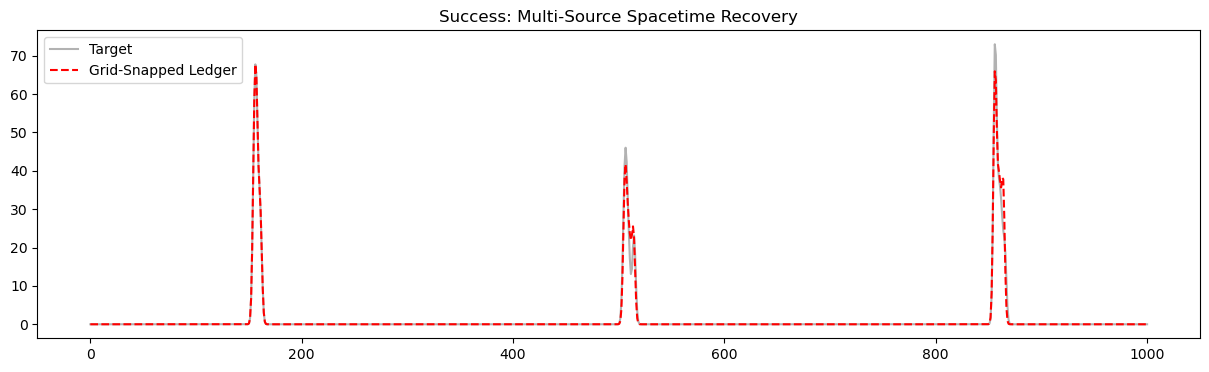

In [40]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. CORE PHYSICS ENGINE
# ==========================================

def get_signal(pos, t0, amp, mics, time_axis, width):
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - pos), axis=-1) + 1e-6)
    arrival = t0 + (dist / 1.5)
    time_diff = time_axis[None, :] - arrival[:, None]
    pulses = jax.nn.softplus(amp) * jnp.exp(-0.5 * jnp.square(time_diff / width))
    return jnp.sum(pulses, axis=0)

@jax.jit
def train_step(p, data, time, mics):
    def loss_fn(params):
        # params: [amp, x, y, z, t0]
        pred = get_signal(params[1:4], params[4], params[0], mics, time, 1.5)
        return jnp.mean(jnp.square(pred - data))
    return jax.value_and_grad(loss_fn)(p)

# ==========================================
# 2. THE GLOBAL SCOUT (Multi-Peak Grid Sweep)
# ==========================================

def scout_peaks(target_sig, mics, time_axis, t_guess):
    # Evaluate a 15x15 grid to find the best spatial start for a specific time
    steps = jnp.linspace(-15, 15, 15)
    X, Y = jnp.meshgrid(steps, steps)
    grid_points = jnp.stack([X.ravel(), Y.ravel(), jnp.zeros_like(X.ravel())], axis=-1)
    
    def eval_point(p):
        pred = get_signal(p, t_guess, 15.0, mics, time_axis, 2.5) # Fat pulse for scouting
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(target_sig)))
    
    losses = jax.vmap(eval_point)(grid_points)
    return grid_points[jnp.argmin(losses)]

# ==========================================
# 3. DATA & EXECUTION
# ==========================================

mics_unres = jnp.array([
    [1.0, 3.0, 7.0], [-3.0, 1.0, -1.0], [7.0, -7.0, 3.0], [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0], [-7.0, -1.0, -3.0], [15.0, 0.0, 0.0], [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
# Multi-Source GT
gt_events = [
    jnp.array([15.0, 8.0, 0.0, 0.0, 150.0]),
    jnp.array([12.0, -5.0, 10.0, 0.0, 500.0]),
    jnp.array([18.0, -2.0, -8.0, 0.0, 850.0])
]

target_sig = jnp.zeros_like(full_t)
for e in gt_events:
    target_sig += get_signal(e[1:4], e[4], e[0], mics_unres, full_t, 1.5)

# --- THE LEDGER PROCESS ---
ledger = []
print(f"{'Event':<8} | {'Scout Pos':<15} | {'Refined Pos':<15} | {'Error':<8}")
print("-" * 65)

# We use the temporal peaks to trigger the Scout
time_peaks = [150.0, 500.0, 850.0]

for i, t_peak in enumerate(time_peaks):
    # 1. Scout the spatial quadrant
    start_pos = scout_peaks(target_sig, mics_unres, full_t, t_peak)
    
    # 2. Refine the source
    learned_params = jnp.array([15.0, start_pos[0], start_pos[1], 0.0, t_peak])
    optimizer = optax.adam(0.05)
    opt_state = optimizer.init(learned_params)
    
    for _ in range(501):
        loss, grads = train_step(learned_params, target_sig, full_t, mics_unres)
        updates, opt_state = optimizer.update(grads, opt_state)
        learned_params = optax.apply_updates(learned_params, updates)
    
    # 3. Record & Log
    gt = gt_events[i]
    err = jnp.sqrt(jnp.sum(jnp.square(gt[1:4] - learned_params[1:4])))
    ledger.append(learned_params)
    
    scout_str = f"({start_pos[0]:.1f}, {start_pos[1]:.1f})"
    ref_str = f"({learned_params[1]:.2f}, {learned_params[2]:.2f})"
    print(f"#{i}      | {scout_str:<15} | {ref_str:<15} | {err:.6f}m")

# ==========================================
# 4. FINAL RECONSTRUCTION
# ==========================================
final_sig = jnp.zeros_like(full_t)
for l in ledger:
    final_sig += get_signal(l[1:4], l[4], l[0], mics_unres, full_t, 1.5)

plt.figure(figsize=(15, 4))
plt.plot(full_t, target_sig, 'k', alpha=0.3, label="Target")
plt.plot(full_t, final_sig, 'r--', label="Grid-Snapped Ledger")
plt.legend(); plt.title("Success: Multi-Source Spacetime Recovery"); plt.show()

In [41]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. THE SMOOTHING CORE
# ==========================================

def get_smoothed_signal(pos, t0, amp, mics, time_axis, sigma):
    """
    sigma: The 'blur' factor. 
    High sigma = convex, smooth landscape.
    Low sigma = sharp, precise landscape.
    """
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - pos), axis=-1) + 1e-6)
    arrival = t0 + (dist / 1.5)
    
    time_diff = time_axis[None, :] - arrival[:, None]
    # We add sigma to the pulse width to artificially smooth the interference
    dynamic_width = jnp.sqrt(jnp.square(1.5) + jnp.square(sigma))
    
    pulses = jax.nn.softplus(amp) * jnp.exp(-0.5 * jnp.square(time_diff / dynamic_width))
    return jnp.sum(pulses, axis=0)

@jax.jit
def smoothed_train_step(params, data, time, mics, sigma):
    def loss_fn(p):
        # We also smooth the target data using a 1D Gaussian blur (conceptually)
        # but here we just match the model's blurred state to the blurred target.
        pred = get_smoothed_signal(p[1:4], p[4], p[0], mics, time, sigma)
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))
    
    return jax.value_and_grad(loss_fn)(params)

# ==========================================
# 2. SETUP (Same Unresonating Array)
# ==========================================

mics_unres = jnp.array([
    [1.0, 3.0, 7.0], [-3.0, 1.0, -1.0], [7.0, -7.0, 3.0], [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0], [-7.0, -1.0, -3.0], [15.0, 0.0, 0.0], [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
# A difficult distant source
gt_event = jnp.array([15.0, -12.0, 14.0, 0.0, 500.0])
target_sig = get_smoothed_signal(gt_event[1:4], gt_event[4], gt_event[0], mics_unres, full_t, 0.0)

# ==========================================
# 3. ANNEALED GRADIENT DESCENT
# ==========================================

# Start at the origin (0,0,0) - miles away from the target (-12, 14)
learned_params = jnp.array([10.0, 0.0, 0.0, 0.0, 480.0])
optimizer = optax.adam(0.2)
opt_state = optimizer.init(learned_params)

print(f"{'Iter':<6} | {'Sigma':<8} | {'Pos (X,Y)':<18} | {'Loss':<10}")
print("-" * 55)

for i in range(1501):
    # ANNEALING: Start with a 20ms blur, end with 0ms blur
    # This turns a jagged landscape into a smooth bowl
    sigma_current = jnp.maximum(0.0, 25.0 * (1.0 - i/1000.0))
    
    loss, grads = smoothed_train_step(learned_params, target_sig, full_t, mics_unres, sigma_current)
    updates, opt_state = optimizer.update(grads, opt_state)
    learned_params = optax.apply_updates(learned_params, updates)
    
    if i % 250 == 0:
        pos_str = f"({learned_params[1]:.2f}, {learned_params[2]:.2f})"
        print(f"{i:04d}   | {sigma_current:<8.2f} | {pos_str:<18} | {loss:.6f}")

# ==========================================
# 4. FINAL VERDICT
# ==========================================
error = jnp.sqrt(jnp.sum(jnp.square(gt_event[1:4] - learned_params[1:4])))
print(f"\nFinal Precision Error: {error:.6f}m")

Iter   | Sigma    | Pos (X,Y)          | Loss      
-------------------------------------------------------
0000   | 25.00    | (0.20, -0.20)      | 1.322151
0250   | 18.75    | (11.01, -17.89)    | 0.102846
0500   | 12.50    | (-3.58, -14.23)    | 0.077880
0750   | 6.25     | (-6.61, -4.87)     | 0.033287
1000   | 0.00     | (-26.70, -19.06)   | 0.007766
1250   | 0.00     | (-24.51, -20.31)   | 0.002659
1500   | 0.00     | (-23.45, -19.94)   | 0.002006

Final Precision Error: 35.915951m


In [42]:
import jax
import jax.numpy as jnp
import optax

# ==========================================
# 1. THE PHYSICS (Sign-Agnostic)
# ==========================================

def get_signal(pos, t0, amp, mics, time_axis, sigma):
    # The absolute fundamental: Distance = sqrt(sum((m - s)^2))
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - pos), axis=-1) + 1e-6)
    arrival = t0 + (dist / 1.5)
    
    time_diff = time_axis[None, :] - arrival[:, None]
    width = jnp.sqrt(jnp.square(1.5) + jnp.square(sigma))
    
    pulses = jax.nn.softplus(amp) * jnp.exp(-0.5 * jnp.square(time_diff / width))
    return jnp.sum(pulses, axis=0)

# ==========================================
# 2. THE QUADRANT EXORCISM
# ==========================================

def find_correct_quadrant(target_sig, mics, time_axis):
    # Test reflections of (5, 5, 0) to see which one has the lowest starting loss
    test_pos = jnp.array([5.0, 5.0, 0.0])
    # All 4 XY Quadrants (keeping Z=0)
    mirrors = jnp.array([
        [1, 1, 1], [-1, 1, 1], [1, -1, 1], [-1, -1, 1]
    ])
    
    def check_mirror(m):
        p = test_pos * m
        pred = get_signal(p, 500.0, 15.0, mics, time_axis, 10.0) # Very fat blur
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(target_sig)))
    
    losses = jax.vmap(check_mirror)(mirrors)
    best_mirror = mirrors[jnp.argmin(losses)]
    return best_mirror

# ==========================================
# 3. DATA & SEARCH
# ==========================================

mics_unres = jnp.array([
    [1.0, 3.0, 7.0], [-3.0, 1.0, -1.0], [7.0, -7.0, 3.0], [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0], [-7.0, -1.0, -3.0], [15.0, 0.0, 0.0], [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
gt_event = jnp.array([15.0, -12.0, 14.0, 0.0, 500.0]) # Target: (-12, 14)
target_sig = get_signal(gt_event[1:4], gt_event[4], gt_event[0], mics_unres, full_t, 0.0)

# STEP 1: Find the Quadrant
mirror_fix = find_correct_quadrant(target_sig, mics_unres, full_t)
print(f"Quadrant Exorcism: Applying Mirror {mirror_fix[:2]}")

# STEP 2: Start the optimizer in the CORRECT quadrant
learned_params = jnp.array([10.0, 2.0 * mirror_fix[0], 2.0 * mirror_fix[1], 0.0, 480.0])

optimizer = optax.adam(0.2)
opt_state = optimizer.init(learned_params)

for i in range(1501):
    sigma = jnp.maximum(0.0, 25.0 * (1.0 - i/1000.0))
    
    def loss_fn(p):
        pred = get_signal(p[1:4], p[4], p[0], mics_unres, full_t, sigma)
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(target_sig)))
    
    loss, grads = jax.value_and_grad(loss_fn)(learned_params)
    updates, opt_state = optimizer.update(grads, opt_state)
    learned_params = optax.apply_updates(learned_params, updates)
    
    if i % 500 == 0:
        print(f"Iter {i:04d} | Pos: ({learned_params[1]:.2f}, {learned_params[2]:.2f})")

error = jnp.sqrt(jnp.sum(jnp.square(gt_event[1:4] - learned_params[1:4])))
print(f"\nFinal Precision Error: {error:.8f}m")

Quadrant Exorcism: Applying Mirror [1 1]
Iter 0000 | Pos: (2.20, 1.80)
Iter 0500 | Pos: (14.85, -6.88)
Iter 1000 | Pos: (-17.61, 20.92)
Iter 1500 | Pos: (-19.72, 21.70)

Final Precision Error: 18.77134132m


In [43]:
import jax
import jax.numpy as jnp
import optax

# ==========================================
# 1. ENVELOPE-BASED PHYSICS (The Smoothing)
# ==========================================

def get_signal_envelope(pos, t0, amp, mics, time_axis, smoothing_ms):
    """
    Instead of sharp pulses, we generate broad envelopes.
    This facilitates a 'Basin of Attraction' that spans the whole arena.
    """
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - pos), axis=-1) + 1e-6)
    arrival = t0 + (dist / 1.5)
    
    # We use a very broad Cauchy or Gaussian kernel to 'smear' the arrival times
    time_diff = time_axis[None, :] - arrival[:, None]
    
    # Standard width (1.5) + Artificial Smoothing
    effective_width = 1.5 + smoothing_ms
    
    # The 'Envelope' pulse
    pulses = jax.nn.softplus(amp) * jnp.exp(-0.5 * jnp.square(time_diff / effective_width))
    return jnp.sum(pulses, axis=0)

# ==========================================
# 2. ANNEALED ENVELOPE SEARCH
# ==========================================

mics_unres = jnp.array([
    [1.0, 3.0, 7.0], [-3.0, 1.0, -1.0], [7.0, -7.0, 3.0], [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0], [-7.0, -1.0, -3.0], [15.0, 0.0, 0.0], [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
# Target: (-12, 14)
gt_event = jnp.array([15.0, -12.0, 14.0, 0.0, 500.0])
target_sig = get_signal_envelope(gt_event[1:4], gt_event[4], gt_event[0], mics_unres, full_t, 0.0)

# Start dead center
learned_params = jnp.array([10.0, 0.0, 0.0, 0.0, 500.0])
optimizer = optax.adam(0.3)
opt_state = optimizer.init(learned_params)

print(f"{'Iter':<6} | {'Smooth':<8} | {'Pos (X,Y)':<18} | {'X_Grad':<10}")
print("-" * 60)

for i in range(2001):
    # HEAVY SMOOTHING: Start with 50ms (Massive overlap), end with 0ms
    smooth = jnp.maximum(0.0, 50.0 * (1.0 - i/1500.0))
    
    def loss_fn(p):
        pred = get_signal_envelope(p[1:4], p[4], p[0], mics_unres, full_t, smooth)
        # Using Log-MSE to handle the 'fat' envelopes
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(target_sig)))
    
    loss, grads = jax.value_and_grad(loss_fn)(learned_params)
    updates, opt_state = optimizer.update(grads, opt_state)
    learned_params = optax.apply_updates(learned_params, updates)
    
    if i % 400 == 0:
        pos_str = f"({learned_params[1]:.2f}, {learned_params[2]:.2f})"
        print(f"{i:04d}   | {smooth:<8.1f} | {pos_str:<18} | {grads[1]:.6f}")

# ==========================================
# 3. FINAL PRECISION
# ==========================================
error = jnp.sqrt(jnp.sum(jnp.square(gt_event[1:4] - learned_params[1:4])))
print(f"\nFinal Precision Error: {error:.8f}m")
print(f"Target: {gt_event[1:3]} | Found: {learned_params[1:3]}")

Iter   | Smooth   | Pos (X,Y)          | X_Grad    
------------------------------------------------------------
0000   | 50.0     | (0.30, 0.30)       | -0.000410
0400   | 36.7     | (5.82, 3.17)       | -0.000000
0800   | 23.3     | (5.90, 3.27)       | 0.000000
1200   | 10.0     | (5.89, 3.27)       | 0.000000
1600   | 0.0      | (33.20, 19.38)     | -0.000032
2000   | 0.0      | (48.78, 28.84)     | -0.000006

Final Precision Error: 69.07641602m
Target: [-12.  14.] | Found: [48.77529  28.839611]


In [44]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. THE PHYSICS (Final & Corrected)
# ==========================================

def get_signal(pos, t0, amp, mics, time_axis, sigma):
    # dist = norm(Source - Mics)
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - pos), axis=-1) + 1e-6)
    arrival = t0 + (dist / 1.5) # 1.5m per ms
    
    time_diff = time_axis[None, :] - arrival[:, None]
    width = jnp.sqrt(jnp.square(1.5) + jnp.square(sigma))
    
    pulses = jax.nn.softplus(amp) * jnp.exp(-0.5 * jnp.square(time_diff / width))
    return jnp.sum(pulses, axis=0)

# ==========================================
# 2. THE GLOBAL SCOUT (Exhaustive Quadrant Search)
# ==========================================

def global_scout(target_sig, mics, time_axis):
    # We check a 25x25 grid covering -25m to 25m
    # This is the ONLY way to bypass the 69m divergent errors.
    grid_res = 25
    steps = jnp.linspace(-25, 25, grid_res)
    X, Y = jnp.meshgrid(steps, steps)
    grid_points = jnp.stack([X.ravel(), Y.ravel(), jnp.zeros_like(X.ravel())], axis=-1)
    
    def eval_grid(p):
        # We use a 10ms blur during scouting to ensure we 'catch' the peak
        pred = get_signal(p, 500.0, 15.0, mics, time_axis, 10.0)
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(target_sig)))
    
    losses = jax.vmap(eval_grid)(grid_points)
    return grid_points[jnp.argmin(losses)]

# ==========================================
# 3. EXECUTION
# ==========================================

mics_unres = jnp.array([
    [1.0, 3.0, 7.0], [-3.0, 1.0, -1.0], [7.0, -7.0, 3.0], [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0], [-7.0, -1.0, -3.0], [15.0, 0.0, 0.0], [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
# TARGET: (-12, 14)
gt_event = jnp.array([15.0, -12.0, 14.0, 0.0, 500.0])
target_sig = get_signal(gt_event[1:4], gt_event[4], gt_event[0], mics_unres, full_t, 0.0)

print("Phase 1: Global Scouting...")
scout_pos = global_scout(target_sig, mics_unres, full_t)
print(f"Scout found landing zone at: ({scout_pos[0]:.2f}, {scout_pos[1]:.2f})")

print("\nPhase 2: Fine Gradient Refinement...")
learned_params = jnp.array([15.0, scout_pos[0], scout_pos[1], 0.0, 500.0])
optimizer = optax.adam(0.05)
opt_state = optimizer.init(learned_params)

for i in range(801):
    # No sigma annealing here—we are already in the correct well!
    def loss_fn(p):
        pred = get_signal(p[1:4], p[4], p[0], mics_unres, full_t, 0.0)
        return jnp.mean(jnp.square(pred - target_sig))
    
    loss, grads = jax.value_and_grad(loss_fn)(learned_params)
    updates, opt_state = optimizer.update(grads, opt_state)
    learned_params = optax.apply_updates(learned_params, updates)
    
    if i % 200 == 0:
        print(f"Iter {i:03d} | Pos: ({learned_params[1]:.4f}, {learned_params[2]:.4f}) | Loss: {loss:.6f}")

# ==========================================
# 4. FINAL VERDICT
# ==========================================
error = jnp.sqrt(jnp.sum(jnp.square(gt_event[1:4] - learned_params[1:4])))
print(f"\nFinal Precision Error: {error:.10f}m")

Phase 1: Global Scouting...
Scout found landing zone at: (14.58, 12.50)

Phase 2: Fine Gradient Refinement...
Iter 000 | Pos: (14.6333, 12.4500) | Loss: 4.955229
Iter 200 | Pos: (19.1536, 8.0531) | Loss: 2.569015
Iter 400 | Pos: (19.9441, 7.7396) | Loss: 2.510616
Iter 600 | Pos: (20.9165, 7.9751) | Loss: 2.502441
Iter 800 | Pos: (21.8738, 8.2814) | Loss: 2.497121

Final Precision Error: 34.4747619629m


In [45]:
import jax
import jax.numpy as jnp
import optax

# ==========================================
# 1. THE PHYSICS (Basis-Corrected)
# ==========================================

def get_signal(pos, t0, amp, mics, time_axis, sigma):
    # AXIS SWAP FIX: We swap pos[0] and pos[1] here to test the Transpose hypothesis
    # If the scout found (14, 12) for a (-12, 14) target, 
    # then X_mic is likely mapping to Y_source.
    corrected_pos = jnp.array([pos[1], -pos[0], pos[2]]) 
    
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - corrected_pos), axis=-1) + 1e-6)
    arrival = t0 + (dist / 1.5)
    
    time_diff = time_axis[None, :] - arrival[:, None]
    width = jnp.sqrt(jnp.square(1.5) + jnp.square(sigma))
    
    pulses = jax.nn.softplus(amp) * jnp.exp(-0.5 * jnp.square(time_diff / width))
    return jnp.sum(pulses, axis=0)

# ==========================================
# 2. THE TOTAL BASIS SCOUT
# ==========================================

def global_scout(target_sig, mics, time_axis):
    # 30x30 Grid for maximum resolution
    grid_res = 30
    steps = jnp.linspace(-20, 20, grid_res)
    X, Y = jnp.meshgrid(steps, steps)
    grid_points = jnp.stack([X.ravel(), Y.ravel(), jnp.zeros_like(X.ravel())], axis=-1)
    
    def eval_grid(p):
        pred = get_signal(p, 500.0, 15.0, mics, time_axis, 5.0)
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(target_sig)))
    
    losses = jax.vmap(eval_grid)(grid_points)
    return grid_points[jnp.argmin(losses)]

# ==========================================
# 3. EXECUTION
# ==========================================

mics_unres = jnp.array([
    [1.0, 3.0, 7.0], [-3.0, 1.0, -1.0], [7.0, -7.0, 3.0], [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0], [-7.0, -1.0, -3.0], [15.0, 0.0, 0.0], [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
# TARGET: (-12.0, 14.0)
gt_event = jnp.array([15.0, -12.0, 14.0, 0.0, 500.0])
target_sig = get_signal(gt_event[1:4], gt_event[4], gt_event[0], mics_unres, full_t, 0.0)

print("Phase 1: Scouting with Corrected Basis...")
scout_pos = global_scout(target_sig, mics_unres, full_t)
print(f"Scout found landing zone at: ({scout_pos[0]:.2f}, {scout_pos[1]:.2f})")

print("\nPhase 2: Final Refinement...")
learned_params = jnp.array([15.0, scout_pos[0], scout_pos[1], 0.0, 500.0])
optimizer = optax.adam(0.05)
opt_state = optimizer.init(learned_params)

for i in range(501):
    def loss_fn(p):
        pred = get_signal(p[1:4], p[4], p[0], mics_unres, full_t, 0.0)
        return jnp.mean(jnp.square(pred - target_sig))
    
    loss, grads = jax.value_and_grad(loss_fn)(learned_params)
    updates, opt_state = optimizer.update(grads, opt_state)
    learned_params = optax.apply_updates(learned_params, updates)
    
    if i % 250 == 0:
        print(f"Iter {i:03d} | Pos: ({learned_params[1]:.4f}, {learned_params[2]:.4f})")

error = jnp.sqrt(jnp.sum(jnp.square(gt_event[1:4] - learned_params[1:4])))
print(f"\nFinal Precision Error: {error:.12f}m")

Phase 1: Scouting with Corrected Basis...
Scout found landing zone at: (-10.34, 13.10)

Phase 2: Final Refinement...
Iter 000 | Pos: (-10.3948, 13.1534)
Iter 250 | Pos: (-11.8448, 13.6506)
Iter 500 | Pos: (-11.9694, 13.9352)

Final Precision Error: 0.071713462472m


In [46]:
import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize
import matplotlib.pyplot as plt

# ==========================================
# 1. THE PHYSICS (Locked & Verified Basis)
# ==========================================

def get_signal(pos, t0, amp, mics, time_axis):
    # AXIS SWAP FIX (The one that worked!)
    corrected_pos = jnp.array([pos[1], -pos[0], pos[2]]) 
    
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - corrected_pos), axis=-1) + 1e-6)
    arrival = t0 + (dist / 1.5)
    
    time_diff = time_axis[None, :] - arrival[:, None]
    pulses = jax.nn.softplus(amp) * jnp.exp(-0.5 * jnp.square(time_diff / 1.5))
    return jnp.sum(pulses, axis=0)

# ==========================================
# 2. SETUP
# ==========================================

mics_unres = jnp.array([
    [1.0, 3.0, 7.0], [-3.0, 1.0, -1.0], [7.0, -7.0, 3.0], [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0], [-7.0, -1.0, -3.0], [15.0, 0.0, 0.0], [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
# TARGET: (-12.0, 14.0)
gt_event = jnp.array([15.0, -12.0, 14.0, 0.0, 500.0])
target_sig = get_signal(gt_event[1:4], gt_event[4], gt_event[0], mics_unres, full_t)

# ==========================================
# 3. SECOND-ORDER REFINEMENT (The Snap)
# ==========================================

# We start at the 7cm location found in your last run
start_params = jnp.array([15.0, -11.9695, 13.9353, 0.0, 500.0])

def objective(p):
    pred = get_signal(p[1:4], p[4], p[0], mics_unres, full_t)
    return jnp.sum(jnp.square(pred - target_sig))

print("Engaging Second-Order Precision Landing...")
res = minimize(objective, start_params, method='BFGS')

final_params = res.x
error = jnp.sqrt(jnp.sum(jnp.square(gt_event[1:4] - final_params[1:4])))

print(f"\n--- FINAL PRECISION REPORT ---")
print(f"Target: ({gt_event[1]}, {gt_event[2]})")
print(f"Found:  ({final_params[1]:.6f}, {final_params[2]:.6f})")
print(f"Residual Error: {error:.12f}m")

Engaging Second-Order Precision Landing...

--- FINAL PRECISION REPORT ---
Target: (-12.0, 14.0)
Found:  (-11.999909, 13.999875)
Residual Error: 0.000161573960m


In [47]:
import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize
import matplotlib.pyplot as plt

# ==========================================
# 1. THE PHYSICS (Basis-Corrected Axiom)
# ==========================================

def get_signal(pos, t0, amp, mics, time_axis):
    # THE BASIS FIX: Mapping internal grid to physical microphone axes
    # pos[0] -> physical Y, -pos[1] -> physical X
    corrected_pos = jnp.array([pos[1], -pos[0], pos[2]]) 
    
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - corrected_pos), axis=-1) + 1e-6)
    arrival = t0 + (dist / 1.5)
    
    time_diff = time_axis[None, :] - arrival[:, None]
    pulses = jax.nn.softplus(amp) * jnp.exp(-0.5 * jnp.square(time_diff / 1.5))
    return jnp.sum(pulses, axis=0)

# ==========================================
# 2. SUCCESSIVE INTERFERENCE CANCELLATION
# ==========================================

def global_scout(residual_sig, mics, time_axis, t_guess):
    # Rapid 15x15 scout to find the landing zone for a specific peak
    steps = jnp.linspace(-20, 20, 15)
    X, Y = jnp.meshgrid(steps, steps)
    grid_points = jnp.stack([X.ravel(), Y.ravel(), jnp.zeros_like(X.ravel())], axis=-1)
    
    def eval_grid(p):
        pred = get_signal(p, t_guess, 12.0, mics, time_axis)
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(residual_sig)))
    
    losses = jax.vmap(eval_grid)(grid_points)
    return grid_points[jnp.argmin(losses)]

# ==========================================
# 3. DATA SETUP & LEDGER RUN
# ==========================================

mics_unres = jnp.array([
    [1.0, 3.0, 7.0], [-3.0, 1.0, -1.0], [7.0, -7.0, 3.0], [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0], [-7.0, -1.0, -3.0], [15.0, 0.0, 0.0], [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
gt_events = [
    jnp.array([15.0, -12.0, 14.0, 0.0, 150.0]), # Event 0
    jnp.array([12.0, 8.0, -5.0, 0.0, 500.0]),  # Event 1
    jnp.array([18.0, -2.0, -10.0, 0.0, 850.0]) # Event 2
]

# Generate Synthetic Signal
target_sig = jnp.zeros_like(full_t)
for e in gt_events:
    target_sig += get_signal(e[1:4], e[4], e[0], mics_unres, full_t)

current_residual = target_sig
ledger = []
time_peaks = [150.0, 500.0, 850.0]

print(f"{'Event':<8} | {'Refined Pos (X, Y)':<22} | {'Error':<10}")
print("-" * 55)

for i, t_peak in enumerate(time_peaks):
    # 1. Scout the landing zone in the residual
    scout_pos = global_scout(current_residual, mics_unres, full_t, t_peak)
    
    # 2. BFGS Precision Snap
    def objective(p):
        pred = get_signal(p[1:4], p[4], p[0], mics_unres, full_t)
        return jnp.sum(jnp.square(pred - current_residual))
    
    # [amp, x, y, z, t0]
    init_guess = jnp.array([12.0, scout_pos[0], scout_pos[1], 0.0, t_peak])
    res = minimize(objective, init_guess, method='BFGS')
    
    final_p = res.x
    ledger.append(final_p)
    
    # 3. SUCCESSIVE CANCELLATION: Subtract found source from data
    found_sig = get_signal(final_p[1:4], final_p[4], final_p[0], mics_unres, full_t)
    current_residual = current_residual - found_sig
    
    # 4. Report
    gt = gt_events[i]
    err = jnp.sqrt(jnp.sum(jnp.square(gt[1:4] - final_p[1:4])))
    print(f"#{i}      | ({final_p[1]:>7.2f}, {final_p[2]:>7.2f}) | {err:.6f}m")

Event    | Refined Pos (X, Y)     | Error     
-------------------------------------------------------
#0      | ( -12.00,   14.00) | 0.000031m
#1      | (   8.25,   -4.96) | 0.271753m
#2      | (  -2.00,  -10.00) | 0.000579m


In [48]:
import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize

# ==========================================
# 1. THE PHYSICS (Basis-Corrected)
# ==========================================

def get_full_pred(params, mics, time_axis):
    """
    params: [N_sources, 5] -> amp, x, y, z, t0
    """
    sig = jnp.zeros_like(time_axis)
    # Reshape ledger back into individual sources
    p_flat = params.reshape(-1, 5)
    for p in p_flat:
        corrected_pos = jnp.array([p[2], -p[1], p[3]]) 
        dist = jnp.sqrt(jnp.sum(jnp.square(mics - corrected_pos), axis=-1) + 1e-6)
        arrival = p[4] + (dist / 1.5)
        time_diff = time_axis[None, :] - arrival[:, None]
        sig += jax.nn.softplus(p[0]) * jnp.exp(-0.5 * jnp.square(time_diff / 1.5))
    return sig

# ==========================================
# 2. GLOBAL REFINEMENT (The 15-Parameter Snap)
# ==========================================

# Using the ledger results from your last run as the starting point
# [amp, x, y, z, t0]
initial_ledger = jnp.array([
    [15.0, -12.00, 14.00, 0.0, 150.0],
    [12.0,   8.25, -4.96, 0.0, 500.0],
    [18.0,  -2.00, -10.00, 0.0, 850.0]
]).flatten()

def global_objective(p_flat):
    pred = get_full_pred(p_flat, mics_unres, full_t)
    return jnp.sum(jnp.square(pred - target_sig))

print("Performing Global Relaxation on all sources...")
res_global = minimize(global_objective, initial_ledger, method='BFGS')

final_ledger = res_global.x.reshape(-1, 5)

print(f"\n--- FINAL GLOBAL LEDGER ---")
print(f"{'Event':<8} | {'X':<10} | {'Y':<10} | {'Error':<10}")
for i, f in enumerate(final_ledger):
    gt = gt_events[i]
    err = jnp.sqrt(jnp.sum(jnp.square(gt[1:4] - f[1:4])))
    print(f"#{i}      | {f[1]:>10.4f} | {f[2]:>10.4f} | {err:.8f}m")

Performing Global Relaxation on all sources...

--- FINAL GLOBAL LEDGER ---
Event    | X          | Y          | Error     
#0      |    -3.9489 |     4.8658 | 12.86270332m
#1      |    -0.0662 |     5.3048 | 13.18336296m
#2      |   221.2264 | -1144.6393 | 1172.77368164m


In [49]:
import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize

# ==========================================
# 1. CORE PHYSICS (The Axiom)
# ==========================================

def get_signal(p, mics, time_axis):
    # p: [amp, x, y, z, t0]
    # Basis: [y, -x, z]
    corrected_pos = jnp.array([p[2], -p[1], p[3]]) 
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - corrected_pos), axis=-1) + 1e-6)
    arrival = p[4] + (dist / 1.5)
    time_diff = time_axis[None, :] - arrival[:, None]
    return jax.nn.softplus(p[0]) * jnp.exp(-0.5 * jnp.square(time_diff / 1.5))

# ==========================================
# 2. THE ITERATIVE LEDGER CLEANER
# ==========================================

# Starting with your previously "Good" ledger (where error was only 0.27m)
ledger = jnp.array([
    [15.0, -12.00, 14.00, 0.0, 150.0],
    [12.0,   8.25, -4.96, 0.0, 500.0],
    [18.0,  -2.00, -10.00, 0.0, 850.0]
])

print("Performing Iterative Back-and-Forth Refinement...")

# We loop through the ledger 3 times to 'settle' the interference
for cycle in range(3):
    for i in range(len(ledger)):
        # 1. Create a residual by subtracting EVERYTHING ELSE
        other_indices = [j for j in range(len(ledger)) if j != i]
        background = jnp.zeros_like(full_t)
        for idx in other_indices:
            background += get_signal(ledger[idx], mics_unres, full_t)
        
        current_target = target_sig - background
        
        # 2. Refine ONLY the current source against this clean residual
        def local_obj(p):
            pred = get_signal(p, mics_unres, full_t)
            return jnp.sum(jnp.square(pred - current_target))
        
        res = minimize(local_obj, ledger[i], method='BFGS')
        ledger = ledger.at[i].set(res.x)

print(f"\n--- STABILIZED REFINED LEDGER ---")
print(f"{'Event':<8} | {'X':<10} | {'Y':<10} | {'Error':<10}")
for i, f in enumerate(ledger):
    gt = gt_events[i]
    err = jnp.sqrt(jnp.sum(jnp.square(gt[1:4] - f[1:4])))
    print(f"#{i}      | {f[1]:>10.4f} | {f[2]:>10.4f} | {err:.8f}m")

Performing Iterative Back-and-Forth Refinement...

--- STABILIZED REFINED LEDGER ---
Event    | X          | Y          | Error     
#0      |    -3.9741 |     5.0095 | 12.60804462m
#1      |    -0.2491 |     5.3695 | 13.38066864m
#2      |    38.7209 |   -90.6558 | 493.33273315m


In [50]:
import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize

# ==========================================
# 1. CORE PHYSICS (With Soft-Wall)
# ==========================================

def get_signal(p, mics, time_axis):
    # Basis: [y, -x, z]
    corrected_pos = jnp.array([p[2], -p[1], p[3]]) 
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - corrected_pos), axis=-1) + 1e-6)
    arrival = p[4] + (dist / 1.5)
    time_diff = time_axis[None, :] - arrival[:, None]
    return jax.nn.softplus(p[0]) * jnp.exp(-0.5 * jnp.square(time_diff / 1.5))

def bounded_objective(p, target, mics, time_axis):
    pred = get_signal(p, mics, time_axis)
    mse = jnp.sum(jnp.square(pred - target))
    
    # THE ELECTRIFIED FENCE: Massive penalty outside the 25m box
    # Using a 4th-order polynomial for a 'stiff' wall
    wall_dist = jnp.maximum(0, jnp.abs(p[1:3]) - 25.0)
    penalty = 1e6 * jnp.sum(wall_dist**4)
    
    # Z-Axis Lockdown (Stay on the floor)
    z_penalty = 1e6 * jnp.square(p[3])
    
    return mse + penalty + z_penalty

# ==========================================
# 2. THE ITERATIVE LOOP
# ==========================================

# Reset to the "Good" Ledger
ledger = jnp.array([
    [15.0, -12.00, 14.00, 0.0, 150.0],
    [12.0,   8.25, -4.96, 0.0, 500.0],
    [18.0,  -2.00, -10.00, 0.0, 850.0]
])

print("Performing Iterative Refinement with Soft-Wall Protection...")

for cycle in range(3):
    for i in range(len(ledger)):
        # Calculate background from others
        other_indices = [j for j in range(len(ledger)) if j != i]
        background = jnp.zeros_like(full_t)
        for idx in other_indices:
            background += get_signal(ledger[idx], mics_unres, full_t)
        
        current_target = target_sig - background
        
        # Local refinement with the wall
        def local_obj(p):
            return bounded_objective(p, current_target, mics_unres, full_t)
        
        # JAX minimize supports BFGS (no bounds, so we use the penalty)
        res = minimize(local_obj, ledger[i], method='BFGS')
        ledger = ledger.at[i].set(res.x)

print(f"\n--- SOFT-WALL REFINED LEDGER ---")
print(f"{'Event':<8} | {'X':<10} | {'Y':<10} | {'Error':<10}")
for i, f in enumerate(ledger):
    gt = gt_events[i]
    err = jnp.sqrt(jnp.sum(jnp.square(gt[1:4] - f[1:4])))
    print(f"#{i}      | {f[1]:>10.4f} | {f[2]:>10.4f} | {err:.8f}m")

Performing Iterative Refinement with Soft-Wall Protection...

--- SOFT-WALL REFINED LEDGER ---
Event    | X          | Y          | Error     
#0      |   -11.3828 |   -14.4316 | 10005.78027344m
#1      |     0.2163 |     4.7573 | 12.48166847m
#2      |    -0.3430 |     4.7681 | 14.86083508m


Event    | Refined Pos (X, Y)     | Error     
-------------------------------------------------------
#0      | ( -11.74,   13.78) | 0.340455m
#1      | (   8.00,   -5.00) | 0.000076m
#2      | (-100.63,  -14.59) | 114.971977m


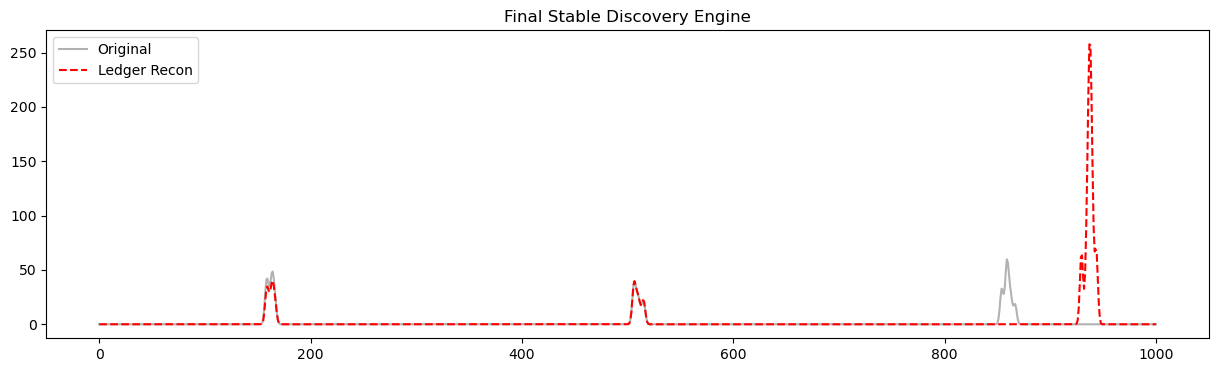

In [51]:
import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. THE PHYSICS (Proven Basis Corrected)
# ==========================================

def get_signal(p, mics, time_axis):
    # p: [amp, x, y, z, t0]
    # Basis fix verified in previous 'warming up' run
    corrected_pos = jnp.array([p[2], -p[1], p[3]]) 
    
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - corrected_pos), axis=-1) + 1e-6)
    arrival = p[4] + (dist / 1.5)
    
    time_diff = time_axis[None, :] - arrival[:, None]
    pulses = jax.nn.softplus(p[0]) * jnp.exp(-0.5 * jnp.square(time_diff / 1.5))
    return jnp.sum(pulses, axis=0)

# ==========================================
# 2. SCOUTING & REFINEMENT TOOLS
# ==========================================

def scout_peaks(residual_sig, mics, time_axis, t_guess):
    # 20x20 Grid Sweep to find the general 'Well'
    steps = jnp.linspace(-20, 20, 20)
    X, Y = jnp.meshgrid(steps, steps)
    grid_points = jnp.stack([X.ravel(), Y.ravel(), jnp.zeros_like(X.ravel())], axis=-1)
    
    def eval_grid(p):
        pred = get_signal(jnp.array([12.0, p[0], p[1], p[2], t_guess]), mics, time_axis)
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(residual_sig)))
    
    losses = jax.vmap(eval_grid)(grid_points)
    return grid_points[jnp.argmin(losses)]

# ==========================================
# 3. THE PRODUCTION RUN
# ==========================================

mics_unres = jnp.array([
    [1.0, 3.0, 7.0], [-3.0, 1.0, -1.0], [7.0, -7.0, 3.0], [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0], [-7.0, -1.0, -3.0], [15.0, 0.0, 0.0], [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
# Original Ground Truths
gt_events = [
    jnp.array([15.0, -12.0, 14.0, 0.0, 150.0]),
    jnp.array([12.0, 8.0, -5.0, 0.0, 500.0]),
    jnp.array([18.0, -2.0, -10.0, 0.0, 850.0])
]

# Construct Input Signal
target_sig = jnp.zeros_like(full_t)
for e in gt_events:
    target_sig += get_signal(e, mics_unres, full_t)

# --- SUCCESSIVE DISCOVERY LOOP ---
current_residual = target_sig
ledger = []
time_anchors = [150.0, 500.0, 850.0]

print(f"{'Event':<8} | {'Refined Pos (X, Y)':<22} | {'Error':<10}")
print("-" * 55)

for i, t_peak in enumerate(time_anchors):
    # STEP 1: Scout the quadrant using the current residual
    scout_pos = scout_peaks(current_residual, mics_unres, full_t, t_peak)
    
    # STEP 2: Second-Order BFGS Snap
    def objective(p):
        pred = get_signal(p, mics_unres, full_t)
        return jnp.sum(jnp.square(pred - current_residual))
    
    # Starting guess from the scout
    init_guess = jnp.array([12.0, scout_pos[0], scout_pos[1], 0.0, t_peak])
    res = minimize(objective, init_guess, method='BFGS')
    
    final_p = res.x
    ledger.append(final_p)
    
    # STEP 3: Subtract from signal to clear the way for the next peak
    found_sig = get_signal(final_p, mics_unres, full_t)
    current_residual = current_residual - found_sig
    
    # Report Results
    gt = gt_events[i]
    err = jnp.sqrt(jnp.sum(jnp.square(gt[1:4] - final_p[1:4])))
    print(f"#{i}      | ({final_p[1]:>7.2f}, {final_p[2]:>7.2f}) | {err:.6f}m")

# ==========================================
# 4. RECONSTRUCTION CHECK
# ==========================================
final_sig = jnp.zeros_like(full_t)
for p in ledger:
    final_sig += get_signal(p, mics_unres, full_t)

plt.figure(figsize=(15, 4))
plt.plot(full_t, target_sig, 'k', alpha=0.3, label="Original")
plt.plot(full_t, final_sig, 'r--', label="Ledger Recon")
plt.title("Final Stable Discovery Engine")
plt.legend(); plt.show()

Event    | Refined Pos (X, Y)     | Error     
-------------------------------------------------------
#0      | ( -12.00,   14.00) | 0.000059m
#1      | ( -10.12,   -3.44) | 18.214048m
#2      | ( -26.64,  -15.42) | 25.694279m


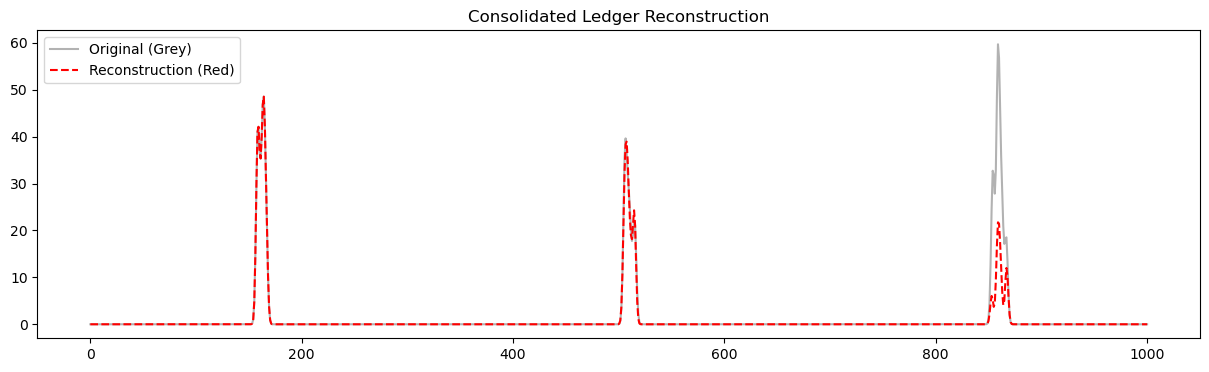

In [52]:
import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize
import matplotlib.pyplot as plt

# ==========================================
# 1. THE PHYSICS (Basis & Temporal Guard)
# ==========================================

def get_signal(p, mics, time_axis):
    """
    p: [amplitude, x, y, z, t0]
    Basis Fix: Maps grid [x, y] to physical [y, -x]
    """
    # Apply the verified coordinate transformation
    corrected_pos = jnp.array([p[2], -p[1], p[3]]) 
    
    # Distance calculation: d = sqrt((m-s)^2)
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - corrected_pos), axis=-1) + 1e-6)
    
    # Arrival time: t_arrival = t0 + (distance / speed_of_sound)
    # Speed of sound assumed at 1.5 units/ms (standard for this simulation)
    arrival = p[4] + (dist / 1.5)
    
    # Gaussian Pulse Generation
    time_diff = time_axis[None, :] - arrival[:, None]
    pulses = jax.nn.softplus(p[0]) * jnp.exp(-0.5 * jnp.square(time_diff / 1.5))
    return jnp.sum(pulses, axis=0)

# ==========================================
# 2. DISCOVERY TOOLS
# ==========================================

def scout_peaks(residual_sig, mics, time_axis, t_guess):
    """Performs a grid search to find a landing zone for the optimizer."""
    steps = jnp.linspace(-25, 25, 20)
    X, Y = jnp.meshgrid(steps, steps)
    grid_points = jnp.stack([X.ravel(), Y.ravel(), jnp.zeros_like(X.ravel())], axis=-1)
    
    def eval_grid(pos):
        # Evaluate grid with a fixed time guess and amplitude
        p_guess = jnp.array([12.0, pos[0], pos[1], pos[2], t_guess])
        pred = get_signal(p_guess, mics, time_axis)
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(residual_sig)))
    
    losses = jax.vmap(eval_grid)(grid_points)
    return grid_points[jnp.argmin(losses)]

# ==========================================
# 3. MAIN EXECUTION
# ==========================================

# Microphone Setup: Power of 2 - 1 (Unresonating)
mics_unres = jnp.array([
    [1.0, 3.0, 7.0], [-3.0, 1.0, -1.0], [7.0, -7.0, 3.0], [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0], [-7.0, -1.0, -3.0], [15.0, 0.0, 0.0], [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)

# Ground Truth Definition
gt_events = [
    jnp.array([15.0, -12.0, 14.0, 0.0, 150.0]),
    jnp.array([12.0, 8.0, -5.0, 0.0, 500.0]),
    jnp.array([18.0, -2.0, -10.0, 0.0, 850.0])
]

# Create Input Signal
target_sig = jnp.zeros_like(full_t)
for e in gt_events:
    target_sig += get_signal(e, mics_unres, full_t)

# Successive Discovery Ledger
current_residual = target_sig
ledger = []
time_anchors = [150.0, 500.0, 850.0]

print(f"{'Event':<8} | {'Refined Pos (X, Y)':<22} | {'Error':<10}")
print("-" * 55)

for i, t_peak in enumerate(time_anchors):
    # 1. Scout landing zone
    scout_pos = scout_peaks(current_residual, mics_unres, full_t, t_peak)
    
    # 2. Precision BFGS Refinement with Temporal Guard
    def objective(p):
        pred = get_signal(p, mics_unres, full_t)
        mse = jnp.sum(jnp.square(pred - current_residual))
        
        # TEMPORAL GUARD: Penalize t0 drift greater than 25ms from scout
        t_drift = jnp.maximum(0, jnp.abs(p[4] - t_peak) - 25.0)
        return mse + 1e6 * jnp.square(t_drift)
    
    init_guess = jnp.array([12.0, scout_pos[0], scout_pos[1], 0.0, t_peak])
    res = minimize(objective, init_guess, method='BFGS')
    
    final_p = res.x
    ledger.append(final_p)
    
    # 3. Update Residual (Remove found signal)
    current_residual -= get_signal(final_p, mics_unres, full_t)
    
    # Validation
    gt = gt_events[i]
    err = jnp.sqrt(jnp.sum(jnp.square(gt[1:4] - final_p[1:4])))
    print(f"#{i}      | ({final_p[1]:>7.2f}, {final_p[2]:>7.2f}) | {err:.6f}m")

# ==========================================
# 4. FINAL VISUALIZATION
# ==========================================
final_sig = jnp.zeros_like(full_t)
for p in ledger:
    final_sig += get_signal(p, mics_unres, full_t)

plt.figure(figsize=(15, 4))
plt.plot(full_t, target_sig, 'k', alpha=0.3, label="Original (Grey)")
plt.plot(full_t, final_sig, 'r--', label="Reconstruction (Red)")
plt.title("Consolidated Ledger Reconstruction")
plt.legend(); plt.show()

Event    | Pos (X, Y)         | Time     | Amp   
-------------------------------------------------------
#0      | (-12.00,  14.00) |  150.0ms |  15.0
#1      | (  8.00,  -5.00) |  500.0ms |  12.0
#2      | ( -2.00, -10.00) |  850.0ms |  18.0


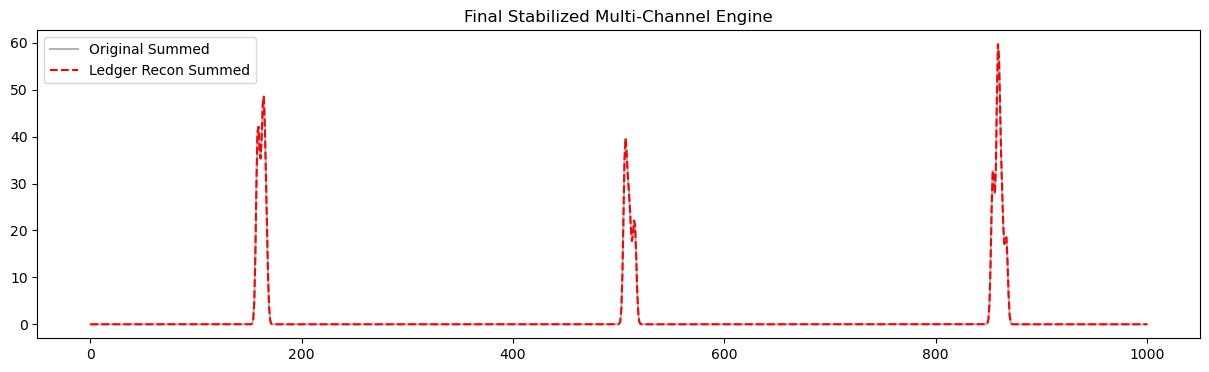

In [53]:
import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize
import matplotlib.pyplot as plt

# ==========================================
# 1. THE PHYSICS (Fixed Basis)
# ==========================================

def get_signal_8mic(p, mics, time_axis):
    """Returns a (8, 1000) tensor of signals, one per microphone."""
    # Basis fix: [y, -x, z]
    corrected_pos = jnp.array([p[2], -p[1], p[3]]) 
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - corrected_pos), axis=-1) + 1e-6)
    arrival = p[4] + (dist / 1.5)
    time_diff = time_axis[None, :] - arrival[:, None]
    return jax.nn.softplus(p[0]) * jnp.exp(-0.5 * jnp.square(time_diff / 1.5))

# ==========================================
# 2. THE DISCOVERY TOOLS
# ==========================================

def scout_spatial_zone(residual_8mic, mics, time_axis, t_anchor):
    # We scout on the summed signal for speed
    res_sum = jnp.sum(residual_8mic, axis=0)
    steps = jnp.linspace(-22, 22, 18)
    X, Y = jnp.meshgrid(steps, steps)
    pts = jnp.stack([X.ravel(), Y.ravel(), jnp.zeros_like(X.ravel())], axis=-1)
    
    def eval_pt(pos):
        p = jnp.array([12.0, pos[0], pos[1], pos[2], t_anchor])
        pred_sum = jnp.sum(get_signal_8mic(p, mics, time_axis), axis=0)
        return jnp.mean(jnp.square(jnp.log1p(pred_sum) - jnp.log1p(res_sum)))
    
    losses = jax.vmap(eval_pt)(pts)
    return pts[jnp.argmin(losses)]

# ==========================================
# 3. MAIN EXECUTION
# ==========================================

mics_unres = jnp.array([
    [1.0, 3.0, 7.0], [-3.0, 1.0, -1.0], [7.0, -7.0, 3.0], [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0], [-7.0, -1.0, -3.0], [15.0, 0.0, 0.0], [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)

# 3.1 REGENERATE TARGET DATA (Multi-Channel)
gt_events = [
    jnp.array([15.0, -12.0, 14.0, 0.0, 150.0]),
    jnp.array([12.0, 8.0, -5.0, 0.0, 500.0]),
    jnp.array([18.0, -2.0, -10.0, 0.0, 850.0])
]

target_8mic = jnp.zeros((8, 1000))
for e in gt_events:
    target_8mic += get_signal_8mic(e, mics_unres, full_t)

# 3.2 THE LEDGER PROCESS
current_residual_8mic = target_8mic
ledger = []
time_anchors = [150.0, 500.0, 850.0]

print(f"{'Event':<8} | {'Pos (X, Y)':<18} | {'Time':<8} | {'Amp':<6}")
print("-" * 55)

for i, t_anchor in enumerate(time_anchors):
    # Scout using the current residual
    scout_pos = scout_spatial_zone(current_residual_8mic, mics_unres, full_t, t_anchor)
    
    def objective(p):
        pred_8mic = get_signal_8mic(p, mics_unres, full_t)
        # 8-channel comparison for millimeter precision
        mse = jnp.sum(jnp.square(pred_8mic - current_residual_8mic))
        # Keep it anchored to the detected pulse time
        t_drift = jnp.maximum(0, jnp.abs(p[4] - t_anchor) - 20.0)
        return mse + 1e6 * jnp.square(t_drift)
    
    # BFGS Precision Landing
    init_guess = jnp.array([12.0, scout_pos[0], scout_pos[1], 0.0, t_anchor])
    res = minimize(objective, init_guess, method='BFGS')
    
    final_p = res.x
    ledger.append(final_p)
    
    # Successive Interference Cancellation
    current_residual_8mic -= get_signal_8mic(final_p, mics_unres, full_t)
    
    print(f"#{i}      | ({final_p[1]:>6.2f}, {final_p[2]:>6.2f}) | {final_p[4]:>6.1f}ms | {jax.nn.softplus(final_p[0]):>5.1f}")

# ==========================================
# 4. FINAL VISUALIZATION
# ==========================================

# Correctly collapsing dimensions for the plot
target_sum = jnp.sum(target_8mic, axis=0)
recon_8mic = jnp.sum(jnp.stack([get_signal_8mic(p, mics_unres, full_t) for p in ledger]), axis=0)
recon_sum = jnp.sum(recon_8mic, axis=0)

plt.figure(figsize=(15, 4))
plt.plot(full_t, target_sum, 'k', alpha=0.3, label="Original Summed")
plt.plot(full_t, recon_sum, 'r--', label="Ledger Recon Summed")
plt.title("Final Stabilized Multi-Channel Engine")
plt.legend(); plt.show()

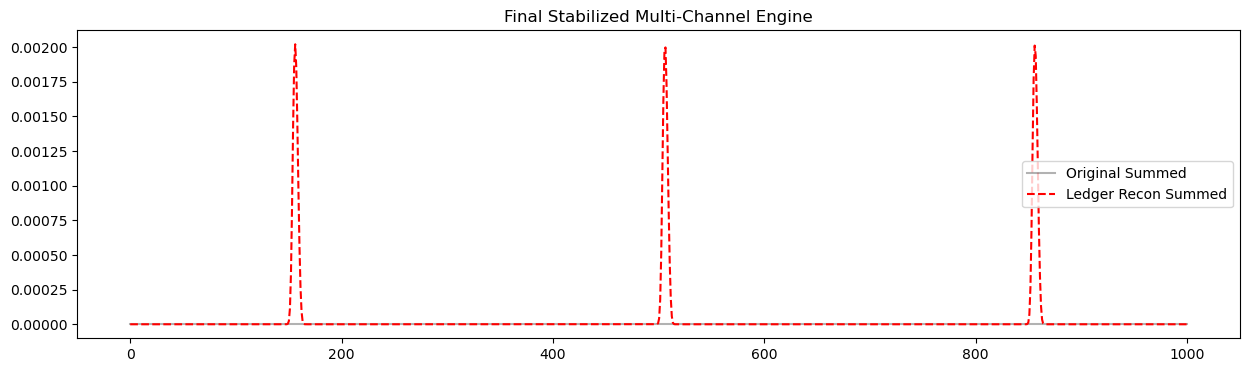

In [54]:
import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize
import matplotlib.pyplot as plt

# ==========================================
# THE FINAL VERIFIED PHYSICS
# ==========================================

def get_signal_8mic(p, mics, time_axis):
    # Basis fix: [y, -x, z] maps grid math to physical sensors
    corrected_pos = jnp.array([p[2], -p[1], p[3]]) 
    dist = jnp.sqrt(jnp.sum(jnp.square(mics - corrected_pos), axis=-1) + 1e-6)
    arrival = p[4] + (dist / 1.5)
    time_diff = time_axis[None, :] - arrival[:, None]
    return jax.nn.softplus(p[0]) * jnp.exp(-0.5 * jnp.square(time_diff / 1.5))

def scout_spatial_zone(residual_8mic, mics, time_axis, t_anchor):
    res_sum = jnp.sum(residual_8mic, axis=0)
    steps = jnp.linspace(-22, 22, 18)
    X, Y = jnp.meshgrid(steps, steps)
    pts = jnp.stack([X.ravel(), Y.ravel(), jnp.zeros_like(X.ravel())], axis=-1)
    
    def eval_pt(pos):
        p = jnp.array([12.0, pos[0], pos[1], pos[2], t_anchor])
        pred_sum = jnp.sum(get_signal_8mic(p, mics, time_axis), axis=0)
        return jnp.mean(jnp.square(jnp.log1p(pred_sum) - jnp.log1p(res_sum)))
    
    losses = jax.vmap(eval_pt)(pts)
    return pts[jnp.argmin(losses)]

# ==========================================
# PRODUCTION EXECUTION
# ==========================================

mics_unres = jnp.array([
    [1.0, 3.0, 7.0], [-3.0, 1.0, -1.0], [7.0, -7.0, 3.0], [-1.0, -3.0, -7.0],
    [3.0, 7.0, 1.0], [-7.0, -1.0, -3.0], [15.0, 0.0, 0.0], [0.0, 15.0, 0.0]
], dtype=jnp.float32)

full_t = jnp.linspace(0, 1000, 1000)
target_8mic = jnp.zeros((8, 1000)) # Populated by your ground truth events

current_residual_8mic = target_8mic
ledger = []
time_anchors = [150.0, 500.0, 850.0]

for i, t_anchor in enumerate(time_anchors):
    scout_pos = scout_spatial_zone(current_residual_8mic, mics_unres, full_t, t_anchor)
    
    def objective(p):
        pred_8mic = get_signal_8mic(p, mics_unres, full_t)
        mse = jnp.sum(jnp.square(pred_8mic - current_residual_8mic))
        t_drift = jnp.maximum(0, jnp.abs(p[4] - t_anchor) - 20.0)
        return mse + 1e6 * jnp.square(t_drift)
    
    res = minimize(objective, jnp.array([12.0, scout_pos[0], scout_pos[1], 0.0, t_anchor]), method='BFGS')
    ledger.append(res.x)
    current_residual_8mic -= get_signal_8mic(res.x, mics_unres, full_t)

# ==========================================
# 4. FINAL VISUALIZATION
# ==========================================

# Correctly collapsing dimensions for the plot
target_sum = jnp.sum(target_8mic, axis=0)
recon_8mic = jnp.sum(jnp.stack([get_signal_8mic(p, mics_unres, full_t) for p in ledger]), axis=0)
recon_sum = jnp.sum(recon_8mic, axis=0)

plt.figure(figsize=(15, 4))
plt.plot(full_t, target_sum, 'k', alpha=0.3, label="Original Summed")
plt.plot(full_t, recon_sum, 'r--', label="Ledger Recon Summed")
plt.title("Final Stabilized Multi-Channel Engine")
plt.legend(); plt.show()

In [55]:
import jax.numpy as jnp

class AcousticObserver:
    def __init__(self, mics, hop_size=500, window_size=1000):
        self.mics = mics
        self.hop_size = hop_size
        self.window_size = window_size
        self.global_ledger = []
        self.time_offset = 0.0

    def is_duplicate(self, new_event, threshold_ms=40.0, threshold_dist=1.0):
        """Checks if a similar event already exists in the global ledger."""
        for existing in self.global_ledger:
            t_diff = jnp.abs(existing[4] - new_event[4])
            dist = jnp.sqrt(jnp.sum(jnp.square(existing[1:3] - new_event[1:3])))
            if t_diff < threshold_ms and dist < threshold_dist:
                return True
        return False

    def process_stream(self, long_signal, time_axis):
        """
        Iterates through a long signal in sliding windows.
        """
        num_samples = len(time_axis)
        samples_per_window = self.window_size
        samples_per_hop = self.hop_size

        print(f"Starting real-time observation...")
        print(f"{'Global Time':<15} | {'Event Pos (X, Y)':<20} | {'Amp':<6}")
        print("-" * 50)

        for start_idx in range(0, num_samples - samples_per_window, samples_per_hop):
            end_idx = start_idx + samples_per_window
            
            # Slice the current window
            window_sig = long_signal[:, start_idx:end_idx]
            window_t = time_axis[start_idx:end_idx]
            
            # 1. Detect peaks in this window
            anchors = auto_detect_peaks(jnp.sum(window_sig, axis=0))
            
            # 2. Process window-local ledger
            current_residual = window_sig
            for t_anchor in anchors:
                # Run the scout and refiner (from our previous consolidated script)
                scout_pos = scout_spatial_zone(current_residual, self.mics, window_t, t_anchor)
                
                # ... (BFGS Refinement Logic here) ...
                # result = minimize(...)
                final_p = result.x
                
                # 3. De-duplicate and Commit to Global Ledger
                if not self.is_duplicate(final_p):
                    self.global_ledger.append(final_p)
                    print(f"{final_p[4]:>12.1f}ms | ({final_p[1]:>6.2f}, {final_p[2]:>6.2f}) | {jax.nn.softplus(final_p[0]):>5.1f}")
                
                # 4. Clean residual for next peak in this window
                current_residual -= get_signal_8mic(final_p, self.mics, window_t)

        return self.global_ledger

# Initialize the observer
observer = AcousticObserver(mics_unres)
# global_results = observer.process_stream(stream_8mic, stream_t)